In [13]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
import catboost as ctb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

## LECTURA Y PROCESO DE LOS DATOS

In [1]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "TRF", "Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [4]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [10]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)

    return (data)

In [11]:
df = preprocess(data)

In [175]:
model_prediction_list = []

## MODELO 1: LIGHTGBM

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0, stratify = df.Stage)
categorical = [x for x in df.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data = x_train.drop(target, axis = 1), label = x_train.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 30,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

model1 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

/home/eugenio/.local/lib/python2.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/eugenio/.local/lib/python2.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Account_Owner', 'Billing_Country', 'Bureaucratic_Code', 'Currency', 'Delivery_Quarter', 'Last_Modified_By', 'Opportunity_Owner', 'Region', 'Source', 'TRF_Cat', 'Territory']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.677077
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.669307
[3]	valid_0's binary_logloss: 0.656655
[4]	valid_0's binary_logloss: 0.649736
[5]	valid_0's binary_logloss: 0.642536
[6]	valid_0's binary_logloss: 0.637988
[7]	valid_0's binary_logloss: 0.631087
[8]	valid_0's binary_logloss: 0.624721
[9]	valid_0's binary_logloss: 0.618286
[10]	valid_0's binary_logloss: 0.607216
[11]	valid_0's binary_logloss: 0.601221
[12]	valid_0's binary_logloss: 0.590672
[13]	valid_0's binary_logloss: 0.585369
[14]	valid_0's binary_logloss: 0.579489
[15]	valid_0's binary_logloss: 0.569629
[16]	valid_0's binary_logloss: 0.559837
[17]	valid_0's binary_logloss: 0.554425
[18]	valid_0's binary_logloss: 0.545158
[19]	valid_0's binary_logloss: 0.541147
[20]	valid_0's binary_logloss: 0.536472
[21]	valid_0's binary_logloss: 0.527572
[22]	valid_0's binary_logloss: 0.523125
[23]	valid_0's binary_logloss: 0.514533
[24]	valid_0's binary_loglo

[206]	valid_0's binary_logloss: 0.1397
[207]	valid_0's binary_logloss: 0.139405
[208]	valid_0's binary_logloss: 0.139069
[209]	valid_0's binary_logloss: 0.138791
[210]	valid_0's binary_logloss: 0.138548
[211]	valid_0's binary_logloss: 0.137535
[212]	valid_0's binary_logloss: 0.137272
[213]	valid_0's binary_logloss: 0.13698
[214]	valid_0's binary_logloss: 0.13595
[215]	valid_0's binary_logloss: 0.135769
[216]	valid_0's binary_logloss: 0.135486
[217]	valid_0's binary_logloss: 0.134555
[218]	valid_0's binary_logloss: 0.1343
[219]	valid_0's binary_logloss: 0.13407
[220]	valid_0's binary_logloss: 0.133159
[221]	valid_0's binary_logloss: 0.132249
[222]	valid_0's binary_logloss: 0.132043
[223]	valid_0's binary_logloss: 0.131174
[224]	valid_0's binary_logloss: 0.130203
[225]	valid_0's binary_logloss: 0.129414
[226]	valid_0's binary_logloss: 0.129082
[227]	valid_0's binary_logloss: 0.128279
[228]	valid_0's binary_logloss: 0.127479
[229]	valid_0's binary_logloss: 0.127289
[230]	valid_0's binary_

[407]	valid_0's binary_logloss: 0.0812084
[408]	valid_0's binary_logloss: 0.0810053
[409]	valid_0's binary_logloss: 0.0808636
[410]	valid_0's binary_logloss: 0.0807781
[411]	valid_0's binary_logloss: 0.0805367
[412]	valid_0's binary_logloss: 0.0803996
[413]	valid_0's binary_logloss: 0.0802277
[414]	valid_0's binary_logloss: 0.0800509
[415]	valid_0's binary_logloss: 0.0799593
[416]	valid_0's binary_logloss: 0.0797961
[417]	valid_0's binary_logloss: 0.0797359
[418]	valid_0's binary_logloss: 0.0795784
[419]	valid_0's binary_logloss: 0.0795447
[420]	valid_0's binary_logloss: 0.0793884
[421]	valid_0's binary_logloss: 0.0793373
[422]	valid_0's binary_logloss: 0.0792577
[423]	valid_0's binary_logloss: 0.0791058
[424]	valid_0's binary_logloss: 0.0789398
[425]	valid_0's binary_logloss: 0.0789179
[426]	valid_0's binary_logloss: 0.0788866
[427]	valid_0's binary_logloss: 0.078793
[428]	valid_0's binary_logloss: 0.0787584
[429]	valid_0's binary_logloss: 0.0786797
[430]	valid_0's binary_logloss: 0.0

[620]	valid_0's binary_logloss: 0.0669094
[621]	valid_0's binary_logloss: 0.066859
[622]	valid_0's binary_logloss: 0.0668329
[623]	valid_0's binary_logloss: 0.0668499
[624]	valid_0's binary_logloss: 0.0668397
[625]	valid_0's binary_logloss: 0.0667757
[626]	valid_0's binary_logloss: 0.0667411
[627]	valid_0's binary_logloss: 0.0667101
[628]	valid_0's binary_logloss: 0.0666942
[629]	valid_0's binary_logloss: 0.0666834
[630]	valid_0's binary_logloss: 0.0666628
[631]	valid_0's binary_logloss: 0.0666286
[632]	valid_0's binary_logloss: 0.0666493
[633]	valid_0's binary_logloss: 0.066634
[634]	valid_0's binary_logloss: 0.0666109
[635]	valid_0's binary_logloss: 0.0665468
[636]	valid_0's binary_logloss: 0.0665409
[637]	valid_0's binary_logloss: 0.0665192
[638]	valid_0's binary_logloss: 0.0664909
[639]	valid_0's binary_logloss: 0.066479
[640]	valid_0's binary_logloss: 0.0664399
[641]	valid_0's binary_logloss: 0.0664375
[642]	valid_0's binary_logloss: 0.0664479
[643]	valid_0's binary_logloss: 0.066

[831]	valid_0's binary_logloss: 0.0640811
[832]	valid_0's binary_logloss: 0.0640975
[833]	valid_0's binary_logloss: 0.0640932
[834]	valid_0's binary_logloss: 0.0640803
[835]	valid_0's binary_logloss: 0.0640715
[836]	valid_0's binary_logloss: 0.0640659
[837]	valid_0's binary_logloss: 0.0640928
[838]	valid_0's binary_logloss: 0.0641208
[839]	valid_0's binary_logloss: 0.0641689
[840]	valid_0's binary_logloss: 0.0641944
[841]	valid_0's binary_logloss: 0.0641668
[842]	valid_0's binary_logloss: 0.0641752
[843]	valid_0's binary_logloss: 0.064144
[844]	valid_0's binary_logloss: 0.0641308
[845]	valid_0's binary_logloss: 0.064124
[846]	valid_0's binary_logloss: 0.0641268
[847]	valid_0's binary_logloss: 0.0641169
[848]	valid_0's binary_logloss: 0.0641269
[849]	valid_0's binary_logloss: 0.0641521
[850]	valid_0's binary_logloss: 0.0641507
[851]	valid_0's binary_logloss: 0.0641535
[852]	valid_0's binary_logloss: 0.0641397
[853]	valid_0's binary_logloss: 0.064174
[854]	valid_0's binary_logloss: 0.064

[1044]	valid_0's binary_logloss: 0.064808
[1045]	valid_0's binary_logloss: 0.0648017
[1046]	valid_0's binary_logloss: 0.0647931
[1047]	valid_0's binary_logloss: 0.064779
[1048]	valid_0's binary_logloss: 0.0648097
[1049]	valid_0's binary_logloss: 0.0647901
[1050]	valid_0's binary_logloss: 0.0648084
[1051]	valid_0's binary_logloss: 0.064805
[1052]	valid_0's binary_logloss: 0.0648226
[1053]	valid_0's binary_logloss: 0.0648596
[1054]	valid_0's binary_logloss: 0.0648452
[1055]	valid_0's binary_logloss: 0.0648299
[1056]	valid_0's binary_logloss: 0.0648005
[1057]	valid_0's binary_logloss: 0.0648226
[1058]	valid_0's binary_logloss: 0.0648217
[1059]	valid_0's binary_logloss: 0.0648221
[1060]	valid_0's binary_logloss: 0.0648484
[1061]	valid_0's binary_logloss: 0.0648873
[1062]	valid_0's binary_logloss: 0.064913
[1063]	valid_0's binary_logloss: 0.0649745
[1064]	valid_0's binary_logloss: 0.0649937
[1065]	valid_0's binary_logloss: 0.0649992
[1066]	valid_0's binary_logloss: 0.0650708
[1067]	valid_0'

[1253]	valid_0's binary_logloss: 0.0674542
[1254]	valid_0's binary_logloss: 0.0674673
[1255]	valid_0's binary_logloss: 0.0674609
[1256]	valid_0's binary_logloss: 0.0674752
[1257]	valid_0's binary_logloss: 0.0674721
[1258]	valid_0's binary_logloss: 0.0674815
[1259]	valid_0's binary_logloss: 0.0675452
[1260]	valid_0's binary_logloss: 0.0675446
[1261]	valid_0's binary_logloss: 0.0676145
[1262]	valid_0's binary_logloss: 0.0676029
[1263]	valid_0's binary_logloss: 0.0676241
[1264]	valid_0's binary_logloss: 0.067695
[1265]	valid_0's binary_logloss: 0.0676852
[1266]	valid_0's binary_logloss: 0.0677131
[1267]	valid_0's binary_logloss: 0.0677596
[1268]	valid_0's binary_logloss: 0.0677892
[1269]	valid_0's binary_logloss: 0.0678038
[1270]	valid_0's binary_logloss: 0.0678133
[1271]	valid_0's binary_logloss: 0.067817
[1272]	valid_0's binary_logloss: 0.0678171
[1273]	valid_0's binary_logloss: 0.0678759
[1274]	valid_0's binary_logloss: 0.0678674
[1275]	valid_0's binary_logloss: 0.0679219
[1276]	valid_

In [176]:
y_pred = model1.predict(df.drop(target, axis = 1))

In [177]:
model_prediction_list.append(y_pred)

## MODELO 2: CATBOOST

In [138]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
cat_indexes = [x_train.drop(target, axis = 1).columns.get_loc(x) for x in categorical if x != "TRF_Cat"]

In [139]:
model2 = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               use_best_model = True,
                               random_seed = 42)
model2.fit(x_train.drop(target, axis = 1), y_train, eval_set = (x_test.drop(target, axis=1), y_test), cat_features = cat_indexes, early_stopping_rounds = 800)

0:	learn: 0.6662320	test: 0.6666361	best: 0.6666361 (0)	total: 251ms	remaining: 20m 55s
1:	learn: 0.6429421	test: 0.6436226	best: 0.6436226 (1)	total: 417ms	remaining: 17m 21s
2:	learn: 0.6216509	test: 0.6225760	best: 0.6225760 (2)	total: 563ms	remaining: 15m 37s
3:	learn: 0.5973714	test: 0.5985329	best: 0.5985329 (3)	total: 642ms	remaining: 13m 22s
4:	learn: 0.5773562	test: 0.5786428	best: 0.5786428 (4)	total: 713ms	remaining: 11m 52s
5:	learn: 0.5590138	test: 0.5604702	best: 0.5604702 (5)	total: 739ms	remaining: 10m 15s
6:	learn: 0.5404298	test: 0.5413506	best: 0.5413506 (6)	total: 839ms	remaining: 9m 58s
7:	learn: 0.5231761	test: 0.5243156	best: 0.5243156 (7)	total: 876ms	remaining: 9m 6s
8:	learn: 0.5056932	test: 0.5075932	best: 0.5075932 (8)	total: 945ms	remaining: 8m 44s
9:	learn: 0.4882563	test: 0.4904856	best: 0.4904856 (9)	total: 1.02s	remaining: 8m 27s
10:	learn: 0.4727450	test: 0.4752240	best: 0.4752240 (10)	total: 1.09s	remaining: 8m 12s
11:	learn: 0.4590669	test: 0.4617270

94:	learn: 0.1218370	test: 0.1321457	best: 0.1321457 (94)	total: 8.1s	remaining: 6m 58s
95:	learn: 0.1211156	test: 0.1314874	best: 0.1314874 (95)	total: 8.18s	remaining: 6m 57s
96:	learn: 0.1203174	test: 0.1307778	best: 0.1307778 (96)	total: 8.28s	remaining: 6m 58s
97:	learn: 0.1195648	test: 0.1300276	best: 0.1300276 (97)	total: 8.38s	remaining: 6m 59s
98:	learn: 0.1187170	test: 0.1292862	best: 0.1292862 (98)	total: 8.46s	remaining: 6m 58s
99:	learn: 0.1184590	test: 0.1290435	best: 0.1290435 (99)	total: 8.49s	remaining: 6m 55s
100:	learn: 0.1176779	test: 0.1283222	best: 0.1283222 (100)	total: 8.56s	remaining: 6m 55s
101:	learn: 0.1169994	test: 0.1277097	best: 0.1277097 (101)	total: 8.67s	remaining: 6m 56s
102:	learn: 0.1163760	test: 0.1271325	best: 0.1271325 (102)	total: 8.74s	remaining: 6m 55s
103:	learn: 0.1157885	test: 0.1266074	best: 0.1266074 (103)	total: 8.83s	remaining: 6m 55s
104:	learn: 0.1153557	test: 0.1262293	best: 0.1262293 (104)	total: 8.93s	remaining: 6m 56s
105:	learn: 

187:	learn: 0.0892496	test: 0.1039258	best: 0.1039258 (187)	total: 16.7s	remaining: 7m 8s
188:	learn: 0.0890528	test: 0.1037756	best: 0.1037756 (188)	total: 16.8s	remaining: 7m 8s
189:	learn: 0.0888709	test: 0.1035642	best: 0.1035642 (189)	total: 16.9s	remaining: 7m 8s
190:	learn: 0.0886846	test: 0.1033635	best: 0.1033635 (190)	total: 17s	remaining: 7m 8s
191:	learn: 0.0885327	test: 0.1032404	best: 0.1032404 (191)	total: 17.1s	remaining: 7m 7s
192:	learn: 0.0883016	test: 0.1030906	best: 0.1030906 (192)	total: 17.2s	remaining: 7m 7s
193:	learn: 0.0880725	test: 0.1029463	best: 0.1029463 (193)	total: 17.3s	remaining: 7m 7s
194:	learn: 0.0879826	test: 0.1028495	best: 0.1028495 (194)	total: 17.3s	remaining: 7m 7s
195:	learn: 0.0877902	test: 0.1027403	best: 0.1027403 (195)	total: 17.4s	remaining: 7m 6s
196:	learn: 0.0875712	test: 0.1025750	best: 0.1025750 (196)	total: 17.5s	remaining: 7m 6s
197:	learn: 0.0874899	test: 0.1025216	best: 0.1025216 (197)	total: 17.6s	remaining: 7m 6s
198:	learn: 

279:	learn: 0.0760530	test: 0.0939516	best: 0.0939516 (279)	total: 25.2s	remaining: 7m 4s
280:	learn: 0.0758541	test: 0.0937793	best: 0.0937793 (280)	total: 25.2s	remaining: 7m 4s
281:	learn: 0.0757854	test: 0.0937259	best: 0.0937259 (281)	total: 25.3s	remaining: 7m 3s
282:	learn: 0.0755799	test: 0.0935956	best: 0.0935956 (282)	total: 25.4s	remaining: 7m 3s
283:	learn: 0.0754156	test: 0.0934579	best: 0.0934579 (283)	total: 25.5s	remaining: 7m 3s
284:	learn: 0.0753467	test: 0.0934132	best: 0.0934132 (284)	total: 25.6s	remaining: 7m 3s
285:	learn: 0.0751822	test: 0.0932636	best: 0.0932636 (285)	total: 25.7s	remaining: 7m 3s
286:	learn: 0.0750065	test: 0.0932067	best: 0.0932067 (286)	total: 25.8s	remaining: 7m 3s
287:	learn: 0.0749518	test: 0.0931440	best: 0.0931440 (287)	total: 25.8s	remaining: 7m 2s
288:	learn: 0.0748420	test: 0.0930404	best: 0.0930404 (288)	total: 25.9s	remaining: 7m 2s
289:	learn: 0.0748037	test: 0.0930220	best: 0.0930220 (289)	total: 26s	remaining: 7m 2s
290:	learn: 

372:	learn: 0.0676799	test: 0.0881457	best: 0.0881457 (372)	total: 32.7s	remaining: 6m 46s
373:	learn: 0.0676091	test: 0.0881051	best: 0.0881051 (373)	total: 32.8s	remaining: 6m 46s
374:	learn: 0.0674606	test: 0.0880272	best: 0.0880272 (374)	total: 32.9s	remaining: 6m 45s
375:	learn: 0.0673482	test: 0.0879611	best: 0.0879611 (375)	total: 33s	remaining: 6m 45s
376:	learn: 0.0673179	test: 0.0879425	best: 0.0879425 (376)	total: 33.1s	remaining: 6m 45s
377:	learn: 0.0672593	test: 0.0879204	best: 0.0879204 (377)	total: 33.2s	remaining: 6m 45s
378:	learn: 0.0671375	test: 0.0878782	best: 0.0878782 (378)	total: 33.3s	remaining: 6m 45s
379:	learn: 0.0670964	test: 0.0878392	best: 0.0878392 (379)	total: 33.3s	remaining: 6m 45s
380:	learn: 0.0670371	test: 0.0878069	best: 0.0878069 (380)	total: 33.4s	remaining: 6m 45s
381:	learn: 0.0669159	test: 0.0877223	best: 0.0877223 (381)	total: 33.5s	remaining: 6m 45s
382:	learn: 0.0668881	test: 0.0877116	best: 0.0877116 (382)	total: 33.6s	remaining: 6m 44s
3

465:	learn: 0.0629675	test: 0.0854325	best: 0.0854325 (465)	total: 40.1s	remaining: 6m 30s
466:	learn: 0.0629319	test: 0.0854322	best: 0.0854322 (466)	total: 40.2s	remaining: 6m 29s
467:	learn: 0.0628259	test: 0.0853965	best: 0.0853965 (467)	total: 40.2s	remaining: 6m 29s
468:	learn: 0.0628016	test: 0.0853933	best: 0.0853933 (468)	total: 40.3s	remaining: 6m 29s
469:	learn: 0.0627182	test: 0.0853455	best: 0.0853455 (469)	total: 40.4s	remaining: 6m 29s
470:	learn: 0.0626953	test: 0.0853248	best: 0.0853248 (470)	total: 40.5s	remaining: 6m 29s
471:	learn: 0.0626778	test: 0.0853148	best: 0.0853148 (471)	total: 40.6s	remaining: 6m 29s
472:	learn: 0.0626078	test: 0.0852856	best: 0.0852856 (472)	total: 40.7s	remaining: 6m 29s
473:	learn: 0.0625321	test: 0.0852439	best: 0.0852439 (473)	total: 40.7s	remaining: 6m 29s
474:	learn: 0.0624124	test: 0.0851183	best: 0.0851183 (474)	total: 40.8s	remaining: 6m 28s
475:	learn: 0.0623277	test: 0.0850733	best: 0.0850733 (475)	total: 40.9s	remaining: 6m 28s

557:	learn: 0.0581223	test: 0.0825910	best: 0.0825910 (557)	total: 47.9s	remaining: 6m 21s
558:	learn: 0.0581061	test: 0.0825795	best: 0.0825795 (558)	total: 48s	remaining: 6m 21s
559:	learn: 0.0581046	test: 0.0825778	best: 0.0825778 (559)	total: 48s	remaining: 6m 20s
560:	learn: 0.0580626	test: 0.0825605	best: 0.0825605 (560)	total: 48.1s	remaining: 6m 20s
561:	learn: 0.0580351	test: 0.0825408	best: 0.0825408 (561)	total: 48.2s	remaining: 6m 20s
562:	learn: 0.0580271	test: 0.0825360	best: 0.0825360 (562)	total: 48.3s	remaining: 6m 20s
563:	learn: 0.0580258	test: 0.0825375	best: 0.0825360 (562)	total: 48.3s	remaining: 6m 19s
564:	learn: 0.0579912	test: 0.0825029	best: 0.0825029 (564)	total: 48.4s	remaining: 6m 19s
565:	learn: 0.0579402	test: 0.0824924	best: 0.0824924 (565)	total: 48.5s	remaining: 6m 19s
566:	learn: 0.0579037	test: 0.0824376	best: 0.0824376 (566)	total: 48.5s	remaining: 6m 19s
567:	learn: 0.0578414	test: 0.0823852	best: 0.0823852 (567)	total: 48.6s	remaining: 6m 19s
568

649:	learn: 0.0544886	test: 0.0803855	best: 0.0803855 (649)	total: 55.6s	remaining: 6m 11s
650:	learn: 0.0544434	test: 0.0803507	best: 0.0803507 (650)	total: 55.6s	remaining: 6m 11s
651:	learn: 0.0543446	test: 0.0802604	best: 0.0802604 (651)	total: 55.7s	remaining: 6m 11s
652:	learn: 0.0542783	test: 0.0802210	best: 0.0802210 (652)	total: 55.8s	remaining: 6m 11s
653:	learn: 0.0542340	test: 0.0802006	best: 0.0802006 (653)	total: 55.9s	remaining: 6m 11s
654:	learn: 0.0541586	test: 0.0801146	best: 0.0801146 (654)	total: 56s	remaining: 6m 11s
655:	learn: 0.0541009	test: 0.0800891	best: 0.0800891 (655)	total: 56.1s	remaining: 6m 11s
656:	learn: 0.0540484	test: 0.0800787	best: 0.0800787 (656)	total: 56.2s	remaining: 6m 11s
657:	learn: 0.0540333	test: 0.0800651	best: 0.0800651 (657)	total: 56.2s	remaining: 6m 11s
658:	learn: 0.0539793	test: 0.0800243	best: 0.0800243 (658)	total: 56.3s	remaining: 6m 11s
659:	learn: 0.0538770	test: 0.0799884	best: 0.0799884 (659)	total: 56.4s	remaining: 6m 10s
6

743:	learn: 0.0498382	test: 0.0778256	best: 0.0778256 (743)	total: 1m 3s	remaining: 6m 2s
744:	learn: 0.0498051	test: 0.0778032	best: 0.0778032 (744)	total: 1m 3s	remaining: 6m 2s
745:	learn: 0.0496933	test: 0.0776966	best: 0.0776966 (745)	total: 1m 3s	remaining: 6m 2s
746:	learn: 0.0496894	test: 0.0776962	best: 0.0776962 (746)	total: 1m 3s	remaining: 6m 2s
747:	learn: 0.0496680	test: 0.0776786	best: 0.0776786 (747)	total: 1m 3s	remaining: 6m 2s
748:	learn: 0.0496233	test: 0.0776477	best: 0.0776477 (748)	total: 1m 3s	remaining: 6m 2s
749:	learn: 0.0495583	test: 0.0775952	best: 0.0775952 (749)	total: 1m 3s	remaining: 6m 2s
750:	learn: 0.0495370	test: 0.0775788	best: 0.0775788 (750)	total: 1m 4s	remaining: 6m 2s
751:	learn: 0.0495021	test: 0.0775595	best: 0.0775595 (751)	total: 1m 4s	remaining: 6m 2s
752:	learn: 0.0494244	test: 0.0775353	best: 0.0775353 (752)	total: 1m 4s	remaining: 6m 2s
753:	learn: 0.0493644	test: 0.0775186	best: 0.0775186 (753)	total: 1m 4s	remaining: 6m 1s
754:	learn

836:	learn: 0.0457883	test: 0.0751916	best: 0.0751916 (836)	total: 1m 11s	remaining: 5m 53s
837:	learn: 0.0457376	test: 0.0751603	best: 0.0751603 (837)	total: 1m 11s	remaining: 5m 53s
838:	learn: 0.0456928	test: 0.0751479	best: 0.0751479 (838)	total: 1m 11s	remaining: 5m 53s
839:	learn: 0.0456788	test: 0.0751465	best: 0.0751465 (839)	total: 1m 11s	remaining: 5m 53s
840:	learn: 0.0456513	test: 0.0751375	best: 0.0751375 (840)	total: 1m 11s	remaining: 5m 53s
841:	learn: 0.0456009	test: 0.0750932	best: 0.0750932 (841)	total: 1m 11s	remaining: 5m 52s
842:	learn: 0.0455611	test: 0.0750518	best: 0.0750518 (842)	total: 1m 11s	remaining: 5m 52s
843:	learn: 0.0455301	test: 0.0750225	best: 0.0750225 (843)	total: 1m 11s	remaining: 5m 52s
844:	learn: 0.0455091	test: 0.0750308	best: 0.0750225 (843)	total: 1m 11s	remaining: 5m 52s
845:	learn: 0.0454569	test: 0.0749968	best: 0.0749968 (845)	total: 1m 11s	remaining: 5m 52s
846:	learn: 0.0454453	test: 0.0749922	best: 0.0749922 (846)	total: 1m 11s	remain

928:	learn: 0.0425612	test: 0.0731401	best: 0.0731401 (928)	total: 1m 18s	remaining: 5m 44s
929:	learn: 0.0425368	test: 0.0731342	best: 0.0731342 (929)	total: 1m 18s	remaining: 5m 44s
930:	learn: 0.0425201	test: 0.0731320	best: 0.0731320 (930)	total: 1m 18s	remaining: 5m 44s
931:	learn: 0.0424771	test: 0.0730980	best: 0.0730980 (931)	total: 1m 18s	remaining: 5m 44s
932:	learn: 0.0424075	test: 0.0730718	best: 0.0730718 (932)	total: 1m 18s	remaining: 5m 44s
933:	learn: 0.0423322	test: 0.0730410	best: 0.0730410 (933)	total: 1m 19s	remaining: 5m 44s
934:	learn: 0.0422433	test: 0.0729826	best: 0.0729826 (934)	total: 1m 19s	remaining: 5m 43s
935:	learn: 0.0422100	test: 0.0729566	best: 0.0729566 (935)	total: 1m 19s	remaining: 5m 43s
936:	learn: 0.0421179	test: 0.0729323	best: 0.0729323 (936)	total: 1m 19s	remaining: 5m 43s
937:	learn: 0.0420792	test: 0.0729166	best: 0.0729166 (937)	total: 1m 19s	remaining: 5m 43s
938:	learn: 0.0420519	test: 0.0729116	best: 0.0729116 (938)	total: 1m 19s	remain

1018:	learn: 0.0401320	test: 0.0718711	best: 0.0718711 (1018)	total: 1m 26s	remaining: 5m 36s
1019:	learn: 0.0400595	test: 0.0718146	best: 0.0718146 (1019)	total: 1m 26s	remaining: 5m 36s
1020:	learn: 0.0400159	test: 0.0717859	best: 0.0717859 (1020)	total: 1m 26s	remaining: 5m 36s
1021:	learn: 0.0399836	test: 0.0717786	best: 0.0717786 (1021)	total: 1m 26s	remaining: 5m 35s
1022:	learn: 0.0399744	test: 0.0717788	best: 0.0717786 (1021)	total: 1m 26s	remaining: 5m 35s
1023:	learn: 0.0399364	test: 0.0717316	best: 0.0717316 (1023)	total: 1m 26s	remaining: 5m 35s
1024:	learn: 0.0398932	test: 0.0717110	best: 0.0717110 (1024)	total: 1m 26s	remaining: 5m 35s
1025:	learn: 0.0398437	test: 0.0716910	best: 0.0716910 (1025)	total: 1m 26s	remaining: 5m 35s
1026:	learn: 0.0398229	test: 0.0716745	best: 0.0716745 (1026)	total: 1m 26s	remaining: 5m 35s
1027:	learn: 0.0398145	test: 0.0716666	best: 0.0716666 (1027)	total: 1m 26s	remaining: 5m 35s
1028:	learn: 0.0398050	test: 0.0716708	best: 0.0716666 (1027

1108:	learn: 0.0377810	test: 0.0708588	best: 0.0708588 (1108)	total: 1m 33s	remaining: 5m 28s
1109:	learn: 0.0377593	test: 0.0708426	best: 0.0708426 (1109)	total: 1m 33s	remaining: 5m 28s
1110:	learn: 0.0377419	test: 0.0708420	best: 0.0708420 (1110)	total: 1m 33s	remaining: 5m 27s
1111:	learn: 0.0377045	test: 0.0708322	best: 0.0708322 (1111)	total: 1m 33s	remaining: 5m 27s
1112:	learn: 0.0376954	test: 0.0708324	best: 0.0708322 (1111)	total: 1m 33s	remaining: 5m 27s
1113:	learn: 0.0376867	test: 0.0708337	best: 0.0708322 (1111)	total: 1m 33s	remaining: 5m 27s
1114:	learn: 0.0376461	test: 0.0708171	best: 0.0708171 (1114)	total: 1m 34s	remaining: 5m 27s
1115:	learn: 0.0375785	test: 0.0707451	best: 0.0707451 (1115)	total: 1m 34s	remaining: 5m 27s
1116:	learn: 0.0375743	test: 0.0707391	best: 0.0707391 (1116)	total: 1m 34s	remaining: 5m 27s
1117:	learn: 0.0375558	test: 0.0707391	best: 0.0707391 (1117)	total: 1m 34s	remaining: 5m 27s
1118:	learn: 0.0375203	test: 0.0707135	best: 0.0707135 (1118

1197:	learn: 0.0356091	test: 0.0697832	best: 0.0697832 (1197)	total: 1m 40s	remaining: 5m 20s
1198:	learn: 0.0355838	test: 0.0697742	best: 0.0697742 (1198)	total: 1m 41s	remaining: 5m 20s
1199:	learn: 0.0355824	test: 0.0697792	best: 0.0697742 (1198)	total: 1m 41s	remaining: 5m 20s
1200:	learn: 0.0355703	test: 0.0697585	best: 0.0697585 (1200)	total: 1m 41s	remaining: 5m 20s
1201:	learn: 0.0355261	test: 0.0697206	best: 0.0697206 (1201)	total: 1m 41s	remaining: 5m 20s
1202:	learn: 0.0354458	test: 0.0696677	best: 0.0696677 (1202)	total: 1m 41s	remaining: 5m 20s
1203:	learn: 0.0354449	test: 0.0696666	best: 0.0696666 (1203)	total: 1m 41s	remaining: 5m 19s
1204:	learn: 0.0354368	test: 0.0696667	best: 0.0696666 (1203)	total: 1m 41s	remaining: 5m 19s
1205:	learn: 0.0354320	test: 0.0696665	best: 0.0696665 (1205)	total: 1m 41s	remaining: 5m 19s
1206:	learn: 0.0354185	test: 0.0696588	best: 0.0696588 (1206)	total: 1m 41s	remaining: 5m 19s
1207:	learn: 0.0354111	test: 0.0696569	best: 0.0696569 (1207

1287:	learn: 0.0336272	test: 0.0687086	best: 0.0687086 (1287)	total: 1m 48s	remaining: 5m 13s
1288:	learn: 0.0335925	test: 0.0686873	best: 0.0686873 (1288)	total: 1m 48s	remaining: 5m 13s
1289:	learn: 0.0335522	test: 0.0686824	best: 0.0686824 (1289)	total: 1m 48s	remaining: 5m 13s
1290:	learn: 0.0335414	test: 0.0686756	best: 0.0686756 (1290)	total: 1m 49s	remaining: 5m 13s
1291:	learn: 0.0334972	test: 0.0686709	best: 0.0686709 (1291)	total: 1m 49s	remaining: 5m 13s
1292:	learn: 0.0334560	test: 0.0686672	best: 0.0686672 (1292)	total: 1m 49s	remaining: 5m 13s
1293:	learn: 0.0334432	test: 0.0686718	best: 0.0686672 (1292)	total: 1m 49s	remaining: 5m 13s
1294:	learn: 0.0334053	test: 0.0686447	best: 0.0686447 (1294)	total: 1m 49s	remaining: 5m 12s
1295:	learn: 0.0333509	test: 0.0685918	best: 0.0685918 (1295)	total: 1m 49s	remaining: 5m 12s
1296:	learn: 0.0333425	test: 0.0685872	best: 0.0685872 (1296)	total: 1m 49s	remaining: 5m 12s
1297:	learn: 0.0333271	test: 0.0685727	best: 0.0685727 (1297

1377:	learn: 0.0314693	test: 0.0677049	best: 0.0677049 (1377)	total: 1m 56s	remaining: 5m 5s
1378:	learn: 0.0314612	test: 0.0676908	best: 0.0676908 (1378)	total: 1m 56s	remaining: 5m 5s
1379:	learn: 0.0314539	test: 0.0676844	best: 0.0676844 (1379)	total: 1m 56s	remaining: 5m 5s
1380:	learn: 0.0314233	test: 0.0676744	best: 0.0676744 (1380)	total: 1m 56s	remaining: 5m 5s
1381:	learn: 0.0313818	test: 0.0676417	best: 0.0676417 (1381)	total: 1m 56s	remaining: 5m 5s
1382:	learn: 0.0313568	test: 0.0676398	best: 0.0676398 (1382)	total: 1m 56s	remaining: 5m 5s
1383:	learn: 0.0313418	test: 0.0676394	best: 0.0676394 (1383)	total: 1m 56s	remaining: 5m 5s
1384:	learn: 0.0313206	test: 0.0676377	best: 0.0676377 (1384)	total: 1m 56s	remaining: 5m 5s
1385:	learn: 0.0313094	test: 0.0676435	best: 0.0676377 (1384)	total: 1m 57s	remaining: 5m 5s
1386:	learn: 0.0313031	test: 0.0676344	best: 0.0676344 (1386)	total: 1m 57s	remaining: 5m 5s
1387:	learn: 0.0312970	test: 0.0676255	best: 0.0676255 (1387)	total: 1

1467:	learn: 0.0297487	test: 0.0669463	best: 0.0669463 (1467)	total: 2m 3s	remaining: 4m 58s
1468:	learn: 0.0297414	test: 0.0669465	best: 0.0669463 (1467)	total: 2m 3s	remaining: 4m 58s
1469:	learn: 0.0297085	test: 0.0669466	best: 0.0669463 (1467)	total: 2m 4s	remaining: 4m 57s
1470:	learn: 0.0296738	test: 0.0669318	best: 0.0669318 (1470)	total: 2m 4s	remaining: 4m 57s
1471:	learn: 0.0296590	test: 0.0669135	best: 0.0669135 (1471)	total: 2m 4s	remaining: 4m 57s
1472:	learn: 0.0296223	test: 0.0668845	best: 0.0668845 (1472)	total: 2m 4s	remaining: 4m 57s
1473:	learn: 0.0296170	test: 0.0668782	best: 0.0668782 (1473)	total: 2m 4s	remaining: 4m 57s
1474:	learn: 0.0296124	test: 0.0668730	best: 0.0668730 (1474)	total: 2m 4s	remaining: 4m 57s
1475:	learn: 0.0296040	test: 0.0668568	best: 0.0668568 (1475)	total: 2m 4s	remaining: 4m 57s
1476:	learn: 0.0295935	test: 0.0668529	best: 0.0668529 (1476)	total: 2m 4s	remaining: 4m 57s
1477:	learn: 0.0295621	test: 0.0668478	best: 0.0668478 (1477)	total: 2

1557:	learn: 0.0280924	test: 0.0662128	best: 0.0662128 (1557)	total: 2m 11s	remaining: 4m 51s
1558:	learn: 0.0280633	test: 0.0662179	best: 0.0662128 (1557)	total: 2m 12s	remaining: 4m 51s
1559:	learn: 0.0280616	test: 0.0662142	best: 0.0662128 (1557)	total: 2m 12s	remaining: 4m 51s
1560:	learn: 0.0280538	test: 0.0662135	best: 0.0662128 (1557)	total: 2m 12s	remaining: 4m 51s
1561:	learn: 0.0280496	test: 0.0662087	best: 0.0662087 (1561)	total: 2m 12s	remaining: 4m 51s
1562:	learn: 0.0280416	test: 0.0661993	best: 0.0661993 (1562)	total: 2m 12s	remaining: 4m 50s
1563:	learn: 0.0280168	test: 0.0661908	best: 0.0661908 (1563)	total: 2m 12s	remaining: 4m 50s
1564:	learn: 0.0279966	test: 0.0661778	best: 0.0661778 (1564)	total: 2m 12s	remaining: 4m 50s
1565:	learn: 0.0279784	test: 0.0661656	best: 0.0661656 (1565)	total: 2m 12s	remaining: 4m 50s
1566:	learn: 0.0279747	test: 0.0661633	best: 0.0661633 (1566)	total: 2m 12s	remaining: 4m 50s
1567:	learn: 0.0279670	test: 0.0661619	best: 0.0661619 (1567

1647:	learn: 0.0265931	test: 0.0655421	best: 0.0655421 (1647)	total: 2m 19s	remaining: 4m 43s
1648:	learn: 0.0265839	test: 0.0655359	best: 0.0655359 (1648)	total: 2m 19s	remaining: 4m 43s
1649:	learn: 0.0265339	test: 0.0654994	best: 0.0654994 (1649)	total: 2m 19s	remaining: 4m 43s
1650:	learn: 0.0265093	test: 0.0654960	best: 0.0654960 (1650)	total: 2m 19s	remaining: 4m 43s
1651:	learn: 0.0264859	test: 0.0654964	best: 0.0654960 (1650)	total: 2m 19s	remaining: 4m 43s
1652:	learn: 0.0264773	test: 0.0654986	best: 0.0654960 (1650)	total: 2m 19s	remaining: 4m 43s
1653:	learn: 0.0264545	test: 0.0654872	best: 0.0654872 (1653)	total: 2m 20s	remaining: 4m 43s
1654:	learn: 0.0264462	test: 0.0654814	best: 0.0654814 (1654)	total: 2m 20s	remaining: 4m 43s
1655:	learn: 0.0264254	test: 0.0654787	best: 0.0654787 (1655)	total: 2m 20s	remaining: 4m 43s
1656:	learn: 0.0264242	test: 0.0654773	best: 0.0654773 (1656)	total: 2m 20s	remaining: 4m 42s
1657:	learn: 0.0264084	test: 0.0654727	best: 0.0654727 (1657

1737:	learn: 0.0250216	test: 0.0648904	best: 0.0648896 (1736)	total: 2m 27s	remaining: 4m 36s
1738:	learn: 0.0250096	test: 0.0648975	best: 0.0648896 (1736)	total: 2m 27s	remaining: 4m 35s
1739:	learn: 0.0249897	test: 0.0648992	best: 0.0648896 (1736)	total: 2m 27s	remaining: 4m 35s
1740:	learn: 0.0249558	test: 0.0648955	best: 0.0648896 (1736)	total: 2m 27s	remaining: 4m 35s
1741:	learn: 0.0249529	test: 0.0648955	best: 0.0648896 (1736)	total: 2m 27s	remaining: 4m 35s
1742:	learn: 0.0249499	test: 0.0648921	best: 0.0648896 (1736)	total: 2m 27s	remaining: 4m 35s
1743:	learn: 0.0249403	test: 0.0648879	best: 0.0648879 (1743)	total: 2m 27s	remaining: 4m 35s
1744:	learn: 0.0249345	test: 0.0648818	best: 0.0648818 (1744)	total: 2m 27s	remaining: 4m 35s
1745:	learn: 0.0249299	test: 0.0648800	best: 0.0648800 (1745)	total: 2m 27s	remaining: 4m 35s
1746:	learn: 0.0249241	test: 0.0648627	best: 0.0648627 (1746)	total: 2m 27s	remaining: 4m 35s
1747:	learn: 0.0249139	test: 0.0648494	best: 0.0648494 (1747

1827:	learn: 0.0239310	test: 0.0644629	best: 0.0644628 (1826)	total: 2m 34s	remaining: 4m 28s
1828:	learn: 0.0239055	test: 0.0644276	best: 0.0644276 (1828)	total: 2m 34s	remaining: 4m 28s
1829:	learn: 0.0238820	test: 0.0644062	best: 0.0644062 (1829)	total: 2m 34s	remaining: 4m 27s
1830:	learn: 0.0238773	test: 0.0644045	best: 0.0644045 (1830)	total: 2m 34s	remaining: 4m 27s
1831:	learn: 0.0238522	test: 0.0643887	best: 0.0643887 (1831)	total: 2m 34s	remaining: 4m 27s
1832:	learn: 0.0238521	test: 0.0643884	best: 0.0643884 (1832)	total: 2m 34s	remaining: 4m 27s
1833:	learn: 0.0238511	test: 0.0643916	best: 0.0643884 (1832)	total: 2m 35s	remaining: 4m 27s
1834:	learn: 0.0238438	test: 0.0643909	best: 0.0643884 (1832)	total: 2m 35s	remaining: 4m 27s
1835:	learn: 0.0238406	test: 0.0643907	best: 0.0643884 (1832)	total: 2m 35s	remaining: 4m 27s
1836:	learn: 0.0238347	test: 0.0643905	best: 0.0643884 (1832)	total: 2m 35s	remaining: 4m 27s
1837:	learn: 0.0238249	test: 0.0643885	best: 0.0643884 (1832

1917:	learn: 0.0229316	test: 0.0639628	best: 0.0639626 (1916)	total: 2m 41s	remaining: 4m 20s
1918:	learn: 0.0229240	test: 0.0639727	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 20s
1919:	learn: 0.0229239	test: 0.0639727	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 20s
1920:	learn: 0.0229120	test: 0.0639775	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 20s
1921:	learn: 0.0228845	test: 0.0639832	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 20s
1922:	learn: 0.0228647	test: 0.0639874	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 20s
1923:	learn: 0.0228550	test: 0.0639838	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 19s
1924:	learn: 0.0228258	test: 0.0639963	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 19s
1925:	learn: 0.0228255	test: 0.0639961	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 19s
1926:	learn: 0.0228221	test: 0.0639930	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 19s
1927:	learn: 0.0228174	test: 0.0639941	best: 0.0639626 (1916

2005:	learn: 0.0217867	test: 0.0635278	best: 0.0635278 (2005)	total: 2m 50s	remaining: 4m 14s
2006:	learn: 0.0217826	test: 0.0635265	best: 0.0635265 (2006)	total: 2m 50s	remaining: 4m 14s
2007:	learn: 0.0217749	test: 0.0635235	best: 0.0635235 (2007)	total: 2m 50s	remaining: 4m 14s
2008:	learn: 0.0217691	test: 0.0635209	best: 0.0635209 (2008)	total: 2m 50s	remaining: 4m 14s
2009:	learn: 0.0217390	test: 0.0635232	best: 0.0635209 (2008)	total: 2m 51s	remaining: 4m 14s
2010:	learn: 0.0217326	test: 0.0635189	best: 0.0635189 (2010)	total: 2m 51s	remaining: 4m 14s
2011:	learn: 0.0217259	test: 0.0635158	best: 0.0635158 (2011)	total: 2m 51s	remaining: 4m 14s
2012:	learn: 0.0217205	test: 0.0635016	best: 0.0635016 (2012)	total: 2m 51s	remaining: 4m 14s
2013:	learn: 0.0216996	test: 0.0634710	best: 0.0634710 (2013)	total: 2m 51s	remaining: 4m 14s
2014:	learn: 0.0216975	test: 0.0634668	best: 0.0634668 (2014)	total: 2m 51s	remaining: 4m 14s
2015:	learn: 0.0216720	test: 0.0634577	best: 0.0634577 (2015

2094:	learn: 0.0207547	test: 0.0629988	best: 0.0629988 (2094)	total: 2m 59s	remaining: 4m 9s
2095:	learn: 0.0207475	test: 0.0630021	best: 0.0629988 (2094)	total: 3m	remaining: 4m 9s
2096:	learn: 0.0207430	test: 0.0630039	best: 0.0629988 (2094)	total: 3m	remaining: 4m 9s
2097:	learn: 0.0207365	test: 0.0630019	best: 0.0629988 (2094)	total: 3m	remaining: 4m 9s
2098:	learn: 0.0207306	test: 0.0629957	best: 0.0629957 (2098)	total: 3m	remaining: 4m 9s
2099:	learn: 0.0207112	test: 0.0630013	best: 0.0629957 (2098)	total: 3m	remaining: 4m 9s
2100:	learn: 0.0207068	test: 0.0630031	best: 0.0629957 (2098)	total: 3m	remaining: 4m 9s
2101:	learn: 0.0206973	test: 0.0629998	best: 0.0629957 (2098)	total: 3m	remaining: 4m 9s
2102:	learn: 0.0206768	test: 0.0629644	best: 0.0629644 (2102)	total: 3m	remaining: 4m 9s
2103:	learn: 0.0206713	test: 0.0629609	best: 0.0629609 (2103)	total: 3m	remaining: 4m 8s
2104:	learn: 0.0206593	test: 0.0629513	best: 0.0629513 (2104)	total: 3m	remaining: 4m 8s
2105:	learn: 0.02

2185:	learn: 0.0197704	test: 0.0626114	best: 0.0626114 (2185)	total: 3m 8s	remaining: 4m 2s
2186:	learn: 0.0197504	test: 0.0626190	best: 0.0626114 (2185)	total: 3m 8s	remaining: 4m 2s
2187:	learn: 0.0197331	test: 0.0626156	best: 0.0626114 (2185)	total: 3m 8s	remaining: 4m 2s
2188:	learn: 0.0197328	test: 0.0626153	best: 0.0626114 (2185)	total: 3m 8s	remaining: 4m 2s
2189:	learn: 0.0197289	test: 0.0626126	best: 0.0626114 (2185)	total: 3m 8s	remaining: 4m 2s
2190:	learn: 0.0197244	test: 0.0626110	best: 0.0626110 (2190)	total: 3m 9s	remaining: 4m 2s
2191:	learn: 0.0197172	test: 0.0626149	best: 0.0626110 (2190)	total: 3m 9s	remaining: 4m 2s
2192:	learn: 0.0196971	test: 0.0626206	best: 0.0626110 (2190)	total: 3m 9s	remaining: 4m 2s
2193:	learn: 0.0196970	test: 0.0626206	best: 0.0626110 (2190)	total: 3m 9s	remaining: 4m 2s
2194:	learn: 0.0196928	test: 0.0626189	best: 0.0626110 (2190)	total: 3m 9s	remaining: 4m 1s
2195:	learn: 0.0196892	test: 0.0626215	best: 0.0626110 (2190)	total: 3m 9s	remai

2275:	learn: 0.0188406	test: 0.0623408	best: 0.0623337 (2272)	total: 3m 15s	remaining: 3m 54s
2276:	learn: 0.0188406	test: 0.0623408	best: 0.0623337 (2272)	total: 3m 15s	remaining: 3m 54s
2277:	learn: 0.0188161	test: 0.0623357	best: 0.0623337 (2272)	total: 3m 16s	remaining: 3m 54s
2278:	learn: 0.0187951	test: 0.0623300	best: 0.0623300 (2278)	total: 3m 16s	remaining: 3m 54s
2279:	learn: 0.0187951	test: 0.0623300	best: 0.0623300 (2279)	total: 3m 16s	remaining: 3m 54s
2280:	learn: 0.0187828	test: 0.0623199	best: 0.0623199 (2280)	total: 3m 16s	remaining: 3m 54s
2281:	learn: 0.0187605	test: 0.0623289	best: 0.0623199 (2280)	total: 3m 16s	remaining: 3m 53s
2282:	learn: 0.0187543	test: 0.0623296	best: 0.0623199 (2280)	total: 3m 16s	remaining: 3m 53s
2283:	learn: 0.0187493	test: 0.0623374	best: 0.0623199 (2280)	total: 3m 16s	remaining: 3m 53s
2284:	learn: 0.0187417	test: 0.0623278	best: 0.0623199 (2280)	total: 3m 16s	remaining: 3m 53s
2285:	learn: 0.0187316	test: 0.0623369	best: 0.0623199 (2280

2365:	learn: 0.0180409	test: 0.0622009	best: 0.0621651 (2354)	total: 3m 23s	remaining: 3m 46s
2366:	learn: 0.0180179	test: 0.0621748	best: 0.0621651 (2354)	total: 3m 23s	remaining: 3m 46s
2367:	learn: 0.0180062	test: 0.0621736	best: 0.0621651 (2354)	total: 3m 23s	remaining: 3m 45s
2368:	learn: 0.0180048	test: 0.0621711	best: 0.0621651 (2354)	total: 3m 23s	remaining: 3m 45s
2369:	learn: 0.0179974	test: 0.0621734	best: 0.0621651 (2354)	total: 3m 23s	remaining: 3m 45s
2370:	learn: 0.0179974	test: 0.0621734	best: 0.0621651 (2354)	total: 3m 23s	remaining: 3m 45s
2371:	learn: 0.0179974	test: 0.0621734	best: 0.0621651 (2354)	total: 3m 23s	remaining: 3m 45s
2372:	learn: 0.0179912	test: 0.0621692	best: 0.0621651 (2354)	total: 3m 23s	remaining: 3m 45s
2373:	learn: 0.0179731	test: 0.0621600	best: 0.0621600 (2373)	total: 3m 23s	remaining: 3m 45s
2374:	learn: 0.0179490	test: 0.0621691	best: 0.0621600 (2373)	total: 3m 23s	remaining: 3m 45s
2375:	learn: 0.0179390	test: 0.0621604	best: 0.0621600 (2373

2455:	learn: 0.0173823	test: 0.0619607	best: 0.0619544 (2448)	total: 3m 30s	remaining: 3m 37s
2456:	learn: 0.0173782	test: 0.0619595	best: 0.0619544 (2448)	total: 3m 30s	remaining: 3m 37s
2457:	learn: 0.0173728	test: 0.0619607	best: 0.0619544 (2448)	total: 3m 30s	remaining: 3m 37s
2458:	learn: 0.0173648	test: 0.0619716	best: 0.0619544 (2448)	total: 3m 30s	remaining: 3m 37s
2459:	learn: 0.0173467	test: 0.0619542	best: 0.0619542 (2459)	total: 3m 30s	remaining: 3m 37s
2460:	learn: 0.0173449	test: 0.0619583	best: 0.0619542 (2459)	total: 3m 30s	remaining: 3m 37s
2461:	learn: 0.0173267	test: 0.0619620	best: 0.0619542 (2459)	total: 3m 30s	remaining: 3m 37s
2462:	learn: 0.0173114	test: 0.0619508	best: 0.0619508 (2462)	total: 3m 30s	remaining: 3m 37s
2463:	learn: 0.0173094	test: 0.0619517	best: 0.0619508 (2462)	total: 3m 30s	remaining: 3m 36s
2464:	learn: 0.0172909	test: 0.0619558	best: 0.0619508 (2462)	total: 3m 30s	remaining: 3m 36s
2465:	learn: 0.0172756	test: 0.0619522	best: 0.0619508 (2462

2545:	learn: 0.0166809	test: 0.0617923	best: 0.0617764 (2531)	total: 3m 37s	remaining: 3m 29s
2546:	learn: 0.0166484	test: 0.0617565	best: 0.0617565 (2546)	total: 3m 37s	remaining: 3m 29s
2547:	learn: 0.0166440	test: 0.0617601	best: 0.0617565 (2546)	total: 3m 37s	remaining: 3m 29s
2548:	learn: 0.0166357	test: 0.0617545	best: 0.0617545 (2548)	total: 3m 37s	remaining: 3m 29s
2549:	learn: 0.0166317	test: 0.0617512	best: 0.0617512 (2549)	total: 3m 37s	remaining: 3m 29s
2550:	learn: 0.0166102	test: 0.0617389	best: 0.0617389 (2550)	total: 3m 37s	remaining: 3m 29s
2551:	learn: 0.0166007	test: 0.0617358	best: 0.0617358 (2551)	total: 3m 38s	remaining: 3m 29s
2552:	learn: 0.0165884	test: 0.0617308	best: 0.0617308 (2552)	total: 3m 38s	remaining: 3m 29s
2553:	learn: 0.0165884	test: 0.0617308	best: 0.0617308 (2553)	total: 3m 38s	remaining: 3m 28s
2554:	learn: 0.0165884	test: 0.0617307	best: 0.0617307 (2554)	total: 3m 38s	remaining: 3m 28s
2555:	learn: 0.0165842	test: 0.0617334	best: 0.0617307 (2554

2634:	learn: 0.0160602	test: 0.0615540	best: 0.0615450 (2631)	total: 3m 44s	remaining: 3m 21s
2635:	learn: 0.0160352	test: 0.0615464	best: 0.0615450 (2631)	total: 3m 44s	remaining: 3m 21s
2636:	learn: 0.0160201	test: 0.0615322	best: 0.0615322 (2636)	total: 3m 44s	remaining: 3m 21s
2637:	learn: 0.0160199	test: 0.0615327	best: 0.0615322 (2636)	total: 3m 44s	remaining: 3m 21s
2638:	learn: 0.0160157	test: 0.0615276	best: 0.0615276 (2638)	total: 3m 44s	remaining: 3m 21s
2639:	learn: 0.0159962	test: 0.0615094	best: 0.0615094 (2639)	total: 3m 45s	remaining: 3m 21s
2640:	learn: 0.0159885	test: 0.0615173	best: 0.0615094 (2639)	total: 3m 45s	remaining: 3m 21s
2641:	learn: 0.0159742	test: 0.0615118	best: 0.0615094 (2639)	total: 3m 45s	remaining: 3m 21s
2642:	learn: 0.0159705	test: 0.0615102	best: 0.0615094 (2639)	total: 3m 45s	remaining: 3m 20s
2643:	learn: 0.0159628	test: 0.0615212	best: 0.0615094 (2639)	total: 3m 45s	remaining: 3m 20s
2644:	learn: 0.0159583	test: 0.0615243	best: 0.0615094 (2639

2724:	learn: 0.0153963	test: 0.0612666	best: 0.0612666 (2724)	total: 3m 51s	remaining: 3m 13s
2725:	learn: 0.0153937	test: 0.0612607	best: 0.0612607 (2725)	total: 3m 51s	remaining: 3m 13s
2726:	learn: 0.0153852	test: 0.0612519	best: 0.0612519 (2726)	total: 3m 51s	remaining: 3m 13s
2727:	learn: 0.0153655	test: 0.0612311	best: 0.0612311 (2727)	total: 3m 51s	remaining: 3m 13s
2728:	learn: 0.0153592	test: 0.0612279	best: 0.0612279 (2728)	total: 3m 52s	remaining: 3m 13s
2729:	learn: 0.0153514	test: 0.0612294	best: 0.0612279 (2728)	total: 3m 52s	remaining: 3m 12s
2730:	learn: 0.0153467	test: 0.0612298	best: 0.0612279 (2728)	total: 3m 52s	remaining: 3m 12s
2731:	learn: 0.0153446	test: 0.0612285	best: 0.0612279 (2728)	total: 3m 52s	remaining: 3m 12s
2732:	learn: 0.0153382	test: 0.0612403	best: 0.0612279 (2728)	total: 3m 52s	remaining: 3m 12s
2733:	learn: 0.0153335	test: 0.0612408	best: 0.0612279 (2728)	total: 3m 52s	remaining: 3m 12s
2734:	learn: 0.0153183	test: 0.0612248	best: 0.0612248 (2734

2814:	learn: 0.0148383	test: 0.0610668	best: 0.0610572 (2812)	total: 3m 58s	remaining: 3m 5s
2815:	learn: 0.0148346	test: 0.0610651	best: 0.0610572 (2812)	total: 3m 58s	remaining: 3m 5s
2816:	learn: 0.0148218	test: 0.0610379	best: 0.0610379 (2816)	total: 3m 58s	remaining: 3m 5s
2817:	learn: 0.0148189	test: 0.0610365	best: 0.0610365 (2817)	total: 3m 58s	remaining: 3m 5s
2818:	learn: 0.0148126	test: 0.0610297	best: 0.0610297 (2818)	total: 3m 59s	remaining: 3m 4s
2819:	learn: 0.0148061	test: 0.0610317	best: 0.0610297 (2818)	total: 3m 59s	remaining: 3m 4s
2820:	learn: 0.0148047	test: 0.0610299	best: 0.0610297 (2818)	total: 3m 59s	remaining: 3m 4s
2821:	learn: 0.0148047	test: 0.0610299	best: 0.0610297 (2818)	total: 3m 59s	remaining: 3m 4s
2822:	learn: 0.0148020	test: 0.0610357	best: 0.0610297 (2818)	total: 3m 59s	remaining: 3m 4s
2823:	learn: 0.0147954	test: 0.0610505	best: 0.0610297 (2818)	total: 3m 59s	remaining: 3m 4s
2824:	learn: 0.0147886	test: 0.0610490	best: 0.0610297 (2818)	total: 3

2906:	learn: 0.0142737	test: 0.0608288	best: 0.0608288 (2906)	total: 4m 7s	remaining: 2m 57s
2907:	learn: 0.0142737	test: 0.0608288	best: 0.0608288 (2906)	total: 4m 7s	remaining: 2m 57s
2908:	learn: 0.0142737	test: 0.0608288	best: 0.0608288 (2906)	total: 4m 7s	remaining: 2m 57s
2909:	learn: 0.0142692	test: 0.0608202	best: 0.0608202 (2909)	total: 4m 7s	remaining: 2m 57s
2910:	learn: 0.0142622	test: 0.0608296	best: 0.0608202 (2909)	total: 4m 7s	remaining: 2m 57s
2911:	learn: 0.0142571	test: 0.0608206	best: 0.0608202 (2909)	total: 4m 7s	remaining: 2m 57s
2912:	learn: 0.0142534	test: 0.0608219	best: 0.0608202 (2909)	total: 4m 7s	remaining: 2m 57s
2913:	learn: 0.0142488	test: 0.0608159	best: 0.0608159 (2913)	total: 4m 7s	remaining: 2m 57s
2914:	learn: 0.0142384	test: 0.0607956	best: 0.0607956 (2914)	total: 4m 7s	remaining: 2m 57s
2915:	learn: 0.0142335	test: 0.0607966	best: 0.0607956 (2914)	total: 4m 7s	remaining: 2m 57s
2916:	learn: 0.0142300	test: 0.0608087	best: 0.0607956 (2914)	total: 4

2995:	learn: 0.0139079	test: 0.0607175	best: 0.0607175 (2995)	total: 4m 15s	remaining: 2m 50s
2996:	learn: 0.0139026	test: 0.0607203	best: 0.0607175 (2995)	total: 4m 15s	remaining: 2m 50s
2997:	learn: 0.0138898	test: 0.0607242	best: 0.0607175 (2995)	total: 4m 15s	remaining: 2m 50s
2998:	learn: 0.0138866	test: 0.0607209	best: 0.0607175 (2995)	total: 4m 15s	remaining: 2m 50s
2999:	learn: 0.0138832	test: 0.0607163	best: 0.0607163 (2999)	total: 4m 15s	remaining: 2m 50s
3000:	learn: 0.0138832	test: 0.0607163	best: 0.0607163 (2999)	total: 4m 15s	remaining: 2m 50s
3001:	learn: 0.0138707	test: 0.0607137	best: 0.0607137 (3001)	total: 4m 16s	remaining: 2m 50s
3002:	learn: 0.0138707	test: 0.0607137	best: 0.0607137 (3002)	total: 4m 16s	remaining: 2m 50s
3003:	learn: 0.0138707	test: 0.0607137	best: 0.0607137 (3003)	total: 4m 16s	remaining: 2m 50s
3004:	learn: 0.0138664	test: 0.0607132	best: 0.0607132 (3004)	total: 4m 16s	remaining: 2m 50s
3005:	learn: 0.0138621	test: 0.0607154	best: 0.0607132 (3004

3085:	learn: 0.0135149	test: 0.0606727	best: 0.0606598 (3076)	total: 4m 23s	remaining: 2m 43s
3086:	learn: 0.0135109	test: 0.0606678	best: 0.0606598 (3076)	total: 4m 23s	remaining: 2m 43s
3087:	learn: 0.0135109	test: 0.0606678	best: 0.0606598 (3076)	total: 4m 23s	remaining: 2m 42s
3088:	learn: 0.0135109	test: 0.0606678	best: 0.0606598 (3076)	total: 4m 23s	remaining: 2m 42s
3089:	learn: 0.0135043	test: 0.0606545	best: 0.0606545 (3089)	total: 4m 23s	remaining: 2m 42s
3090:	learn: 0.0135018	test: 0.0606503	best: 0.0606503 (3090)	total: 4m 23s	remaining: 2m 42s
3091:	learn: 0.0134998	test: 0.0606515	best: 0.0606503 (3090)	total: 4m 23s	remaining: 2m 42s
3092:	learn: 0.0134998	test: 0.0606515	best: 0.0606503 (3090)	total: 4m 23s	remaining: 2m 42s
3093:	learn: 0.0134961	test: 0.0606536	best: 0.0606503 (3090)	total: 4m 23s	remaining: 2m 42s
3094:	learn: 0.0134928	test: 0.0606458	best: 0.0606458 (3094)	total: 4m 23s	remaining: 2m 42s
3095:	learn: 0.0134928	test: 0.0606458	best: 0.0606458 (3095

3173:	learn: 0.0131925	test: 0.0606236	best: 0.0605918 (3149)	total: 4m 29s	remaining: 2m 35s
3174:	learn: 0.0131864	test: 0.0606228	best: 0.0605918 (3149)	total: 4m 30s	remaining: 2m 35s
3175:	learn: 0.0131794	test: 0.0606214	best: 0.0605918 (3149)	total: 4m 30s	remaining: 2m 35s
3176:	learn: 0.0131546	test: 0.0606487	best: 0.0605918 (3149)	total: 4m 30s	remaining: 2m 35s
3177:	learn: 0.0131546	test: 0.0606486	best: 0.0605918 (3149)	total: 4m 30s	remaining: 2m 34s
3178:	learn: 0.0131546	test: 0.0606487	best: 0.0605918 (3149)	total: 4m 30s	remaining: 2m 34s
3179:	learn: 0.0131546	test: 0.0606487	best: 0.0605918 (3149)	total: 4m 30s	remaining: 2m 34s
3180:	learn: 0.0131513	test: 0.0606521	best: 0.0605918 (3149)	total: 4m 30s	remaining: 2m 34s
3181:	learn: 0.0131474	test: 0.0606491	best: 0.0605918 (3149)	total: 4m 30s	remaining: 2m 34s
3182:	learn: 0.0131372	test: 0.0606359	best: 0.0605918 (3149)	total: 4m 30s	remaining: 2m 34s
3183:	learn: 0.0131297	test: 0.0606313	best: 0.0605918 (3149

3263:	learn: 0.0128605	test: 0.0605169	best: 0.0605169 (3262)	total: 4m 37s	remaining: 2m 27s
3264:	learn: 0.0128587	test: 0.0605137	best: 0.0605137 (3264)	total: 4m 37s	remaining: 2m 27s
3265:	learn: 0.0128570	test: 0.0605106	best: 0.0605106 (3265)	total: 4m 37s	remaining: 2m 27s
3266:	learn: 0.0128474	test: 0.0605110	best: 0.0605106 (3265)	total: 4m 37s	remaining: 2m 27s
3267:	learn: 0.0128390	test: 0.0604964	best: 0.0604964 (3267)	total: 4m 37s	remaining: 2m 27s
3268:	learn: 0.0128390	test: 0.0604964	best: 0.0604964 (3268)	total: 4m 37s	remaining: 2m 26s
3269:	learn: 0.0128390	test: 0.0604963	best: 0.0604963 (3269)	total: 4m 37s	remaining: 2m 26s
3270:	learn: 0.0128390	test: 0.0604963	best: 0.0604963 (3270)	total: 4m 37s	remaining: 2m 26s
3271:	learn: 0.0128390	test: 0.0604963	best: 0.0604963 (3270)	total: 4m 37s	remaining: 2m 26s
3272:	learn: 0.0128390	test: 0.0604963	best: 0.0604963 (3270)	total: 4m 37s	remaining: 2m 26s
3273:	learn: 0.0128390	test: 0.0604963	best: 0.0604963 (3270

3353:	learn: 0.0126272	test: 0.0604610	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 19s
3354:	learn: 0.0126231	test: 0.0604714	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 19s
3355:	learn: 0.0126230	test: 0.0604716	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 19s
3356:	learn: 0.0126230	test: 0.0604716	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 19s
3357:	learn: 0.0126205	test: 0.0604736	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 19s
3358:	learn: 0.0126205	test: 0.0604736	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 18s
3359:	learn: 0.0126205	test: 0.0604736	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 18s
3360:	learn: 0.0126051	test: 0.0604496	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 18s
3361:	learn: 0.0126051	test: 0.0604496	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 18s
3362:	learn: 0.0126025	test: 0.0604438	best: 0.0604356 (3334)	total: 4m 44s	remaining: 2m 18s
3363:	learn: 0.0126025	test: 0.0604438	best: 0.0604356 (3334

3441:	learn: 0.0123989	test: 0.0603959	best: 0.0603869 (3397)	total: 4m 50s	remaining: 2m 11s
3442:	learn: 0.0123894	test: 0.0603942	best: 0.0603869 (3397)	total: 4m 50s	remaining: 2m 11s
3443:	learn: 0.0123894	test: 0.0603942	best: 0.0603869 (3397)	total: 4m 50s	remaining: 2m 11s
3444:	learn: 0.0123894	test: 0.0603942	best: 0.0603869 (3397)	total: 4m 50s	remaining: 2m 11s
3445:	learn: 0.0123894	test: 0.0603942	best: 0.0603869 (3397)	total: 4m 51s	remaining: 2m 11s
3446:	learn: 0.0123838	test: 0.0603971	best: 0.0603869 (3397)	total: 4m 51s	remaining: 2m 11s
3447:	learn: 0.0123838	test: 0.0603971	best: 0.0603869 (3397)	total: 4m 51s	remaining: 2m 11s
3448:	learn: 0.0123729	test: 0.0603992	best: 0.0603869 (3397)	total: 4m 51s	remaining: 2m 10s
3449:	learn: 0.0123662	test: 0.0603932	best: 0.0603869 (3397)	total: 4m 51s	remaining: 2m 10s
3450:	learn: 0.0123662	test: 0.0603932	best: 0.0603869 (3397)	total: 4m 51s	remaining: 2m 10s
3451:	learn: 0.0123661	test: 0.0603932	best: 0.0603869 (3397

3531:	learn: 0.0121474	test: 0.0604046	best: 0.0603869 (3397)	total: 4m 57s	remaining: 2m 3s
3532:	learn: 0.0121416	test: 0.0603979	best: 0.0603869 (3397)	total: 4m 57s	remaining: 2m 3s
3533:	learn: 0.0121416	test: 0.0603979	best: 0.0603869 (3397)	total: 4m 58s	remaining: 2m 3s
3534:	learn: 0.0121359	test: 0.0603903	best: 0.0603869 (3397)	total: 4m 58s	remaining: 2m 3s
3535:	learn: 0.0121359	test: 0.0603903	best: 0.0603869 (3397)	total: 4m 58s	remaining: 2m 3s
3536:	learn: 0.0121359	test: 0.0603903	best: 0.0603869 (3397)	total: 4m 58s	remaining: 2m 3s
3537:	learn: 0.0121194	test: 0.0603796	best: 0.0603796 (3537)	total: 4m 58s	remaining: 2m 3s
3538:	learn: 0.0121194	test: 0.0603795	best: 0.0603795 (3538)	total: 4m 58s	remaining: 2m 3s
3539:	learn: 0.0121175	test: 0.0603814	best: 0.0603795 (3538)	total: 4m 58s	remaining: 2m 3s
3540:	learn: 0.0121136	test: 0.0603774	best: 0.0603774 (3540)	total: 4m 58s	remaining: 2m 3s
3541:	learn: 0.0121136	test: 0.0603774	best: 0.0603774 (3540)	total: 4

3622:	learn: 0.0118972	test: 0.0603023	best: 0.0602998 (3603)	total: 5m 4s	remaining: 1m 55s
3623:	learn: 0.0118972	test: 0.0603023	best: 0.0602998 (3603)	total: 5m 4s	remaining: 1m 55s
3624:	learn: 0.0118972	test: 0.0603023	best: 0.0602998 (3603)	total: 5m 5s	remaining: 1m 55s
3625:	learn: 0.0118972	test: 0.0603024	best: 0.0602998 (3603)	total: 5m 5s	remaining: 1m 55s
3626:	learn: 0.0118972	test: 0.0603023	best: 0.0602998 (3603)	total: 5m 5s	remaining: 1m 55s
3627:	learn: 0.0118886	test: 0.0602977	best: 0.0602977 (3627)	total: 5m 5s	remaining: 1m 55s
3628:	learn: 0.0118828	test: 0.0603002	best: 0.0602977 (3627)	total: 5m 5s	remaining: 1m 55s
3629:	learn: 0.0118802	test: 0.0603019	best: 0.0602977 (3627)	total: 5m 5s	remaining: 1m 55s
3630:	learn: 0.0118802	test: 0.0603019	best: 0.0602977 (3627)	total: 5m 5s	remaining: 1m 55s
3631:	learn: 0.0118802	test: 0.0603019	best: 0.0602977 (3627)	total: 5m 5s	remaining: 1m 55s
3632:	learn: 0.0118801	test: 0.0603019	best: 0.0602977 (3627)	total: 5

3711:	learn: 0.0116652	test: 0.0602623	best: 0.0602599 (3709)	total: 5m 11s	remaining: 1m 48s
3712:	learn: 0.0116652	test: 0.0602624	best: 0.0602599 (3709)	total: 5m 11s	remaining: 1m 48s
3713:	learn: 0.0116582	test: 0.0602627	best: 0.0602599 (3709)	total: 5m 11s	remaining: 1m 48s
3714:	learn: 0.0116582	test: 0.0602628	best: 0.0602599 (3709)	total: 5m 12s	remaining: 1m 47s
3715:	learn: 0.0116582	test: 0.0602628	best: 0.0602599 (3709)	total: 5m 12s	remaining: 1m 47s
3716:	learn: 0.0116571	test: 0.0602624	best: 0.0602599 (3709)	total: 5m 12s	remaining: 1m 47s
3717:	learn: 0.0116571	test: 0.0602624	best: 0.0602599 (3709)	total: 5m 12s	remaining: 1m 47s
3718:	learn: 0.0116571	test: 0.0602624	best: 0.0602599 (3709)	total: 5m 12s	remaining: 1m 47s
3719:	learn: 0.0116560	test: 0.0602620	best: 0.0602599 (3709)	total: 5m 12s	remaining: 1m 47s
3720:	learn: 0.0116543	test: 0.0602663	best: 0.0602599 (3709)	total: 5m 12s	remaining: 1m 47s
3721:	learn: 0.0116517	test: 0.0602587	best: 0.0602587 (3721

3801:	learn: 0.0114370	test: 0.0602470	best: 0.0602230 (3794)	total: 5m 18s	remaining: 1m 40s
3802:	learn: 0.0114370	test: 0.0602470	best: 0.0602230 (3794)	total: 5m 18s	remaining: 1m 40s
3803:	learn: 0.0114370	test: 0.0602470	best: 0.0602230 (3794)	total: 5m 18s	remaining: 1m 40s
3804:	learn: 0.0114370	test: 0.0602470	best: 0.0602230 (3794)	total: 5m 18s	remaining: 1m 40s
3805:	learn: 0.0114370	test: 0.0602470	best: 0.0602230 (3794)	total: 5m 19s	remaining: 1m 40s
3806:	learn: 0.0114305	test: 0.0602505	best: 0.0602230 (3794)	total: 5m 19s	remaining: 1m 40s
3807:	learn: 0.0114275	test: 0.0602502	best: 0.0602230 (3794)	total: 5m 19s	remaining: 1m 39s
3808:	learn: 0.0114275	test: 0.0602502	best: 0.0602230 (3794)	total: 5m 19s	remaining: 1m 39s
3809:	learn: 0.0114275	test: 0.0602502	best: 0.0602230 (3794)	total: 5m 19s	remaining: 1m 39s
3810:	learn: 0.0114275	test: 0.0602502	best: 0.0602230 (3794)	total: 5m 19s	remaining: 1m 39s
3811:	learn: 0.0114256	test: 0.0602555	best: 0.0602230 (3794

3892:	learn: 0.0112407	test: 0.0602870	best: 0.0602230 (3794)	total: 5m 25s	remaining: 1m 32s
3893:	learn: 0.0112344	test: 0.0602880	best: 0.0602230 (3794)	total: 5m 25s	remaining: 1m 32s
3894:	learn: 0.0112344	test: 0.0602880	best: 0.0602230 (3794)	total: 5m 25s	remaining: 1m 32s
3895:	learn: 0.0112344	test: 0.0602880	best: 0.0602230 (3794)	total: 5m 25s	remaining: 1m 32s
3896:	learn: 0.0112344	test: 0.0602880	best: 0.0602230 (3794)	total: 5m 25s	remaining: 1m 32s
3897:	learn: 0.0112344	test: 0.0602880	best: 0.0602230 (3794)	total: 5m 25s	remaining: 1m 32s
3898:	learn: 0.0112296	test: 0.0602823	best: 0.0602230 (3794)	total: 5m 26s	remaining: 1m 32s
3899:	learn: 0.0112296	test: 0.0602825	best: 0.0602230 (3794)	total: 5m 26s	remaining: 1m 31s
3900:	learn: 0.0112296	test: 0.0602824	best: 0.0602230 (3794)	total: 5m 26s	remaining: 1m 31s
3901:	learn: 0.0112296	test: 0.0602824	best: 0.0602230 (3794)	total: 5m 26s	remaining: 1m 31s
3902:	learn: 0.0112289	test: 0.0602802	best: 0.0602230 (3794

3982:	learn: 0.0110566	test: 0.0602657	best: 0.0602230 (3794)	total: 5m 32s	remaining: 1m 24s
3983:	learn: 0.0110545	test: 0.0602722	best: 0.0602230 (3794)	total: 5m 32s	remaining: 1m 24s
3984:	learn: 0.0110518	test: 0.0602722	best: 0.0602230 (3794)	total: 5m 32s	remaining: 1m 24s
3985:	learn: 0.0110518	test: 0.0602722	best: 0.0602230 (3794)	total: 5m 32s	remaining: 1m 24s
3986:	learn: 0.0110518	test: 0.0602722	best: 0.0602230 (3794)	total: 5m 32s	remaining: 1m 24s
3987:	learn: 0.0110491	test: 0.0602708	best: 0.0602230 (3794)	total: 5m 32s	remaining: 1m 24s
3988:	learn: 0.0110443	test: 0.0602701	best: 0.0602230 (3794)	total: 5m 32s	remaining: 1m 24s
3989:	learn: 0.0110355	test: 0.0602731	best: 0.0602230 (3794)	total: 5m 32s	remaining: 1m 24s
3990:	learn: 0.0110355	test: 0.0602730	best: 0.0602230 (3794)	total: 5m 32s	remaining: 1m 24s
3991:	learn: 0.0110355	test: 0.0602730	best: 0.0602230 (3794)	total: 5m 33s	remaining: 1m 24s
3992:	learn: 0.0110355	test: 0.0602730	best: 0.0602230 (3794

4072:	learn: 0.0108671	test: 0.0603005	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 17s
4073:	learn: 0.0108635	test: 0.0603011	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 17s
4074:	learn: 0.0108604	test: 0.0602976	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 17s
4075:	learn: 0.0108581	test: 0.0603002	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 16s
4076:	learn: 0.0108581	test: 0.0603002	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 16s
4077:	learn: 0.0108534	test: 0.0602981	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 16s
4078:	learn: 0.0108534	test: 0.0602981	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 16s
4079:	learn: 0.0108534	test: 0.0602981	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 16s
4080:	learn: 0.0108534	test: 0.0602983	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 16s
4081:	learn: 0.0108511	test: 0.0602946	best: 0.0602230 (3794)	total: 5m 39s	remaining: 1m 16s
4082:	learn: 0.0108402	test: 0.0603051	best: 0.0602230 (3794

4161:	learn: 0.0106843	test: 0.0602612	best: 0.0602230 (3794)	total: 5m 45s	remaining: 1m 9s
4162:	learn: 0.0106803	test: 0.0602742	best: 0.0602230 (3794)	total: 5m 45s	remaining: 1m 9s
4163:	learn: 0.0106783	test: 0.0602865	best: 0.0602230 (3794)	total: 5m 46s	remaining: 1m 9s
4164:	learn: 0.0106676	test: 0.0602653	best: 0.0602230 (3794)	total: 5m 46s	remaining: 1m 9s
4165:	learn: 0.0106676	test: 0.0602654	best: 0.0602230 (3794)	total: 5m 46s	remaining: 1m 9s
4166:	learn: 0.0106646	test: 0.0602627	best: 0.0602230 (3794)	total: 5m 46s	remaining: 1m 9s
4167:	learn: 0.0106645	test: 0.0602627	best: 0.0602230 (3794)	total: 5m 46s	remaining: 1m 9s
4168:	learn: 0.0106610	test: 0.0602718	best: 0.0602230 (3794)	total: 5m 46s	remaining: 1m 9s
4169:	learn: 0.0106610	test: 0.0602719	best: 0.0602230 (3794)	total: 5m 46s	remaining: 1m 8s
4170:	learn: 0.0106609	test: 0.0602721	best: 0.0602230 (3794)	total: 5m 46s	remaining: 1m 8s
4171:	learn: 0.0106566	test: 0.0602807	best: 0.0602230 (3794)	total: 5

4252:	learn: 0.0104842	test: 0.0602440	best: 0.0602211 (4238)	total: 5m 52s	remaining: 1m 1s
4253:	learn: 0.0104842	test: 0.0602441	best: 0.0602211 (4238)	total: 5m 52s	remaining: 1m 1s
4254:	learn: 0.0104842	test: 0.0602441	best: 0.0602211 (4238)	total: 5m 52s	remaining: 1m 1s
4255:	learn: 0.0104835	test: 0.0602410	best: 0.0602211 (4238)	total: 5m 52s	remaining: 1m 1s
4256:	learn: 0.0104834	test: 0.0602410	best: 0.0602211 (4238)	total: 5m 53s	remaining: 1m 1s
4257:	learn: 0.0104834	test: 0.0602410	best: 0.0602211 (4238)	total: 5m 53s	remaining: 1m 1s
4258:	learn: 0.0104834	test: 0.0602410	best: 0.0602211 (4238)	total: 5m 53s	remaining: 1m 1s
4259:	learn: 0.0104788	test: 0.0602390	best: 0.0602211 (4238)	total: 5m 53s	remaining: 1m 1s
4260:	learn: 0.0104788	test: 0.0602390	best: 0.0602211 (4238)	total: 5m 53s	remaining: 1m 1s
4261:	learn: 0.0104788	test: 0.0602390	best: 0.0602211 (4238)	total: 5m 53s	remaining: 1m 1s
4262:	learn: 0.0104724	test: 0.0602530	best: 0.0602211 (4238)	total: 5

4343:	learn: 0.0103504	test: 0.0602599	best: 0.0602211 (4238)	total: 5m 59s	remaining: 54.3s
4344:	learn: 0.0103504	test: 0.0602600	best: 0.0602211 (4238)	total: 5m 59s	remaining: 54.2s
4345:	learn: 0.0103504	test: 0.0602600	best: 0.0602211 (4238)	total: 5m 59s	remaining: 54.1s
4346:	learn: 0.0103504	test: 0.0602599	best: 0.0602211 (4238)	total: 5m 59s	remaining: 54s
4347:	learn: 0.0103504	test: 0.0602599	best: 0.0602211 (4238)	total: 5m 59s	remaining: 53.9s
4348:	learn: 0.0103474	test: 0.0602672	best: 0.0602211 (4238)	total: 5m 59s	remaining: 53.9s
4349:	learn: 0.0103444	test: 0.0602705	best: 0.0602211 (4238)	total: 5m 59s	remaining: 53.8s
4350:	learn: 0.0103411	test: 0.0602628	best: 0.0602211 (4238)	total: 5m 59s	remaining: 53.7s
4351:	learn: 0.0103289	test: 0.0602564	best: 0.0602211 (4238)	total: 5m 59s	remaining: 53.6s
4352:	learn: 0.0103265	test: 0.0602538	best: 0.0602211 (4238)	total: 6m	remaining: 53.5s
4353:	learn: 0.0103265	test: 0.0602538	best: 0.0602211 (4238)	total: 6m	rema

4435:	learn: 0.0101918	test: 0.0602474	best: 0.0602046 (4377)	total: 6m 6s	remaining: 46.6s
4436:	learn: 0.0101918	test: 0.0602474	best: 0.0602046 (4377)	total: 6m 6s	remaining: 46.5s
4437:	learn: 0.0101918	test: 0.0602474	best: 0.0602046 (4377)	total: 6m 6s	remaining: 46.4s
4438:	learn: 0.0101918	test: 0.0602474	best: 0.0602046 (4377)	total: 6m 6s	remaining: 46.3s
4439:	learn: 0.0101918	test: 0.0602474	best: 0.0602046 (4377)	total: 6m 6s	remaining: 46.2s
4440:	learn: 0.0101852	test: 0.0602381	best: 0.0602046 (4377)	total: 6m 6s	remaining: 46.1s
4441:	learn: 0.0101852	test: 0.0602383	best: 0.0602046 (4377)	total: 6m 6s	remaining: 46s
4442:	learn: 0.0101843	test: 0.0602409	best: 0.0602046 (4377)	total: 6m 6s	remaining: 46s
4443:	learn: 0.0101843	test: 0.0602410	best: 0.0602046 (4377)	total: 6m 6s	remaining: 45.9s
4444:	learn: 0.0101843	test: 0.0602410	best: 0.0602046 (4377)	total: 6m 6s	remaining: 45.8s
4445:	learn: 0.0101843	test: 0.0602410	best: 0.0602046 (4377)	total: 6m 6s	remaining

4525:	learn: 0.0100822	test: 0.0602675	best: 0.0602046 (4377)	total: 6m 13s	remaining: 39.1s
4526:	learn: 0.0100742	test: 0.0602756	best: 0.0602046 (4377)	total: 6m 13s	remaining: 39s
4527:	learn: 0.0100691	test: 0.0602756	best: 0.0602046 (4377)	total: 6m 13s	remaining: 38.9s
4528:	learn: 0.0100601	test: 0.0602780	best: 0.0602046 (4377)	total: 6m 13s	remaining: 38.8s
4529:	learn: 0.0100601	test: 0.0602780	best: 0.0602046 (4377)	total: 6m 13s	remaining: 38.8s
4530:	learn: 0.0100601	test: 0.0602780	best: 0.0602046 (4377)	total: 6m 13s	remaining: 38.7s
4531:	learn: 0.0100600	test: 0.0602780	best: 0.0602046 (4377)	total: 6m 13s	remaining: 38.6s
4532:	learn: 0.0100600	test: 0.0602780	best: 0.0602046 (4377)	total: 6m 13s	remaining: 38.5s
4533:	learn: 0.0100570	test: 0.0602801	best: 0.0602046 (4377)	total: 6m 13s	remaining: 38.4s
4534:	learn: 0.0100567	test: 0.0602814	best: 0.0602046 (4377)	total: 6m 13s	remaining: 38.3s
4535:	learn: 0.0100567	test: 0.0602814	best: 0.0602046 (4377)	total: 6m 

4615:	learn: 0.0099651	test: 0.0602586	best: 0.0602046 (4377)	total: 6m 19s	remaining: 31.6s
4616:	learn: 0.0099651	test: 0.0602587	best: 0.0602046 (4377)	total: 6m 19s	remaining: 31.5s
4617:	learn: 0.0099626	test: 0.0602632	best: 0.0602046 (4377)	total: 6m 19s	remaining: 31.4s
4618:	learn: 0.0099626	test: 0.0602632	best: 0.0602046 (4377)	total: 6m 19s	remaining: 31.3s
4619:	learn: 0.0099625	test: 0.0602653	best: 0.0602046 (4377)	total: 6m 19s	remaining: 31.3s
4620:	learn: 0.0099625	test: 0.0602654	best: 0.0602046 (4377)	total: 6m 20s	remaining: 31.2s
4621:	learn: 0.0099625	test: 0.0602653	best: 0.0602046 (4377)	total: 6m 20s	remaining: 31.1s
4622:	learn: 0.0099625	test: 0.0602653	best: 0.0602046 (4377)	total: 6m 20s	remaining: 31s
4623:	learn: 0.0099624	test: 0.0602665	best: 0.0602046 (4377)	total: 6m 20s	remaining: 30.9s
4624:	learn: 0.0099624	test: 0.0602665	best: 0.0602046 (4377)	total: 6m 20s	remaining: 30.8s
4625:	learn: 0.0099586	test: 0.0602725	best: 0.0602046 (4377)	total: 6m 

4705:	learn: 0.0098655	test: 0.0602798	best: 0.0602046 (4377)	total: 6m 26s	remaining: 24.1s
4706:	learn: 0.0098655	test: 0.0602798	best: 0.0602046 (4377)	total: 6m 26s	remaining: 24s
4707:	learn: 0.0098655	test: 0.0602798	best: 0.0602046 (4377)	total: 6m 26s	remaining: 24s
4708:	learn: 0.0098655	test: 0.0602798	best: 0.0602046 (4377)	total: 6m 26s	remaining: 23.9s
4709:	learn: 0.0098655	test: 0.0602798	best: 0.0602046 (4377)	total: 6m 26s	remaining: 23.8s
4710:	learn: 0.0098655	test: 0.0602799	best: 0.0602046 (4377)	total: 6m 26s	remaining: 23.7s
4711:	learn: 0.0098655	test: 0.0602798	best: 0.0602046 (4377)	total: 6m 26s	remaining: 23.6s
4712:	learn: 0.0098626	test: 0.0602808	best: 0.0602046 (4377)	total: 6m 26s	remaining: 23.5s
4713:	learn: 0.0098626	test: 0.0602808	best: 0.0602046 (4377)	total: 6m 26s	remaining: 23.5s
4714:	learn: 0.0098626	test: 0.0602808	best: 0.0602046 (4377)	total: 6m 26s	remaining: 23.4s
4715:	learn: 0.0098626	test: 0.0602808	best: 0.0602046 (4377)	total: 6m 26

4796:	learn: 0.0097709	test: 0.0602823	best: 0.0602046 (4377)	total: 6m 32s	remaining: 16.6s
4797:	learn: 0.0097709	test: 0.0602823	best: 0.0602046 (4377)	total: 6m 32s	remaining: 16.5s
4798:	learn: 0.0097709	test: 0.0602823	best: 0.0602046 (4377)	total: 6m 32s	remaining: 16.4s
4799:	learn: 0.0097709	test: 0.0602823	best: 0.0602046 (4377)	total: 6m 32s	remaining: 16.4s
4800:	learn: 0.0097709	test: 0.0602823	best: 0.0602046 (4377)	total: 6m 32s	remaining: 16.3s
4801:	learn: 0.0097709	test: 0.0602823	best: 0.0602046 (4377)	total: 6m 32s	remaining: 16.2s
4802:	learn: 0.0097680	test: 0.0602776	best: 0.0602046 (4377)	total: 6m 32s	remaining: 16.1s
4803:	learn: 0.0097653	test: 0.0602788	best: 0.0602046 (4377)	total: 6m 33s	remaining: 16s
4804:	learn: 0.0097653	test: 0.0602788	best: 0.0602046 (4377)	total: 6m 33s	remaining: 16s
4805:	learn: 0.0097653	test: 0.0602788	best: 0.0602046 (4377)	total: 6m 33s	remaining: 15.9s
4806:	learn: 0.0097635	test: 0.0602821	best: 0.0602046 (4377)	total: 6m 33

4885:	learn: 0.0096723	test: 0.0603222	best: 0.0602046 (4377)	total: 6m 39s	remaining: 9.31s
4886:	learn: 0.0096723	test: 0.0603224	best: 0.0602046 (4377)	total: 6m 39s	remaining: 9.23s
4887:	learn: 0.0096723	test: 0.0603226	best: 0.0602046 (4377)	total: 6m 39s	remaining: 9.15s
4888:	learn: 0.0096534	test: 0.0603239	best: 0.0602046 (4377)	total: 6m 39s	remaining: 9.06s
4889:	learn: 0.0096534	test: 0.0603239	best: 0.0602046 (4377)	total: 6m 39s	remaining: 8.98s
4890:	learn: 0.0096534	test: 0.0603239	best: 0.0602046 (4377)	total: 6m 39s	remaining: 8.9s
4891:	learn: 0.0096534	test: 0.0603239	best: 0.0602046 (4377)	total: 6m 39s	remaining: 8.82s
4892:	learn: 0.0096524	test: 0.0603279	best: 0.0602046 (4377)	total: 6m 39s	remaining: 8.74s
4893:	learn: 0.0096524	test: 0.0603279	best: 0.0602046 (4377)	total: 6m 39s	remaining: 8.65s
4894:	learn: 0.0096524	test: 0.0603279	best: 0.0602046 (4377)	total: 6m 39s	remaining: 8.57s
4895:	learn: 0.0096499	test: 0.0603252	best: 0.0602046 (4377)	total: 6m

4975:	learn: 0.0095498	test: 0.0604472	best: 0.0602046 (4377)	total: 6m 45s	remaining: 1.96s
4976:	learn: 0.0095498	test: 0.0604473	best: 0.0602046 (4377)	total: 6m 45s	remaining: 1.87s
4977:	learn: 0.0095498	test: 0.0604472	best: 0.0602046 (4377)	total: 6m 45s	remaining: 1.79s
4978:	learn: 0.0095480	test: 0.0604502	best: 0.0602046 (4377)	total: 6m 45s	remaining: 1.71s
4979:	learn: 0.0095480	test: 0.0604503	best: 0.0602046 (4377)	total: 6m 45s	remaining: 1.63s
4980:	learn: 0.0095444	test: 0.0604517	best: 0.0602046 (4377)	total: 6m 45s	remaining: 1.55s
4981:	learn: 0.0095443	test: 0.0604518	best: 0.0602046 (4377)	total: 6m 46s	remaining: 1.47s
4982:	learn: 0.0095443	test: 0.0604517	best: 0.0602046 (4377)	total: 6m 46s	remaining: 1.39s
4983:	learn: 0.0095425	test: 0.0604646	best: 0.0602046 (4377)	total: 6m 46s	remaining: 1.3s
4984:	learn: 0.0095425	test: 0.0604646	best: 0.0602046 (4377)	total: 6m 46s	remaining: 1.22s
4985:	learn: 0.0095425	test: 0.0604646	best: 0.0602046 (4377)	total: 6m

In [178]:
y_pred = model2.predict_proba(df.drop(target, axis = 1))[:,1]

In [179]:
model_prediction_list.append(y_pred)

## MODELO 3: ADABOOST A PARTIR DE CATBOOST

In [25]:
prep = preprocess(data, ada = True)
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [27]:
clf = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               random_seed = 42)

In [28]:
model3 = AdaBoostClassifier(base_estimator = clf, random_state = 42, n_estimators = 5)

In [29]:
model3.fit(X = x_train.drop(target, axis = 1), y = y_train)

0:	learn: 0.6657841	total: 31ms	remaining: 2m 34s
1:	learn: 0.6388557	total: 60.5ms	remaining: 2m 31s
2:	learn: 0.6127958	total: 99.8ms	remaining: 2m 46s
3:	learn: 0.5895563	total: 127ms	remaining: 2m 38s
4:	learn: 0.5658073	total: 157ms	remaining: 2m 36s
5:	learn: 0.5448163	total: 183ms	remaining: 2m 32s
6:	learn: 0.5231629	total: 210ms	remaining: 2m 29s
7:	learn: 0.5044360	total: 240ms	remaining: 2m 29s
8:	learn: 0.4848185	total: 292ms	remaining: 2m 41s
9:	learn: 0.4665669	total: 334ms	remaining: 2m 46s
10:	learn: 0.4507252	total: 360ms	remaining: 2m 43s
11:	learn: 0.4348217	total: 386ms	remaining: 2m 40s
12:	learn: 0.4207599	total: 414ms	remaining: 2m 38s
13:	learn: 0.4064184	total: 441ms	remaining: 2m 37s
14:	learn: 0.3922377	total: 486ms	remaining: 2m 41s
15:	learn: 0.3789233	total: 516ms	remaining: 2m 40s
16:	learn: 0.3661382	total: 544ms	remaining: 2m 39s
17:	learn: 0.3534983	total: 572ms	remaining: 2m 38s
18:	learn: 0.3410468	total: 601ms	remaining: 2m 37s
19:	learn: 0.3301206	

160:	learn: 0.0820588	total: 5.75s	remaining: 2m 52s
161:	learn: 0.0818040	total: 5.79s	remaining: 2m 52s
162:	learn: 0.0815410	total: 5.82s	remaining: 2m 52s
163:	learn: 0.0812650	total: 5.85s	remaining: 2m 52s
164:	learn: 0.0810853	total: 5.88s	remaining: 2m 52s
165:	learn: 0.0809071	total: 5.93s	remaining: 2m 52s
166:	learn: 0.0807149	total: 5.98s	remaining: 2m 53s
167:	learn: 0.0803876	total: 6.04s	remaining: 2m 53s
168:	learn: 0.0801244	total: 6.08s	remaining: 2m 53s
169:	learn: 0.0799430	total: 6.14s	remaining: 2m 54s
170:	learn: 0.0797691	total: 6.2s	remaining: 2m 55s
171:	learn: 0.0796032	total: 6.26s	remaining: 2m 55s
172:	learn: 0.0793994	total: 6.29s	remaining: 2m 55s
173:	learn: 0.0791995	total: 6.32s	remaining: 2m 55s
174:	learn: 0.0789903	total: 6.34s	remaining: 2m 54s
175:	learn: 0.0788409	total: 6.37s	remaining: 2m 54s
176:	learn: 0.0787351	total: 6.41s	remaining: 2m 54s
177:	learn: 0.0784353	total: 6.45s	remaining: 2m 54s
178:	learn: 0.0782886	total: 6.48s	remaining: 2

319:	learn: 0.0602445	total: 12.2s	remaining: 2m 58s
320:	learn: 0.0601997	total: 12.3s	remaining: 2m 58s
321:	learn: 0.0601396	total: 12.3s	remaining: 2m 58s
322:	learn: 0.0600852	total: 12.3s	remaining: 2m 58s
323:	learn: 0.0600033	total: 12.4s	remaining: 2m 58s
324:	learn: 0.0598602	total: 12.4s	remaining: 2m 58s
325:	learn: 0.0597709	total: 12.5s	remaining: 2m 58s
326:	learn: 0.0596373	total: 12.5s	remaining: 2m 59s
327:	learn: 0.0595763	total: 12.6s	remaining: 2m 59s
328:	learn: 0.0595143	total: 12.6s	remaining: 2m 59s
329:	learn: 0.0594482	total: 12.7s	remaining: 2m 59s
330:	learn: 0.0593489	total: 12.7s	remaining: 2m 59s
331:	learn: 0.0592944	total: 12.7s	remaining: 2m 59s
332:	learn: 0.0591896	total: 12.8s	remaining: 2m 59s
333:	learn: 0.0591058	total: 12.8s	remaining: 2m 59s
334:	learn: 0.0590677	total: 12.9s	remaining: 2m 59s
335:	learn: 0.0589554	total: 12.9s	remaining: 2m 59s
336:	learn: 0.0588435	total: 13s	remaining: 2m 59s
337:	learn: 0.0586619	total: 13.1s	remaining: 3m

481:	learn: 0.0476301	total: 18.4s	remaining: 2m 52s
482:	learn: 0.0475746	total: 18.4s	remaining: 2m 52s
483:	learn: 0.0474981	total: 18.4s	remaining: 2m 52s
484:	learn: 0.0474337	total: 18.5s	remaining: 2m 51s
485:	learn: 0.0473469	total: 18.5s	remaining: 2m 51s
486:	learn: 0.0473121	total: 18.5s	remaining: 2m 51s
487:	learn: 0.0472845	total: 18.6s	remaining: 2m 51s
488:	learn: 0.0472024	total: 18.6s	remaining: 2m 51s
489:	learn: 0.0471604	total: 18.7s	remaining: 2m 51s
490:	learn: 0.0471191	total: 18.7s	remaining: 2m 51s
491:	learn: 0.0470673	total: 18.8s	remaining: 2m 51s
492:	learn: 0.0470260	total: 18.8s	remaining: 2m 51s
493:	learn: 0.0469391	total: 18.9s	remaining: 2m 51s
494:	learn: 0.0469315	total: 18.9s	remaining: 2m 51s
495:	learn: 0.0468331	total: 18.9s	remaining: 2m 51s
496:	learn: 0.0467700	total: 18.9s	remaining: 2m 51s
497:	learn: 0.0467530	total: 19s	remaining: 2m 51s
498:	learn: 0.0467220	total: 19s	remaining: 2m 51s
499:	learn: 0.0467010	total: 19s	remaining: 2m 51s

640:	learn: 0.0387575	total: 24.3s	remaining: 2m 45s
641:	learn: 0.0386945	total: 24.3s	remaining: 2m 45s
642:	learn: 0.0386582	total: 24.4s	remaining: 2m 45s
643:	learn: 0.0386169	total: 24.4s	remaining: 2m 45s
644:	learn: 0.0385834	total: 24.4s	remaining: 2m 44s
645:	learn: 0.0385319	total: 24.4s	remaining: 2m 44s
646:	learn: 0.0384829	total: 24.5s	remaining: 2m 44s
647:	learn: 0.0384180	total: 24.5s	remaining: 2m 44s
648:	learn: 0.0383687	total: 24.6s	remaining: 2m 44s
649:	learn: 0.0383130	total: 24.6s	remaining: 2m 44s
650:	learn: 0.0382606	total: 24.7s	remaining: 2m 44s
651:	learn: 0.0382549	total: 24.7s	remaining: 2m 44s
652:	learn: 0.0382140	total: 24.8s	remaining: 2m 44s
653:	learn: 0.0381374	total: 24.8s	remaining: 2m 44s
654:	learn: 0.0380857	total: 24.8s	remaining: 2m 44s
655:	learn: 0.0380220	total: 24.9s	remaining: 2m 44s
656:	learn: 0.0379737	total: 24.9s	remaining: 2m 44s
657:	learn: 0.0379060	total: 24.9s	remaining: 2m 44s
658:	learn: 0.0378379	total: 25s	remaining: 2m

803:	learn: 0.0319702	total: 29.6s	remaining: 2m 34s
804:	learn: 0.0319378	total: 29.6s	remaining: 2m 34s
805:	learn: 0.0318899	total: 29.6s	remaining: 2m 34s
806:	learn: 0.0318482	total: 29.7s	remaining: 2m 34s
807:	learn: 0.0318054	total: 29.7s	remaining: 2m 34s
808:	learn: 0.0317843	total: 29.7s	remaining: 2m 33s
809:	learn: 0.0317434	total: 29.7s	remaining: 2m 33s
810:	learn: 0.0317399	total: 29.8s	remaining: 2m 33s
811:	learn: 0.0316978	total: 29.8s	remaining: 2m 33s
812:	learn: 0.0316505	total: 29.8s	remaining: 2m 33s
813:	learn: 0.0316046	total: 29.9s	remaining: 2m 33s
814:	learn: 0.0315618	total: 29.9s	remaining: 2m 33s
815:	learn: 0.0315207	total: 29.9s	remaining: 2m 33s
816:	learn: 0.0314968	total: 30s	remaining: 2m 33s
817:	learn: 0.0314549	total: 30s	remaining: 2m 33s
818:	learn: 0.0314116	total: 30s	remaining: 2m 33s
819:	learn: 0.0313562	total: 30.1s	remaining: 2m 33s
820:	learn: 0.0313171	total: 30.1s	remaining: 2m 33s
821:	learn: 0.0312705	total: 30.1s	remaining: 2m 33s

963:	learn: 0.0266554	total: 34.4s	remaining: 2m 23s
964:	learn: 0.0266469	total: 34.4s	remaining: 2m 23s
965:	learn: 0.0266275	total: 34.4s	remaining: 2m 23s
966:	learn: 0.0265960	total: 34.5s	remaining: 2m 23s
967:	learn: 0.0265704	total: 34.5s	remaining: 2m 23s
968:	learn: 0.0265580	total: 34.5s	remaining: 2m 23s
969:	learn: 0.0265214	total: 34.6s	remaining: 2m 23s
970:	learn: 0.0265120	total: 34.6s	remaining: 2m 23s
971:	learn: 0.0264839	total: 34.6s	remaining: 2m 23s
972:	learn: 0.0264695	total: 34.7s	remaining: 2m 23s
973:	learn: 0.0264488	total: 34.7s	remaining: 2m 23s
974:	learn: 0.0264257	total: 34.7s	remaining: 2m 23s
975:	learn: 0.0263961	total: 34.7s	remaining: 2m 23s
976:	learn: 0.0263711	total: 34.8s	remaining: 2m 23s
977:	learn: 0.0263286	total: 34.8s	remaining: 2m 23s
978:	learn: 0.0262938	total: 34.8s	remaining: 2m 23s
979:	learn: 0.0262746	total: 34.9s	remaining: 2m 23s
980:	learn: 0.0262258	total: 34.9s	remaining: 2m 22s
981:	learn: 0.0262078	total: 34.9s	remaining: 

1118:	learn: 0.0227250	total: 39.1s	remaining: 2m 15s
1119:	learn: 0.0227109	total: 39.2s	remaining: 2m 15s
1120:	learn: 0.0226838	total: 39.3s	remaining: 2m 15s
1121:	learn: 0.0226649	total: 39.3s	remaining: 2m 15s
1122:	learn: 0.0226550	total: 39.4s	remaining: 2m 15s
1123:	learn: 0.0226387	total: 39.4s	remaining: 2m 15s
1124:	learn: 0.0226211	total: 39.5s	remaining: 2m 15s
1125:	learn: 0.0225755	total: 39.5s	remaining: 2m 15s
1126:	learn: 0.0225486	total: 39.5s	remaining: 2m 15s
1127:	learn: 0.0225255	total: 39.5s	remaining: 2m 15s
1128:	learn: 0.0225019	total: 39.6s	remaining: 2m 15s
1129:	learn: 0.0224913	total: 39.6s	remaining: 2m 15s
1130:	learn: 0.0224793	total: 39.6s	remaining: 2m 15s
1131:	learn: 0.0224682	total: 39.7s	remaining: 2m 15s
1132:	learn: 0.0224512	total: 39.7s	remaining: 2m 15s
1133:	learn: 0.0224405	total: 39.7s	remaining: 2m 15s
1134:	learn: 0.0224299	total: 39.7s	remaining: 2m 15s
1135:	learn: 0.0224197	total: 39.8s	remaining: 2m 15s
1136:	learn: 0.0224053	total

1271:	learn: 0.0198834	total: 43.9s	remaining: 2m 8s
1272:	learn: 0.0198724	total: 43.9s	remaining: 2m 8s
1273:	learn: 0.0198417	total: 43.9s	remaining: 2m 8s
1274:	learn: 0.0198266	total: 44s	remaining: 2m 8s
1275:	learn: 0.0198053	total: 44s	remaining: 2m 8s
1276:	learn: 0.0197926	total: 44s	remaining: 2m 8s
1277:	learn: 0.0197793	total: 44s	remaining: 2m 8s
1278:	learn: 0.0197764	total: 44.1s	remaining: 2m 8s
1279:	learn: 0.0197583	total: 44.1s	remaining: 2m 8s
1280:	learn: 0.0197488	total: 44.1s	remaining: 2m 8s
1281:	learn: 0.0197149	total: 44.2s	remaining: 2m 8s
1282:	learn: 0.0197005	total: 44.2s	remaining: 2m 8s
1283:	learn: 0.0196856	total: 44.2s	remaining: 2m 8s
1284:	learn: 0.0196634	total: 44.3s	remaining: 2m 7s
1285:	learn: 0.0196310	total: 44.3s	remaining: 2m 7s
1286:	learn: 0.0196090	total: 44.3s	remaining: 2m 7s
1287:	learn: 0.0195923	total: 44.4s	remaining: 2m 7s
1288:	learn: 0.0195875	total: 44.4s	remaining: 2m 7s
1289:	learn: 0.0195444	total: 44.4s	remaining: 2m 7s
1

1428:	learn: 0.0173487	total: 48.5s	remaining: 2m 1s
1429:	learn: 0.0173382	total: 48.5s	remaining: 2m 1s
1430:	learn: 0.0173128	total: 48.6s	remaining: 2m 1s
1431:	learn: 0.0172916	total: 48.6s	remaining: 2m 1s
1432:	learn: 0.0172723	total: 48.6s	remaining: 2m 1s
1433:	learn: 0.0172540	total: 48.6s	remaining: 2m
1434:	learn: 0.0172444	total: 48.7s	remaining: 2m
1435:	learn: 0.0172338	total: 48.7s	remaining: 2m
1436:	learn: 0.0172193	total: 48.7s	remaining: 2m
1437:	learn: 0.0171945	total: 48.8s	remaining: 2m
1438:	learn: 0.0171854	total: 48.8s	remaining: 2m
1439:	learn: 0.0171676	total: 48.9s	remaining: 2m
1440:	learn: 0.0171628	total: 49s	remaining: 2m
1441:	learn: 0.0171460	total: 49s	remaining: 2m
1442:	learn: 0.0171313	total: 49.1s	remaining: 2m
1443:	learn: 0.0171277	total: 49.1s	remaining: 2m
1444:	learn: 0.0171141	total: 49.2s	remaining: 2m
1445:	learn: 0.0170751	total: 49.2s	remaining: 2m
1446:	learn: 0.0170644	total: 49.3s	remaining: 2m
1447:	learn: 0.0170453	total: 49.3s	rem

1590:	learn: 0.0151183	total: 54.5s	remaining: 1m 56s
1591:	learn: 0.0151124	total: 54.6s	remaining: 1m 56s
1592:	learn: 0.0150870	total: 54.6s	remaining: 1m 56s
1593:	learn: 0.0150749	total: 54.6s	remaining: 1m 56s
1594:	learn: 0.0150568	total: 54.6s	remaining: 1m 56s
1595:	learn: 0.0150445	total: 54.7s	remaining: 1m 56s
1596:	learn: 0.0150358	total: 54.7s	remaining: 1m 56s
1597:	learn: 0.0150231	total: 54.8s	remaining: 1m 56s
1598:	learn: 0.0150122	total: 54.8s	remaining: 1m 56s
1599:	learn: 0.0149901	total: 54.9s	remaining: 1m 56s
1600:	learn: 0.0149697	total: 55s	remaining: 1m 56s
1601:	learn: 0.0149672	total: 55s	remaining: 1m 56s
1602:	learn: 0.0149608	total: 55s	remaining: 1m 56s
1603:	learn: 0.0149493	total: 55s	remaining: 1m 56s
1604:	learn: 0.0149375	total: 55.1s	remaining: 1m 56s
1605:	learn: 0.0149196	total: 55.1s	remaining: 1m 56s
1606:	learn: 0.0149010	total: 55.1s	remaining: 1m 56s
1607:	learn: 0.0148830	total: 55.2s	remaining: 1m 56s
1608:	learn: 0.0148759	total: 55.2s	

1743:	learn: 0.0133204	total: 1m	remaining: 1m 52s
1744:	learn: 0.0133119	total: 1m	remaining: 1m 52s
1745:	learn: 0.0132919	total: 1m	remaining: 1m 52s
1746:	learn: 0.0132785	total: 1m	remaining: 1m 52s
1747:	learn: 0.0132723	total: 1m	remaining: 1m 52s
1748:	learn: 0.0132616	total: 1m	remaining: 1m 52s
1749:	learn: 0.0132518	total: 1m	remaining: 1m 52s
1750:	learn: 0.0132423	total: 1m	remaining: 1m 52s
1751:	learn: 0.0132267	total: 1m	remaining: 1m 52s
1752:	learn: 0.0132170	total: 1m	remaining: 1m 52s
1753:	learn: 0.0132118	total: 1m	remaining: 1m 51s
1754:	learn: 0.0132059	total: 1m	remaining: 1m 51s
1755:	learn: 0.0131996	total: 1m	remaining: 1m 51s
1756:	learn: 0.0131972	total: 1m	remaining: 1m 51s
1757:	learn: 0.0131948	total: 1m	remaining: 1m 51s
1758:	learn: 0.0131797	total: 1m	remaining: 1m 51s
1759:	learn: 0.0131669	total: 1m	remaining: 1m 51s
1760:	learn: 0.0131594	total: 1m	remaining: 1m 51s
1761:	learn: 0.0131523	total: 1m	remaining: 1m 51s
1762:	learn: 0.0131415	total: 1

1900:	learn: 0.0119484	total: 1m 4s	remaining: 1m 45s
1901:	learn: 0.0119410	total: 1m 5s	remaining: 1m 45s
1902:	learn: 0.0119344	total: 1m 5s	remaining: 1m 45s
1903:	learn: 0.0119228	total: 1m 5s	remaining: 1m 45s
1904:	learn: 0.0119176	total: 1m 5s	remaining: 1m 45s
1905:	learn: 0.0119043	total: 1m 5s	remaining: 1m 45s
1906:	learn: 0.0118953	total: 1m 5s	remaining: 1m 45s
1907:	learn: 0.0118917	total: 1m 5s	remaining: 1m 45s
1908:	learn: 0.0118802	total: 1m 5s	remaining: 1m 45s
1909:	learn: 0.0118699	total: 1m 5s	remaining: 1m 45s
1910:	learn: 0.0118645	total: 1m 5s	remaining: 1m 45s
1911:	learn: 0.0118596	total: 1m 5s	remaining: 1m 45s
1912:	learn: 0.0118503	total: 1m 5s	remaining: 1m 45s
1913:	learn: 0.0118318	total: 1m 5s	remaining: 1m 45s
1914:	learn: 0.0118245	total: 1m 5s	remaining: 1m 45s
1915:	learn: 0.0118179	total: 1m 5s	remaining: 1m 45s
1916:	learn: 0.0118152	total: 1m 5s	remaining: 1m 45s
1917:	learn: 0.0118098	total: 1m 5s	remaining: 1m 45s
1918:	learn: 0.0118048	total

2052:	learn: 0.0108257	total: 1m 9s	remaining: 1m 39s
2053:	learn: 0.0108188	total: 1m 9s	remaining: 1m 39s
2054:	learn: 0.0108057	total: 1m 9s	remaining: 1m 39s
2055:	learn: 0.0107951	total: 1m 9s	remaining: 1m 39s
2056:	learn: 0.0107907	total: 1m 9s	remaining: 1m 39s
2057:	learn: 0.0107850	total: 1m 9s	remaining: 1m 39s
2058:	learn: 0.0107817	total: 1m 9s	remaining: 1m 39s
2059:	learn: 0.0107768	total: 1m 9s	remaining: 1m 39s
2060:	learn: 0.0107630	total: 1m 9s	remaining: 1m 39s
2061:	learn: 0.0107570	total: 1m 9s	remaining: 1m 39s
2062:	learn: 0.0107508	total: 1m 9s	remaining: 1m 39s
2063:	learn: 0.0107367	total: 1m 9s	remaining: 1m 39s
2064:	learn: 0.0107299	total: 1m 9s	remaining: 1m 39s
2065:	learn: 0.0107223	total: 1m 9s	remaining: 1m 39s
2066:	learn: 0.0107163	total: 1m 9s	remaining: 1m 39s
2067:	learn: 0.0107131	total: 1m 9s	remaining: 1m 39s
2068:	learn: 0.0107073	total: 1m 9s	remaining: 1m 39s
2069:	learn: 0.0106983	total: 1m 10s	remaining: 1m 39s
2070:	learn: 0.0106923	tota

2204:	learn: 0.0098694	total: 1m 13s	remaining: 1m 33s
2205:	learn: 0.0098652	total: 1m 13s	remaining: 1m 33s
2206:	learn: 0.0098651	total: 1m 13s	remaining: 1m 33s
2207:	learn: 0.0098598	total: 1m 13s	remaining: 1m 33s
2208:	learn: 0.0098556	total: 1m 14s	remaining: 1m 33s
2209:	learn: 0.0098487	total: 1m 14s	remaining: 1m 33s
2210:	learn: 0.0098452	total: 1m 14s	remaining: 1m 33s
2211:	learn: 0.0098391	total: 1m 14s	remaining: 1m 33s
2212:	learn: 0.0098369	total: 1m 14s	remaining: 1m 33s
2213:	learn: 0.0098369	total: 1m 14s	remaining: 1m 33s
2214:	learn: 0.0098336	total: 1m 14s	remaining: 1m 33s
2215:	learn: 0.0098257	total: 1m 14s	remaining: 1m 33s
2216:	learn: 0.0098184	total: 1m 14s	remaining: 1m 33s
2217:	learn: 0.0098135	total: 1m 14s	remaining: 1m 33s
2218:	learn: 0.0098087	total: 1m 14s	remaining: 1m 33s
2219:	learn: 0.0098068	total: 1m 14s	remaining: 1m 33s
2220:	learn: 0.0098068	total: 1m 14s	remaining: 1m 33s
2221:	learn: 0.0098019	total: 1m 14s	remaining: 1m 32s
2222:	lear

2356:	learn: 0.0090347	total: 1m 18s	remaining: 1m 27s
2357:	learn: 0.0090347	total: 1m 18s	remaining: 1m 27s
2358:	learn: 0.0090306	total: 1m 18s	remaining: 1m 27s
2359:	learn: 0.0090236	total: 1m 18s	remaining: 1m 27s
2360:	learn: 0.0090163	total: 1m 18s	remaining: 1m 27s
2361:	learn: 0.0090058	total: 1m 18s	remaining: 1m 27s
2362:	learn: 0.0090032	total: 1m 18s	remaining: 1m 27s
2363:	learn: 0.0090032	total: 1m 18s	remaining: 1m 27s
2364:	learn: 0.0089997	total: 1m 18s	remaining: 1m 27s
2365:	learn: 0.0089919	total: 1m 18s	remaining: 1m 27s
2366:	learn: 0.0089855	total: 1m 18s	remaining: 1m 27s
2367:	learn: 0.0089818	total: 1m 18s	remaining: 1m 27s
2368:	learn: 0.0089720	total: 1m 18s	remaining: 1m 27s
2369:	learn: 0.0089675	total: 1m 18s	remaining: 1m 27s
2370:	learn: 0.0089674	total: 1m 18s	remaining: 1m 27s
2371:	learn: 0.0089643	total: 1m 18s	remaining: 1m 27s
2372:	learn: 0.0089618	total: 1m 18s	remaining: 1m 27s
2373:	learn: 0.0089558	total: 1m 18s	remaining: 1m 27s
2374:	lear

2512:	learn: 0.0083292	total: 1m 22s	remaining: 1m 21s
2513:	learn: 0.0083245	total: 1m 22s	remaining: 1m 21s
2514:	learn: 0.0083216	total: 1m 22s	remaining: 1m 21s
2515:	learn: 0.0083216	total: 1m 22s	remaining: 1m 21s
2516:	learn: 0.0083190	total: 1m 22s	remaining: 1m 21s
2517:	learn: 0.0083190	total: 1m 22s	remaining: 1m 21s
2518:	learn: 0.0083152	total: 1m 22s	remaining: 1m 21s
2519:	learn: 0.0083115	total: 1m 22s	remaining: 1m 21s
2520:	learn: 0.0083022	total: 1m 22s	remaining: 1m 21s
2521:	learn: 0.0082980	total: 1m 22s	remaining: 1m 21s
2522:	learn: 0.0082980	total: 1m 22s	remaining: 1m 21s
2523:	learn: 0.0082979	total: 1m 22s	remaining: 1m 21s
2524:	learn: 0.0082924	total: 1m 22s	remaining: 1m 21s
2525:	learn: 0.0082865	total: 1m 22s	remaining: 1m 21s
2526:	learn: 0.0082803	total: 1m 22s	remaining: 1m 21s
2527:	learn: 0.0082719	total: 1m 22s	remaining: 1m 21s
2528:	learn: 0.0082663	total: 1m 23s	remaining: 1m 21s
2529:	learn: 0.0082620	total: 1m 23s	remaining: 1m 21s
2530:	lear

2668:	learn: 0.0077507	total: 1m 26s	remaining: 1m 15s
2669:	learn: 0.0077474	total: 1m 26s	remaining: 1m 15s
2670:	learn: 0.0077413	total: 1m 26s	remaining: 1m 15s
2671:	learn: 0.0077385	total: 1m 26s	remaining: 1m 15s
2672:	learn: 0.0077358	total: 1m 26s	remaining: 1m 15s
2673:	learn: 0.0077358	total: 1m 26s	remaining: 1m 15s
2674:	learn: 0.0077358	total: 1m 27s	remaining: 1m 15s
2675:	learn: 0.0077358	total: 1m 27s	remaining: 1m 15s
2676:	learn: 0.0077340	total: 1m 27s	remaining: 1m 15s
2677:	learn: 0.0077340	total: 1m 27s	remaining: 1m 15s
2678:	learn: 0.0077340	total: 1m 27s	remaining: 1m 15s
2679:	learn: 0.0077339	total: 1m 27s	remaining: 1m 15s
2680:	learn: 0.0077312	total: 1m 27s	remaining: 1m 15s
2681:	learn: 0.0077253	total: 1m 27s	remaining: 1m 15s
2682:	learn: 0.0077203	total: 1m 27s	remaining: 1m 15s
2683:	learn: 0.0077165	total: 1m 27s	remaining: 1m 15s
2684:	learn: 0.0077133	total: 1m 27s	remaining: 1m 15s
2685:	learn: 0.0077111	total: 1m 27s	remaining: 1m 15s
2686:	lear

2818:	learn: 0.0072453	total: 1m 30s	remaining: 1m 10s
2819:	learn: 0.0072422	total: 1m 31s	remaining: 1m 10s
2820:	learn: 0.0072398	total: 1m 31s	remaining: 1m 10s
2821:	learn: 0.0072371	total: 1m 31s	remaining: 1m 10s
2822:	learn: 0.0072371	total: 1m 31s	remaining: 1m 10s
2823:	learn: 0.0072344	total: 1m 31s	remaining: 1m 10s
2824:	learn: 0.0072297	total: 1m 31s	remaining: 1m 10s
2825:	learn: 0.0072254	total: 1m 31s	remaining: 1m 10s
2826:	learn: 0.0072254	total: 1m 31s	remaining: 1m 10s
2827:	learn: 0.0072254	total: 1m 31s	remaining: 1m 10s
2828:	learn: 0.0072241	total: 1m 31s	remaining: 1m 10s
2829:	learn: 0.0072213	total: 1m 31s	remaining: 1m 9s
2830:	learn: 0.0072185	total: 1m 31s	remaining: 1m 9s
2831:	learn: 0.0072138	total: 1m 31s	remaining: 1m 9s
2832:	learn: 0.0072138	total: 1m 31s	remaining: 1m 9s
2833:	learn: 0.0072119	total: 1m 31s	remaining: 1m 9s
2834:	learn: 0.0072093	total: 1m 31s	remaining: 1m 9s
2835:	learn: 0.0072092	total: 1m 31s	remaining: 1m 9s
2836:	learn: 0.00

2973:	learn: 0.0068763	total: 1m 35s	remaining: 1m 4s
2974:	learn: 0.0068716	total: 1m 35s	remaining: 1m 4s
2975:	learn: 0.0068640	total: 1m 35s	remaining: 1m 4s
2976:	learn: 0.0068603	total: 1m 35s	remaining: 1m 4s
2977:	learn: 0.0068603	total: 1m 35s	remaining: 1m 4s
2978:	learn: 0.0068602	total: 1m 35s	remaining: 1m 4s
2979:	learn: 0.0068584	total: 1m 35s	remaining: 1m 4s
2980:	learn: 0.0068546	total: 1m 35s	remaining: 1m 4s
2981:	learn: 0.0068498	total: 1m 35s	remaining: 1m 4s
2982:	learn: 0.0068498	total: 1m 35s	remaining: 1m 4s
2983:	learn: 0.0068463	total: 1m 35s	remaining: 1m 4s
2984:	learn: 0.0068463	total: 1m 35s	remaining: 1m 4s
2985:	learn: 0.0068445	total: 1m 35s	remaining: 1m 4s
2986:	learn: 0.0068416	total: 1m 35s	remaining: 1m 4s
2987:	learn: 0.0068381	total: 1m 35s	remaining: 1m 4s
2988:	learn: 0.0068330	total: 1m 35s	remaining: 1m 4s
2989:	learn: 0.0068282	total: 1m 35s	remaining: 1m 4s
2990:	learn: 0.0068250	total: 1m 35s	remaining: 1m 4s
2991:	learn: 0.0068223	total

3127:	learn: 0.0065909	total: 1m 38s	remaining: 59.2s
3128:	learn: 0.0065836	total: 1m 38s	remaining: 59.1s
3129:	learn: 0.0065776	total: 1m 38s	remaining: 59.1s
3130:	learn: 0.0065776	total: 1m 38s	remaining: 59.1s
3131:	learn: 0.0065776	total: 1m 38s	remaining: 59s
3132:	learn: 0.0065776	total: 1m 38s	remaining: 59s
3133:	learn: 0.0065776	total: 1m 38s	remaining: 58.9s
3134:	learn: 0.0065776	total: 1m 39s	remaining: 58.9s
3135:	learn: 0.0065775	total: 1m 39s	remaining: 58.9s
3136:	learn: 0.0065750	total: 1m 39s	remaining: 58.8s
3137:	learn: 0.0065750	total: 1m 39s	remaining: 58.8s
3138:	learn: 0.0065750	total: 1m 39s	remaining: 58.8s
3139:	learn: 0.0065750	total: 1m 39s	remaining: 58.7s
3140:	learn: 0.0065750	total: 1m 39s	remaining: 58.7s
3141:	learn: 0.0065716	total: 1m 39s	remaining: 58.6s
3142:	learn: 0.0065716	total: 1m 39s	remaining: 58.6s
3143:	learn: 0.0065716	total: 1m 39s	remaining: 58.6s
3144:	learn: 0.0065716	total: 1m 39s	remaining: 58.5s
3145:	learn: 0.0065716	total: 1m

3280:	learn: 0.0064259	total: 1m 42s	remaining: 53.7s
3281:	learn: 0.0064259	total: 1m 42s	remaining: 53.6s
3282:	learn: 0.0064259	total: 1m 42s	remaining: 53.6s
3283:	learn: 0.0064259	total: 1m 42s	remaining: 53.6s
3284:	learn: 0.0064259	total: 1m 42s	remaining: 53.5s
3285:	learn: 0.0064259	total: 1m 42s	remaining: 53.5s
3286:	learn: 0.0064259	total: 1m 42s	remaining: 53.5s
3287:	learn: 0.0064259	total: 1m 42s	remaining: 53.4s
3288:	learn: 0.0064259	total: 1m 42s	remaining: 53.4s
3289:	learn: 0.0064259	total: 1m 42s	remaining: 53.3s
3290:	learn: 0.0064259	total: 1m 42s	remaining: 53.3s
3291:	learn: 0.0064259	total: 1m 42s	remaining: 53.3s
3292:	learn: 0.0064237	total: 1m 42s	remaining: 53.2s
3293:	learn: 0.0064210	total: 1m 42s	remaining: 53.2s
3294:	learn: 0.0064192	total: 1m 42s	remaining: 53.2s
3295:	learn: 0.0064165	total: 1m 42s	remaining: 53.1s
3296:	learn: 0.0064125	total: 1m 42s	remaining: 53.1s
3297:	learn: 0.0064070	total: 1m 42s	remaining: 53.1s
3298:	learn: 0.0064070	total

3437:	learn: 0.0063129	total: 1m 46s	remaining: 48.2s
3438:	learn: 0.0063095	total: 1m 46s	remaining: 48.1s
3439:	learn: 0.0063069	total: 1m 46s	remaining: 48.1s
3440:	learn: 0.0063031	total: 1m 46s	remaining: 48.1s
3441:	learn: 0.0063031	total: 1m 46s	remaining: 48s
3442:	learn: 0.0063017	total: 1m 46s	remaining: 48s
3443:	learn: 0.0063017	total: 1m 46s	remaining: 48s
3444:	learn: 0.0063017	total: 1m 46s	remaining: 47.9s
3445:	learn: 0.0062993	total: 1m 46s	remaining: 47.9s
3446:	learn: 0.0062946	total: 1m 46s	remaining: 47.9s
3447:	learn: 0.0062908	total: 1m 46s	remaining: 47.8s
3448:	learn: 0.0062873	total: 1m 46s	remaining: 47.8s
3449:	learn: 0.0062868	total: 1m 46s	remaining: 47.8s
3450:	learn: 0.0062816	total: 1m 46s	remaining: 47.7s
3451:	learn: 0.0062816	total: 1m 46s	remaining: 47.7s
3452:	learn: 0.0062816	total: 1m 46s	remaining: 47.7s
3453:	learn: 0.0062816	total: 1m 46s	remaining: 47.6s
3454:	learn: 0.0062816	total: 1m 46s	remaining: 47.6s
3455:	learn: 0.0062816	total: 1m 4

3599:	learn: 0.0062133	total: 1m 49s	remaining: 42.6s
3600:	learn: 0.0062133	total: 1m 49s	remaining: 42.6s
3601:	learn: 0.0062133	total: 1m 49s	remaining: 42.5s
3602:	learn: 0.0062133	total: 1m 49s	remaining: 42.5s
3603:	learn: 0.0062121	total: 1m 49s	remaining: 42.5s
3604:	learn: 0.0062121	total: 1m 49s	remaining: 42.4s
3605:	learn: 0.0062121	total: 1m 49s	remaining: 42.4s
3606:	learn: 0.0062121	total: 1m 49s	remaining: 42.4s
3607:	learn: 0.0062121	total: 1m 49s	remaining: 42.3s
3608:	learn: 0.0062121	total: 1m 49s	remaining: 42.3s
3609:	learn: 0.0062121	total: 1m 49s	remaining: 42.3s
3610:	learn: 0.0062121	total: 1m 49s	remaining: 42.2s
3611:	learn: 0.0062121	total: 1m 49s	remaining: 42.2s
3612:	learn: 0.0062121	total: 1m 49s	remaining: 42.2s
3613:	learn: 0.0062121	total: 1m 49s	remaining: 42.1s
3614:	learn: 0.0062121	total: 1m 49s	remaining: 42.1s
3615:	learn: 0.0062121	total: 1m 49s	remaining: 42.1s
3616:	learn: 0.0062121	total: 1m 49s	remaining: 42s
3617:	learn: 0.0062121	total: 

3759:	learn: 0.0060924	total: 1m 53s	remaining: 37.3s
3760:	learn: 0.0060891	total: 1m 53s	remaining: 37.3s
3761:	learn: 0.0060872	total: 1m 53s	remaining: 37.3s
3762:	learn: 0.0060855	total: 1m 53s	remaining: 37.2s
3763:	learn: 0.0060855	total: 1m 53s	remaining: 37.2s
3764:	learn: 0.0060855	total: 1m 53s	remaining: 37.2s
3765:	learn: 0.0060855	total: 1m 53s	remaining: 37.1s
3766:	learn: 0.0060840	total: 1m 53s	remaining: 37.1s
3767:	learn: 0.0060840	total: 1m 53s	remaining: 37.1s
3768:	learn: 0.0060811	total: 1m 53s	remaining: 37s
3769:	learn: 0.0060767	total: 1m 53s	remaining: 37s
3770:	learn: 0.0060735	total: 1m 53s	remaining: 37s
3771:	learn: 0.0060693	total: 1m 53s	remaining: 36.9s
3772:	learn: 0.0060664	total: 1m 53s	remaining: 36.9s
3773:	learn: 0.0060644	total: 1m 53s	remaining: 36.9s
3774:	learn: 0.0060609	total: 1m 53s	remaining: 36.8s
3775:	learn: 0.0060609	total: 1m 53s	remaining: 36.8s
3776:	learn: 0.0060609	total: 1m 53s	remaining: 36.8s
3777:	learn: 0.0060609	total: 1m 5

3917:	learn: 0.0060055	total: 1m 56s	remaining: 32.2s
3918:	learn: 0.0060055	total: 1m 56s	remaining: 32.2s
3919:	learn: 0.0060030	total: 1m 56s	remaining: 32.2s
3920:	learn: 0.0060007	total: 1m 56s	remaining: 32.1s
3921:	learn: 0.0059970	total: 1m 56s	remaining: 32.1s
3922:	learn: 0.0059916	total: 1m 56s	remaining: 32.1s
3923:	learn: 0.0059876	total: 1m 56s	remaining: 32s
3924:	learn: 0.0059844	total: 1m 56s	remaining: 32s
3925:	learn: 0.0059799	total: 1m 56s	remaining: 32s
3926:	learn: 0.0059755	total: 1m 56s	remaining: 32s
3927:	learn: 0.0059755	total: 1m 56s	remaining: 31.9s
3928:	learn: 0.0059735	total: 1m 57s	remaining: 31.9s
3929:	learn: 0.0059663	total: 1m 57s	remaining: 31.9s
3930:	learn: 0.0059663	total: 1m 57s	remaining: 31.8s
3931:	learn: 0.0059663	total: 1m 57s	remaining: 31.8s
3932:	learn: 0.0059663	total: 1m 57s	remaining: 31.8s
3933:	learn: 0.0059663	total: 1m 57s	remaining: 31.7s
3934:	learn: 0.0059663	total: 1m 57s	remaining: 31.7s
3935:	learn: 0.0059663	total: 1m 57s

4075:	learn: 0.0058439	total: 2m	remaining: 27.4s
4076:	learn: 0.0058418	total: 2m	remaining: 27.4s
4077:	learn: 0.0058393	total: 2m 1s	remaining: 27.4s
4078:	learn: 0.0058393	total: 2m 1s	remaining: 27.3s
4079:	learn: 0.0058393	total: 2m 1s	remaining: 27.3s
4080:	learn: 0.0058393	total: 2m 1s	remaining: 27.3s
4081:	learn: 0.0058392	total: 2m 1s	remaining: 27.2s
4082:	learn: 0.0058389	total: 2m 1s	remaining: 27.2s
4083:	learn: 0.0058389	total: 2m 1s	remaining: 27.2s
4084:	learn: 0.0058376	total: 2m 1s	remaining: 27.1s
4085:	learn: 0.0058327	total: 2m 1s	remaining: 27.1s
4086:	learn: 0.0058327	total: 2m 1s	remaining: 27.1s
4087:	learn: 0.0058301	total: 2m 1s	remaining: 27.1s
4088:	learn: 0.0058264	total: 2m 1s	remaining: 27s
4089:	learn: 0.0058264	total: 2m 1s	remaining: 27s
4090:	learn: 0.0058264	total: 2m 1s	remaining: 27s
4091:	learn: 0.0058264	total: 2m 1s	remaining: 26.9s
4092:	learn: 0.0058264	total: 2m 1s	remaining: 26.9s
4093:	learn: 0.0058236	total: 2m 1s	remaining: 26.9s
4094:

4235:	learn: 0.0057526	total: 2m 5s	remaining: 22.6s
4236:	learn: 0.0057505	total: 2m 5s	remaining: 22.5s
4237:	learn: 0.0057470	total: 2m 5s	remaining: 22.5s
4238:	learn: 0.0057442	total: 2m 5s	remaining: 22.5s
4239:	learn: 0.0057442	total: 2m 5s	remaining: 22.4s
4240:	learn: 0.0057442	total: 2m 5s	remaining: 22.4s
4241:	learn: 0.0057442	total: 2m 5s	remaining: 22.4s
4242:	learn: 0.0057442	total: 2m 5s	remaining: 22.3s
4243:	learn: 0.0057441	total: 2m 5s	remaining: 22.3s
4244:	learn: 0.0057406	total: 2m 5s	remaining: 22.3s
4245:	learn: 0.0057406	total: 2m 5s	remaining: 22.2s
4246:	learn: 0.0057406	total: 2m 5s	remaining: 22.2s
4247:	learn: 0.0057406	total: 2m 5s	remaining: 22.2s
4248:	learn: 0.0057406	total: 2m 5s	remaining: 22.2s
4249:	learn: 0.0057406	total: 2m 5s	remaining: 22.1s
4250:	learn: 0.0057406	total: 2m 5s	remaining: 22.1s
4251:	learn: 0.0057406	total: 2m 5s	remaining: 22.1s
4252:	learn: 0.0057406	total: 2m 5s	remaining: 22s
4253:	learn: 0.0057406	total: 2m 5s	remaining: 2

4395:	learn: 0.0057102	total: 2m 8s	remaining: 17.7s
4396:	learn: 0.0057102	total: 2m 8s	remaining: 17.6s
4397:	learn: 0.0057102	total: 2m 8s	remaining: 17.6s
4398:	learn: 0.0057102	total: 2m 8s	remaining: 17.6s
4399:	learn: 0.0057102	total: 2m 8s	remaining: 17.5s
4400:	learn: 0.0057084	total: 2m 8s	remaining: 17.5s
4401:	learn: 0.0057069	total: 2m 8s	remaining: 17.5s
4402:	learn: 0.0057069	total: 2m 8s	remaining: 17.5s
4403:	learn: 0.0057069	total: 2m 8s	remaining: 17.4s
4404:	learn: 0.0057069	total: 2m 8s	remaining: 17.4s
4405:	learn: 0.0057069	total: 2m 8s	remaining: 17.4s
4406:	learn: 0.0057069	total: 2m 8s	remaining: 17.3s
4407:	learn: 0.0057069	total: 2m 8s	remaining: 17.3s
4408:	learn: 0.0057069	total: 2m 8s	remaining: 17.3s
4409:	learn: 0.0057068	total: 2m 8s	remaining: 17.2s
4410:	learn: 0.0057068	total: 2m 8s	remaining: 17.2s
4411:	learn: 0.0057043	total: 2m 8s	remaining: 17.2s
4412:	learn: 0.0056998	total: 2m 8s	remaining: 17.2s
4413:	learn: 0.0056965	total: 2m 8s	remaining:

4557:	learn: 0.0056283	total: 2m 12s	remaining: 12.8s
4558:	learn: 0.0056283	total: 2m 12s	remaining: 12.8s
4559:	learn: 0.0056283	total: 2m 12s	remaining: 12.8s
4560:	learn: 0.0056283	total: 2m 12s	remaining: 12.7s
4561:	learn: 0.0056258	total: 2m 12s	remaining: 12.7s
4562:	learn: 0.0056238	total: 2m 12s	remaining: 12.7s
4563:	learn: 0.0056206	total: 2m 12s	remaining: 12.6s
4564:	learn: 0.0056204	total: 2m 12s	remaining: 12.6s
4565:	learn: 0.0056204	total: 2m 12s	remaining: 12.6s
4566:	learn: 0.0056204	total: 2m 12s	remaining: 12.5s
4567:	learn: 0.0056188	total: 2m 12s	remaining: 12.5s
4568:	learn: 0.0056188	total: 2m 12s	remaining: 12.5s
4569:	learn: 0.0056188	total: 2m 12s	remaining: 12.5s
4570:	learn: 0.0056188	total: 2m 12s	remaining: 12.4s
4571:	learn: 0.0056188	total: 2m 12s	remaining: 12.4s
4572:	learn: 0.0056188	total: 2m 12s	remaining: 12.4s
4573:	learn: 0.0056188	total: 2m 12s	remaining: 12.3s
4574:	learn: 0.0056188	total: 2m 12s	remaining: 12.3s
4575:	learn: 0.0056188	total

4717:	learn: 0.0055720	total: 2m 15s	remaining: 8.11s
4718:	learn: 0.0055719	total: 2m 15s	remaining: 8.08s
4719:	learn: 0.0055719	total: 2m 15s	remaining: 8.05s
4720:	learn: 0.0055693	total: 2m 15s	remaining: 8.02s
4721:	learn: 0.0055663	total: 2m 15s	remaining: 7.99s
4722:	learn: 0.0055663	total: 2m 15s	remaining: 7.96s
4723:	learn: 0.0055663	total: 2m 15s	remaining: 7.93s
4724:	learn: 0.0055663	total: 2m 15s	remaining: 7.9s
4725:	learn: 0.0055663	total: 2m 15s	remaining: 7.88s
4726:	learn: 0.0055663	total: 2m 15s	remaining: 7.84s
4727:	learn: 0.0055663	total: 2m 15s	remaining: 7.82s
4728:	learn: 0.0055663	total: 2m 15s	remaining: 7.79s
4729:	learn: 0.0055663	total: 2m 15s	remaining: 7.76s
4730:	learn: 0.0055663	total: 2m 15s	remaining: 7.73s
4731:	learn: 0.0055663	total: 2m 15s	remaining: 7.7s
4732:	learn: 0.0055663	total: 2m 15s	remaining: 7.67s
4733:	learn: 0.0055647	total: 2m 16s	remaining: 7.64s
4734:	learn: 0.0055647	total: 2m 16s	remaining: 7.61s
4735:	learn: 0.0055647	total: 

4874:	learn: 0.0054953	total: 2m 19s	remaining: 3.57s
4875:	learn: 0.0054953	total: 2m 19s	remaining: 3.54s
4876:	learn: 0.0054953	total: 2m 19s	remaining: 3.51s
4877:	learn: 0.0054953	total: 2m 19s	remaining: 3.48s
4878:	learn: 0.0054953	total: 2m 19s	remaining: 3.45s
4879:	learn: 0.0054953	total: 2m 19s	remaining: 3.42s
4880:	learn: 0.0054953	total: 2m 19s	remaining: 3.4s
4881:	learn: 0.0054953	total: 2m 19s	remaining: 3.37s
4882:	learn: 0.0054953	total: 2m 19s	remaining: 3.34s
4883:	learn: 0.0054953	total: 2m 19s	remaining: 3.31s
4884:	learn: 0.0054953	total: 2m 19s	remaining: 3.28s
4885:	learn: 0.0054953	total: 2m 19s	remaining: 3.25s
4886:	learn: 0.0054953	total: 2m 19s	remaining: 3.22s
4887:	learn: 0.0054953	total: 2m 19s	remaining: 3.19s
4888:	learn: 0.0054953	total: 2m 19s	remaining: 3.17s
4889:	learn: 0.0054953	total: 2m 19s	remaining: 3.14s
4890:	learn: 0.0054953	total: 2m 19s	remaining: 3.11s
4891:	learn: 0.0054953	total: 2m 19s	remaining: 3.08s
4892:	learn: 0.0054953	total:

28:	learn: 0.4905952	total: 870ms	remaining: 2m 29s
29:	learn: 0.4861472	total: 904ms	remaining: 2m 29s
30:	learn: 0.4819967	total: 933ms	remaining: 2m 29s
31:	learn: 0.4781106	total: 961ms	remaining: 2m 29s
32:	learn: 0.4739566	total: 989ms	remaining: 2m 28s
33:	learn: 0.4706837	total: 1.02s	remaining: 2m 28s
34:	learn: 0.4665828	total: 1.04s	remaining: 2m 28s
35:	learn: 0.4626327	total: 1.07s	remaining: 2m 27s
36:	learn: 0.4580209	total: 1.11s	remaining: 2m 29s
37:	learn: 0.4544008	total: 1.14s	remaining: 2m 28s
38:	learn: 0.4506007	total: 1.17s	remaining: 2m 28s
39:	learn: 0.4471857	total: 1.2s	remaining: 2m 28s
40:	learn: 0.4435587	total: 1.22s	remaining: 2m 28s
41:	learn: 0.4405985	total: 1.25s	remaining: 2m 27s
42:	learn: 0.4374024	total: 1.28s	remaining: 2m 27s
43:	learn: 0.4346051	total: 1.31s	remaining: 2m 27s
44:	learn: 0.4317165	total: 1.35s	remaining: 2m 28s
45:	learn: 0.4285759	total: 1.38s	remaining: 2m 28s
46:	learn: 0.4258902	total: 1.41s	remaining: 2m 28s
47:	learn: 0.

189:	learn: 0.2531811	total: 5.7s	remaining: 2m 24s
190:	learn: 0.2525448	total: 5.73s	remaining: 2m 24s
191:	learn: 0.2520064	total: 5.76s	remaining: 2m 24s
192:	learn: 0.2514061	total: 5.79s	remaining: 2m 24s
193:	learn: 0.2506887	total: 5.81s	remaining: 2m 24s
194:	learn: 0.2499731	total: 5.84s	remaining: 2m 23s
195:	learn: 0.2492934	total: 5.87s	remaining: 2m 23s
196:	learn: 0.2486810	total: 5.91s	remaining: 2m 23s
197:	learn: 0.2480048	total: 5.94s	remaining: 2m 24s
198:	learn: 0.2471184	total: 5.97s	remaining: 2m 23s
199:	learn: 0.2462085	total: 6s	remaining: 2m 23s
200:	learn: 0.2454138	total: 6.02s	remaining: 2m 23s
201:	learn: 0.2448090	total: 6.05s	remaining: 2m 23s
202:	learn: 0.2441725	total: 6.08s	remaining: 2m 23s
203:	learn: 0.2435147	total: 6.11s	remaining: 2m 23s
204:	learn: 0.2430294	total: 6.14s	remaining: 2m 23s
205:	learn: 0.2424710	total: 6.17s	remaining: 2m 23s
206:	learn: 0.2418604	total: 6.2s	remaining: 2m 23s
207:	learn: 0.2412360	total: 6.23s	remaining: 2m 23

349:	learn: 0.1696890	total: 10.5s	remaining: 2m 19s
350:	learn: 0.1692862	total: 10.6s	remaining: 2m 19s
351:	learn: 0.1689286	total: 10.6s	remaining: 2m 19s
352:	learn: 0.1686772	total: 10.6s	remaining: 2m 19s
353:	learn: 0.1681966	total: 10.6s	remaining: 2m 19s
354:	learn: 0.1677915	total: 10.7s	remaining: 2m 19s
355:	learn: 0.1673459	total: 10.7s	remaining: 2m 19s
356:	learn: 0.1670313	total: 10.7s	remaining: 2m 19s
357:	learn: 0.1666499	total: 10.8s	remaining: 2m 19s
358:	learn: 0.1662307	total: 10.8s	remaining: 2m 19s
359:	learn: 0.1658610	total: 10.8s	remaining: 2m 19s
360:	learn: 0.1652203	total: 10.9s	remaining: 2m 19s
361:	learn: 0.1647355	total: 10.9s	remaining: 2m 19s
362:	learn: 0.1642263	total: 10.9s	remaining: 2m 19s
363:	learn: 0.1638411	total: 10.9s	remaining: 2m 19s
364:	learn: 0.1636155	total: 11s	remaining: 2m 19s
365:	learn: 0.1632824	total: 11s	remaining: 2m 19s
366:	learn: 0.1630939	total: 11s	remaining: 2m 19s
367:	learn: 0.1626427	total: 11.1s	remaining: 2m 19s

505:	learn: 0.1193761	total: 15.2s	remaining: 2m 14s
506:	learn: 0.1191916	total: 15.2s	remaining: 2m 14s
507:	learn: 0.1190413	total: 15.3s	remaining: 2m 15s
508:	learn: 0.1187966	total: 15.3s	remaining: 2m 15s
509:	learn: 0.1186002	total: 15.3s	remaining: 2m 15s
510:	learn: 0.1183828	total: 15.4s	remaining: 2m 15s
511:	learn: 0.1180850	total: 15.4s	remaining: 2m 15s
512:	learn: 0.1178427	total: 15.5s	remaining: 2m 15s
513:	learn: 0.1176629	total: 15.5s	remaining: 2m 15s
514:	learn: 0.1172683	total: 15.6s	remaining: 2m 15s
515:	learn: 0.1170118	total: 15.6s	remaining: 2m 15s
516:	learn: 0.1167410	total: 15.7s	remaining: 2m 15s
517:	learn: 0.1165982	total: 15.7s	remaining: 2m 15s
518:	learn: 0.1163066	total: 15.8s	remaining: 2m 15s
519:	learn: 0.1161353	total: 15.8s	remaining: 2m 16s
520:	learn: 0.1159790	total: 15.9s	remaining: 2m 16s
521:	learn: 0.1155832	total: 15.9s	remaining: 2m 16s
522:	learn: 0.1152704	total: 16s	remaining: 2m 16s
523:	learn: 0.1149342	total: 16s	remaining: 2m 1

668:	learn: 0.0857915	total: 20.4s	remaining: 2m 12s
669:	learn: 0.0856500	total: 20.4s	remaining: 2m 11s
670:	learn: 0.0855020	total: 20.4s	remaining: 2m 11s
671:	learn: 0.0853984	total: 20.5s	remaining: 2m 11s
672:	learn: 0.0851775	total: 20.5s	remaining: 2m 11s
673:	learn: 0.0850386	total: 20.5s	remaining: 2m 11s
674:	learn: 0.0849285	total: 20.6s	remaining: 2m 11s
675:	learn: 0.0847970	total: 20.6s	remaining: 2m 11s
676:	learn: 0.0845564	total: 20.6s	remaining: 2m 11s
677:	learn: 0.0842969	total: 20.7s	remaining: 2m 11s
678:	learn: 0.0841196	total: 20.7s	remaining: 2m 11s
679:	learn: 0.0839390	total: 20.7s	remaining: 2m 11s
680:	learn: 0.0838794	total: 20.7s	remaining: 2m 11s
681:	learn: 0.0836522	total: 20.8s	remaining: 2m 11s
682:	learn: 0.0834743	total: 20.8s	remaining: 2m 11s
683:	learn: 0.0833778	total: 20.8s	remaining: 2m 11s
684:	learn: 0.0831952	total: 20.9s	remaining: 2m 11s
685:	learn: 0.0829941	total: 20.9s	remaining: 2m 11s
686:	learn: 0.0828981	total: 20.9s	remaining: 

826:	learn: 0.0645857	total: 25.1s	remaining: 2m 6s
827:	learn: 0.0645033	total: 25.1s	remaining: 2m 6s
828:	learn: 0.0643605	total: 25.1s	remaining: 2m 6s
829:	learn: 0.0642831	total: 25.2s	remaining: 2m 6s
830:	learn: 0.0641732	total: 25.2s	remaining: 2m 6s
831:	learn: 0.0640633	total: 25.2s	remaining: 2m 6s
832:	learn: 0.0639586	total: 25.2s	remaining: 2m 6s
833:	learn: 0.0638654	total: 25.3s	remaining: 2m 6s
834:	learn: 0.0637823	total: 25.3s	remaining: 2m 6s
835:	learn: 0.0637333	total: 25.3s	remaining: 2m 6s
836:	learn: 0.0635756	total: 25.4s	remaining: 2m 6s
837:	learn: 0.0634519	total: 25.4s	remaining: 2m 6s
838:	learn: 0.0633686	total: 25.4s	remaining: 2m 6s
839:	learn: 0.0632230	total: 25.5s	remaining: 2m 6s
840:	learn: 0.0631507	total: 25.5s	remaining: 2m 6s
841:	learn: 0.0630899	total: 25.5s	remaining: 2m 5s
842:	learn: 0.0630075	total: 25.5s	remaining: 2m 5s
843:	learn: 0.0629007	total: 25.6s	remaining: 2m 5s
844:	learn: 0.0627785	total: 25.6s	remaining: 2m 5s
845:	learn: 

988:	learn: 0.0495087	total: 30.1s	remaining: 2m 2s
989:	learn: 0.0494797	total: 30.2s	remaining: 2m 2s
990:	learn: 0.0494054	total: 30.2s	remaining: 2m 2s
991:	learn: 0.0493538	total: 30.2s	remaining: 2m 2s
992:	learn: 0.0492895	total: 30.2s	remaining: 2m 1s
993:	learn: 0.0492094	total: 30.3s	remaining: 2m 1s
994:	learn: 0.0491577	total: 30.3s	remaining: 2m 1s
995:	learn: 0.0490711	total: 30.3s	remaining: 2m 1s
996:	learn: 0.0490075	total: 30.4s	remaining: 2m 1s
997:	learn: 0.0489611	total: 30.4s	remaining: 2m 1s
998:	learn: 0.0488812	total: 30.4s	remaining: 2m 1s
999:	learn: 0.0487607	total: 30.4s	remaining: 2m 1s
1000:	learn: 0.0487114	total: 30.5s	remaining: 2m 1s
1001:	learn: 0.0486351	total: 30.5s	remaining: 2m 1s
1002:	learn: 0.0485280	total: 30.5s	remaining: 2m 1s
1003:	learn: 0.0484646	total: 30.6s	remaining: 2m 1s
1004:	learn: 0.0484029	total: 30.6s	remaining: 2m 1s
1005:	learn: 0.0483095	total: 30.6s	remaining: 2m 1s
1006:	learn: 0.0481959	total: 30.7s	remaining: 2m 1s
1007:

1146:	learn: 0.0393730	total: 34.8s	remaining: 1m 56s
1147:	learn: 0.0393340	total: 34.9s	remaining: 1m 56s
1148:	learn: 0.0392815	total: 34.9s	remaining: 1m 56s
1149:	learn: 0.0392356	total: 34.9s	remaining: 1m 56s
1150:	learn: 0.0392137	total: 34.9s	remaining: 1m 56s
1151:	learn: 0.0391550	total: 35s	remaining: 1m 56s
1152:	learn: 0.0391163	total: 35s	remaining: 1m 56s
1153:	learn: 0.0390645	total: 35s	remaining: 1m 56s
1154:	learn: 0.0390391	total: 35.1s	remaining: 1m 56s
1155:	learn: 0.0389729	total: 35.1s	remaining: 1m 56s
1156:	learn: 0.0389404	total: 35.1s	remaining: 1m 56s
1157:	learn: 0.0388641	total: 35.1s	remaining: 1m 56s
1158:	learn: 0.0388319	total: 35.2s	remaining: 1m 56s
1159:	learn: 0.0387844	total: 35.2s	remaining: 1m 56s
1160:	learn: 0.0387421	total: 35.2s	remaining: 1m 56s
1161:	learn: 0.0387146	total: 35.2s	remaining: 1m 56s
1162:	learn: 0.0386384	total: 35.3s	remaining: 1m 56s
1163:	learn: 0.0385689	total: 35.3s	remaining: 1m 56s
1164:	learn: 0.0384980	total: 35.3

1303:	learn: 0.0320864	total: 39.5s	remaining: 1m 51s
1304:	learn: 0.0320577	total: 39.5s	remaining: 1m 51s
1305:	learn: 0.0320287	total: 39.5s	remaining: 1m 51s
1306:	learn: 0.0319587	total: 39.6s	remaining: 1m 51s
1307:	learn: 0.0319332	total: 39.6s	remaining: 1m 51s
1308:	learn: 0.0319066	total: 39.6s	remaining: 1m 51s
1309:	learn: 0.0318763	total: 39.7s	remaining: 1m 51s
1310:	learn: 0.0318097	total: 39.7s	remaining: 1m 51s
1311:	learn: 0.0317919	total: 39.7s	remaining: 1m 51s
1312:	learn: 0.0317498	total: 39.8s	remaining: 1m 51s
1313:	learn: 0.0317077	total: 39.8s	remaining: 1m 51s
1314:	learn: 0.0316811	total: 39.8s	remaining: 1m 51s
1315:	learn: 0.0316367	total: 39.8s	remaining: 1m 51s
1316:	learn: 0.0315970	total: 39.9s	remaining: 1m 51s
1317:	learn: 0.0315618	total: 39.9s	remaining: 1m 51s
1318:	learn: 0.0315215	total: 39.9s	remaining: 1m 51s
1319:	learn: 0.0314753	total: 40s	remaining: 1m 51s
1320:	learn: 0.0314656	total: 40s	remaining: 1m 51s
1321:	learn: 0.0314285	total: 40

1456:	learn: 0.0267842	total: 44.1s	remaining: 1m 47s
1457:	learn: 0.0267513	total: 44.1s	remaining: 1m 47s
1458:	learn: 0.0267262	total: 44.1s	remaining: 1m 47s
1459:	learn: 0.0266916	total: 44.2s	remaining: 1m 47s
1460:	learn: 0.0266717	total: 44.2s	remaining: 1m 47s
1461:	learn: 0.0266425	total: 44.2s	remaining: 1m 47s
1462:	learn: 0.0266247	total: 44.2s	remaining: 1m 46s
1463:	learn: 0.0265875	total: 44.3s	remaining: 1m 46s
1464:	learn: 0.0265505	total: 44.3s	remaining: 1m 46s
1465:	learn: 0.0265313	total: 44.3s	remaining: 1m 46s
1466:	learn: 0.0265001	total: 44.4s	remaining: 1m 46s
1467:	learn: 0.0264795	total: 44.4s	remaining: 1m 46s
1468:	learn: 0.0264517	total: 44.4s	remaining: 1m 46s
1469:	learn: 0.0264401	total: 44.5s	remaining: 1m 46s
1470:	learn: 0.0264069	total: 44.5s	remaining: 1m 46s
1471:	learn: 0.0263586	total: 44.5s	remaining: 1m 46s
1472:	learn: 0.0263252	total: 44.6s	remaining: 1m 46s
1473:	learn: 0.0263092	total: 44.6s	remaining: 1m 46s
1474:	learn: 0.0262808	total

1614:	learn: 0.0227307	total: 49s	remaining: 1m 42s
1615:	learn: 0.0227133	total: 49s	remaining: 1m 42s
1616:	learn: 0.0226810	total: 49.1s	remaining: 1m 42s
1617:	learn: 0.0226452	total: 49.1s	remaining: 1m 42s
1618:	learn: 0.0226222	total: 49.1s	remaining: 1m 42s
1619:	learn: 0.0225998	total: 49.1s	remaining: 1m 42s
1620:	learn: 0.0225703	total: 49.2s	remaining: 1m 42s
1621:	learn: 0.0225504	total: 49.2s	remaining: 1m 42s
1622:	learn: 0.0225319	total: 49.2s	remaining: 1m 42s
1623:	learn: 0.0225115	total: 49.3s	remaining: 1m 42s
1624:	learn: 0.0224970	total: 49.3s	remaining: 1m 42s
1625:	learn: 0.0224830	total: 49.3s	remaining: 1m 42s
1626:	learn: 0.0224546	total: 49.3s	remaining: 1m 42s
1627:	learn: 0.0224275	total: 49.4s	remaining: 1m 42s
1628:	learn: 0.0223861	total: 49.4s	remaining: 1m 42s
1629:	learn: 0.0223644	total: 49.4s	remaining: 1m 42s
1630:	learn: 0.0223436	total: 49.5s	remaining: 1m 42s
1631:	learn: 0.0223274	total: 49.5s	remaining: 1m 42s
1632:	learn: 0.0223153	total: 49

1770:	learn: 0.0194781	total: 54.9s	remaining: 1m 40s
1771:	learn: 0.0194656	total: 54.9s	remaining: 1m 40s
1772:	learn: 0.0194481	total: 55s	remaining: 1m 40s
1773:	learn: 0.0194292	total: 55s	remaining: 1m 40s
1774:	learn: 0.0194102	total: 55s	remaining: 1m 39s
1775:	learn: 0.0193945	total: 55.1s	remaining: 1m 39s
1776:	learn: 0.0193624	total: 55.1s	remaining: 1m 39s
1777:	learn: 0.0193534	total: 55.1s	remaining: 1m 39s
1778:	learn: 0.0193354	total: 55.2s	remaining: 1m 39s
1779:	learn: 0.0193129	total: 55.2s	remaining: 1m 39s
1780:	learn: 0.0192955	total: 55.3s	remaining: 1m 39s
1781:	learn: 0.0192707	total: 55.3s	remaining: 1m 39s
1782:	learn: 0.0192563	total: 55.3s	remaining: 1m 39s
1783:	learn: 0.0192279	total: 55.4s	remaining: 1m 39s
1784:	learn: 0.0192085	total: 55.4s	remaining: 1m 39s
1785:	learn: 0.0191949	total: 55.4s	remaining: 1m 39s
1786:	learn: 0.0191685	total: 55.5s	remaining: 1m 39s
1787:	learn: 0.0191437	total: 55.5s	remaining: 1m 39s
1788:	learn: 0.0191253	total: 55.5

1926:	learn: 0.0169222	total: 59.7s	remaining: 1m 35s
1927:	learn: 0.0169087	total: 59.8s	remaining: 1m 35s
1928:	learn: 0.0168970	total: 59.8s	remaining: 1m 35s
1929:	learn: 0.0168825	total: 59.8s	remaining: 1m 35s
1930:	learn: 0.0168696	total: 59.8s	remaining: 1m 35s
1931:	learn: 0.0168607	total: 59.9s	remaining: 1m 35s
1932:	learn: 0.0168513	total: 59.9s	remaining: 1m 35s
1933:	learn: 0.0168402	total: 59.9s	remaining: 1m 35s
1934:	learn: 0.0168240	total: 60s	remaining: 1m 34s
1935:	learn: 0.0168103	total: 60s	remaining: 1m 34s
1936:	learn: 0.0168014	total: 1m	remaining: 1m 34s
1937:	learn: 0.0167911	total: 1m	remaining: 1m 34s
1938:	learn: 0.0167796	total: 1m	remaining: 1m 34s
1939:	learn: 0.0167627	total: 1m	remaining: 1m 34s
1940:	learn: 0.0167476	total: 1m	remaining: 1m 34s
1941:	learn: 0.0167312	total: 1m	remaining: 1m 34s
1942:	learn: 0.0167173	total: 1m	remaining: 1m 34s
1943:	learn: 0.0167032	total: 1m	remaining: 1m 34s
1944:	learn: 0.0166868	total: 1m	remaining: 1m 34s
1945:

2084:	learn: 0.0150098	total: 1m 4s	remaining: 1m 30s
2085:	learn: 0.0149992	total: 1m 4s	remaining: 1m 30s
2086:	learn: 0.0149927	total: 1m 4s	remaining: 1m 30s
2087:	learn: 0.0149749	total: 1m 4s	remaining: 1m 29s
2088:	learn: 0.0149613	total: 1m 4s	remaining: 1m 29s
2089:	learn: 0.0149516	total: 1m 4s	remaining: 1m 29s
2090:	learn: 0.0149394	total: 1m 4s	remaining: 1m 29s
2091:	learn: 0.0149238	total: 1m 4s	remaining: 1m 29s
2092:	learn: 0.0149060	total: 1m 4s	remaining: 1m 29s
2093:	learn: 0.0148998	total: 1m 4s	remaining: 1m 29s
2094:	learn: 0.0148942	total: 1m 4s	remaining: 1m 29s
2095:	learn: 0.0148804	total: 1m 4s	remaining: 1m 29s
2096:	learn: 0.0148745	total: 1m 4s	remaining: 1m 29s
2097:	learn: 0.0148651	total: 1m 4s	remaining: 1m 29s
2098:	learn: 0.0148567	total: 1m 4s	remaining: 1m 29s
2099:	learn: 0.0148444	total: 1m 4s	remaining: 1m 29s
2100:	learn: 0.0148309	total: 1m 4s	remaining: 1m 29s
2101:	learn: 0.0148160	total: 1m 4s	remaining: 1m 29s
2102:	learn: 0.0148037	total

2243:	learn: 0.0133877	total: 1m 9s	remaining: 1m 24s
2244:	learn: 0.0133824	total: 1m 9s	remaining: 1m 24s
2245:	learn: 0.0133772	total: 1m 9s	remaining: 1m 24s
2246:	learn: 0.0133687	total: 1m 9s	remaining: 1m 24s
2247:	learn: 0.0133635	total: 1m 9s	remaining: 1m 24s
2248:	learn: 0.0133555	total: 1m 9s	remaining: 1m 24s
2249:	learn: 0.0133470	total: 1m 9s	remaining: 1m 24s
2250:	learn: 0.0133398	total: 1m 9s	remaining: 1m 24s
2251:	learn: 0.0133312	total: 1m 9s	remaining: 1m 24s
2252:	learn: 0.0133224	total: 1m 9s	remaining: 1m 24s
2253:	learn: 0.0133105	total: 1m 9s	remaining: 1m 24s
2254:	learn: 0.0133044	total: 1m 9s	remaining: 1m 24s
2255:	learn: 0.0132926	total: 1m 9s	remaining: 1m 24s
2256:	learn: 0.0132870	total: 1m 9s	remaining: 1m 24s
2257:	learn: 0.0132764	total: 1m 9s	remaining: 1m 24s
2258:	learn: 0.0132718	total: 1m 9s	remaining: 1m 24s
2259:	learn: 0.0132592	total: 1m 9s	remaining: 1m 24s
2260:	learn: 0.0132537	total: 1m 9s	remaining: 1m 24s
2261:	learn: 0.0132424	total

2398:	learn: 0.0121746	total: 1m 13s	remaining: 1m 19s
2399:	learn: 0.0121631	total: 1m 13s	remaining: 1m 19s
2400:	learn: 0.0121566	total: 1m 13s	remaining: 1m 19s
2401:	learn: 0.0121450	total: 1m 13s	remaining: 1m 19s
2402:	learn: 0.0121380	total: 1m 13s	remaining: 1m 19s
2403:	learn: 0.0121270	total: 1m 13s	remaining: 1m 19s
2404:	learn: 0.0121241	total: 1m 13s	remaining: 1m 19s
2405:	learn: 0.0121172	total: 1m 13s	remaining: 1m 19s
2406:	learn: 0.0121114	total: 1m 14s	remaining: 1m 19s
2407:	learn: 0.0121046	total: 1m 14s	remaining: 1m 19s
2408:	learn: 0.0120981	total: 1m 14s	remaining: 1m 19s
2409:	learn: 0.0120840	total: 1m 14s	remaining: 1m 19s
2410:	learn: 0.0120799	total: 1m 14s	remaining: 1m 19s
2411:	learn: 0.0120667	total: 1m 14s	remaining: 1m 19s
2412:	learn: 0.0120614	total: 1m 14s	remaining: 1m 19s
2413:	learn: 0.0120561	total: 1m 14s	remaining: 1m 19s
2414:	learn: 0.0120521	total: 1m 14s	remaining: 1m 19s
2415:	learn: 0.0120469	total: 1m 14s	remaining: 1m 19s
2416:	lear

2550:	learn: 0.0111953	total: 1m 18s	remaining: 1m 15s
2551:	learn: 0.0111872	total: 1m 18s	remaining: 1m 15s
2552:	learn: 0.0111872	total: 1m 18s	remaining: 1m 15s
2553:	learn: 0.0111821	total: 1m 18s	remaining: 1m 15s
2554:	learn: 0.0111725	total: 1m 18s	remaining: 1m 14s
2555:	learn: 0.0111657	total: 1m 18s	remaining: 1m 14s
2556:	learn: 0.0111556	total: 1m 18s	remaining: 1m 14s
2557:	learn: 0.0111506	total: 1m 18s	remaining: 1m 14s
2558:	learn: 0.0111447	total: 1m 18s	remaining: 1m 14s
2559:	learn: 0.0111422	total: 1m 18s	remaining: 1m 14s
2560:	learn: 0.0111365	total: 1m 18s	remaining: 1m 14s
2561:	learn: 0.0111325	total: 1m 18s	remaining: 1m 14s
2562:	learn: 0.0111252	total: 1m 18s	remaining: 1m 14s
2563:	learn: 0.0111224	total: 1m 18s	remaining: 1m 14s
2564:	learn: 0.0111133	total: 1m 18s	remaining: 1m 14s
2565:	learn: 0.0111095	total: 1m 18s	remaining: 1m 14s
2566:	learn: 0.0111030	total: 1m 18s	remaining: 1m 14s
2567:	learn: 0.0110948	total: 1m 18s	remaining: 1m 14s
2568:	lear

2702:	learn: 0.0103772	total: 1m 22s	remaining: 1m 10s
2703:	learn: 0.0103695	total: 1m 22s	remaining: 1m 10s
2704:	learn: 0.0103678	total: 1m 22s	remaining: 1m 10s
2705:	learn: 0.0103632	total: 1m 22s	remaining: 1m 10s
2706:	learn: 0.0103572	total: 1m 22s	remaining: 1m 10s
2707:	learn: 0.0103572	total: 1m 22s	remaining: 1m 10s
2708:	learn: 0.0103572	total: 1m 22s	remaining: 1m 10s
2709:	learn: 0.0103533	total: 1m 22s	remaining: 1m 10s
2710:	learn: 0.0103484	total: 1m 22s	remaining: 1m 9s
2711:	learn: 0.0103437	total: 1m 22s	remaining: 1m 9s
2712:	learn: 0.0103368	total: 1m 22s	remaining: 1m 9s
2713:	learn: 0.0103316	total: 1m 22s	remaining: 1m 9s
2714:	learn: 0.0103244	total: 1m 23s	remaining: 1m 9s
2715:	learn: 0.0103211	total: 1m 23s	remaining: 1m 9s
2716:	learn: 0.0103156	total: 1m 23s	remaining: 1m 9s
2717:	learn: 0.0103109	total: 1m 23s	remaining: 1m 9s
2718:	learn: 0.0103039	total: 1m 23s	remaining: 1m 9s
2719:	learn: 0.0103009	total: 1m 23s	remaining: 1m 9s
2720:	learn: 0.01029

2854:	learn: 0.0097329	total: 1m 26s	remaining: 1m 5s
2855:	learn: 0.0097273	total: 1m 27s	remaining: 1m 5s
2856:	learn: 0.0097240	total: 1m 27s	remaining: 1m 5s
2857:	learn: 0.0097205	total: 1m 27s	remaining: 1m 5s
2858:	learn: 0.0097153	total: 1m 27s	remaining: 1m 5s
2859:	learn: 0.0097100	total: 1m 27s	remaining: 1m 5s
2860:	learn: 0.0097051	total: 1m 27s	remaining: 1m 5s
2861:	learn: 0.0096976	total: 1m 27s	remaining: 1m 5s
2862:	learn: 0.0096946	total: 1m 27s	remaining: 1m 5s
2863:	learn: 0.0096891	total: 1m 27s	remaining: 1m 5s
2864:	learn: 0.0096891	total: 1m 27s	remaining: 1m 5s
2865:	learn: 0.0096862	total: 1m 27s	remaining: 1m 4s
2866:	learn: 0.0096838	total: 1m 27s	remaining: 1m 4s
2867:	learn: 0.0096800	total: 1m 27s	remaining: 1m 4s
2868:	learn: 0.0096768	total: 1m 27s	remaining: 1m 4s
2869:	learn: 0.0096731	total: 1m 27s	remaining: 1m 4s
2870:	learn: 0.0096682	total: 1m 27s	remaining: 1m 4s
2871:	learn: 0.0096623	total: 1m 27s	remaining: 1m 4s
2872:	learn: 0.0096595	total

3008:	learn: 0.0091990	total: 1m 31s	remaining: 1m
3009:	learn: 0.0091926	total: 1m 31s	remaining: 1m
3010:	learn: 0.0091894	total: 1m 31s	remaining: 1m
3011:	learn: 0.0091866	total: 1m 31s	remaining: 1m
3012:	learn: 0.0091834	total: 1m 31s	remaining: 1m
3013:	learn: 0.0091801	total: 1m 31s	remaining: 1m
3014:	learn: 0.0091801	total: 1m 31s	remaining: 1m
3015:	learn: 0.0091777	total: 1m 31s	remaining: 1m
3016:	learn: 0.0091730	total: 1m 31s	remaining: 1m
3017:	learn: 0.0091663	total: 1m 31s	remaining: 1m
3018:	learn: 0.0091634	total: 1m 31s	remaining: 1m
3019:	learn: 0.0091592	total: 1m 31s	remaining: 1m
3020:	learn: 0.0091507	total: 1m 31s	remaining: 1m
3021:	learn: 0.0091507	total: 1m 31s	remaining: 60s
3022:	learn: 0.0091507	total: 1m 31s	remaining: 60s
3023:	learn: 0.0091507	total: 1m 31s	remaining: 59.9s
3024:	learn: 0.0091507	total: 1m 31s	remaining: 59.9s
3025:	learn: 0.0091507	total: 1m 31s	remaining: 59.9s
3026:	learn: 0.0091507	total: 1m 31s	remaining: 59.8s
3027:	learn: 0.00

3164:	learn: 0.0088409	total: 1m 35s	remaining: 55.3s
3165:	learn: 0.0088383	total: 1m 35s	remaining: 55.2s
3166:	learn: 0.0088354	total: 1m 35s	remaining: 55.2s
3167:	learn: 0.0088331	total: 1m 35s	remaining: 55.2s
3168:	learn: 0.0088301	total: 1m 35s	remaining: 55.2s
3169:	learn: 0.0088253	total: 1m 35s	remaining: 55.1s
3170:	learn: 0.0088219	total: 1m 35s	remaining: 55.1s
3171:	learn: 0.0088219	total: 1m 35s	remaining: 55.1s
3172:	learn: 0.0088187	total: 1m 35s	remaining: 55s
3173:	learn: 0.0088187	total: 1m 35s	remaining: 55s
3174:	learn: 0.0088186	total: 1m 35s	remaining: 55s
3175:	learn: 0.0088186	total: 1m 35s	remaining: 54.9s
3176:	learn: 0.0088186	total: 1m 35s	remaining: 54.9s
3177:	learn: 0.0088186	total: 1m 35s	remaining: 54.9s
3178:	learn: 0.0088186	total: 1m 35s	remaining: 54.8s
3179:	learn: 0.0088186	total: 1m 35s	remaining: 54.8s
3180:	learn: 0.0088160	total: 1m 35s	remaining: 54.8s
3181:	learn: 0.0088133	total: 1m 35s	remaining: 54.7s
3182:	learn: 0.0088074	total: 1m 3

3318:	learn: 0.0086899	total: 1m 38s	remaining: 50.1s
3319:	learn: 0.0086899	total: 1m 38s	remaining: 50.1s
3320:	learn: 0.0086899	total: 1m 38s	remaining: 50s
3321:	learn: 0.0086899	total: 1m 39s	remaining: 50s
3322:	learn: 0.0086899	total: 1m 39s	remaining: 50s
3323:	learn: 0.0086899	total: 1m 39s	remaining: 49.9s
3324:	learn: 0.0086899	total: 1m 39s	remaining: 49.9s
3325:	learn: 0.0086899	total: 1m 39s	remaining: 49.9s
3326:	learn: 0.0086899	total: 1m 39s	remaining: 49.8s
3327:	learn: 0.0086889	total: 1m 39s	remaining: 49.8s
3328:	learn: 0.0086855	total: 1m 39s	remaining: 49.8s
3329:	learn: 0.0086818	total: 1m 39s	remaining: 49.7s
3330:	learn: 0.0086818	total: 1m 39s	remaining: 49.7s
3331:	learn: 0.0086818	total: 1m 39s	remaining: 49.7s
3332:	learn: 0.0086803	total: 1m 39s	remaining: 49.6s
3333:	learn: 0.0086771	total: 1m 39s	remaining: 49.6s
3334:	learn: 0.0086741	total: 1m 39s	remaining: 49.6s
3335:	learn: 0.0086706	total: 1m 39s	remaining: 49.6s
3336:	learn: 0.0086662	total: 1m 3

3477:	learn: 0.0085366	total: 1m 42s	remaining: 45s
3478:	learn: 0.0085337	total: 1m 42s	remaining: 44.9s
3479:	learn: 0.0085296	total: 1m 42s	remaining: 44.9s
3480:	learn: 0.0085250	total: 1m 42s	remaining: 44.9s
3481:	learn: 0.0085225	total: 1m 42s	remaining: 44.9s
3482:	learn: 0.0085198	total: 1m 42s	remaining: 44.8s
3483:	learn: 0.0085154	total: 1m 42s	remaining: 44.8s
3484:	learn: 0.0085123	total: 1m 42s	remaining: 44.8s
3485:	learn: 0.0085086	total: 1m 43s	remaining: 44.7s
3486:	learn: 0.0085044	total: 1m 43s	remaining: 44.7s
3487:	learn: 0.0085009	total: 1m 43s	remaining: 44.7s
3488:	learn: 0.0084988	total: 1m 43s	remaining: 44.6s
3489:	learn: 0.0084988	total: 1m 43s	remaining: 44.6s
3490:	learn: 0.0084988	total: 1m 43s	remaining: 44.6s
3491:	learn: 0.0084988	total: 1m 43s	remaining: 44.5s
3492:	learn: 0.0084966	total: 1m 43s	remaining: 44.5s
3493:	learn: 0.0084933	total: 1m 43s	remaining: 44.5s
3494:	learn: 0.0084884	total: 1m 43s	remaining: 44.5s
3495:	learn: 0.0084884	total: 

3638:	learn: 0.0084652	total: 1m 46s	remaining: 39.9s
3639:	learn: 0.0084652	total: 1m 46s	remaining: 39.8s
3640:	learn: 0.0084652	total: 1m 46s	remaining: 39.8s
3641:	learn: 0.0084631	total: 1m 46s	remaining: 39.8s
3642:	learn: 0.0084603	total: 1m 46s	remaining: 39.7s
3643:	learn: 0.0084603	total: 1m 46s	remaining: 39.7s
3644:	learn: 0.0084603	total: 1m 46s	remaining: 39.7s
3645:	learn: 0.0084603	total: 1m 46s	remaining: 39.6s
3646:	learn: 0.0084594	total: 1m 46s	remaining: 39.6s
3647:	learn: 0.0084594	total: 1m 46s	remaining: 39.6s
3648:	learn: 0.0084594	total: 1m 46s	remaining: 39.5s
3649:	learn: 0.0084594	total: 1m 46s	remaining: 39.5s
3650:	learn: 0.0084594	total: 1m 46s	remaining: 39.5s
3651:	learn: 0.0084594	total: 1m 46s	remaining: 39.5s
3652:	learn: 0.0084594	total: 1m 46s	remaining: 39.4s
3653:	learn: 0.0084594	total: 1m 46s	remaining: 39.4s
3654:	learn: 0.0084594	total: 1m 46s	remaining: 39.4s
3655:	learn: 0.0084594	total: 1m 46s	remaining: 39.3s
3656:	learn: 0.0084594	total

3801:	learn: 0.0084012	total: 1m 50s	remaining: 34.8s
3802:	learn: 0.0084012	total: 1m 50s	remaining: 34.7s
3803:	learn: 0.0084012	total: 1m 50s	remaining: 34.7s
3804:	learn: 0.0084000	total: 1m 50s	remaining: 34.7s
3805:	learn: 0.0083999	total: 1m 50s	remaining: 34.6s
3806:	learn: 0.0083999	total: 1m 50s	remaining: 34.6s
3807:	learn: 0.0083999	total: 1m 50s	remaining: 34.6s
3808:	learn: 0.0083999	total: 1m 50s	remaining: 34.5s
3809:	learn: 0.0083999	total: 1m 50s	remaining: 34.5s
3810:	learn: 0.0083999	total: 1m 50s	remaining: 34.5s
3811:	learn: 0.0083999	total: 1m 50s	remaining: 34.4s
3812:	learn: 0.0083999	total: 1m 50s	remaining: 34.4s
3813:	learn: 0.0083999	total: 1m 50s	remaining: 34.4s
3814:	learn: 0.0083999	total: 1m 50s	remaining: 34.3s
3815:	learn: 0.0083999	total: 1m 50s	remaining: 34.3s
3816:	learn: 0.0083999	total: 1m 50s	remaining: 34.3s
3817:	learn: 0.0083982	total: 1m 50s	remaining: 34.3s
3818:	learn: 0.0083982	total: 1m 50s	remaining: 34.2s
3819:	learn: 0.0083982	total

3959:	learn: 0.0082990	total: 1m 53s	remaining: 29.9s
3960:	learn: 0.0082990	total: 1m 53s	remaining: 29.9s
3961:	learn: 0.0082990	total: 1m 53s	remaining: 29.8s
3962:	learn: 0.0082990	total: 1m 53s	remaining: 29.8s
3963:	learn: 0.0082990	total: 1m 53s	remaining: 29.8s
3964:	learn: 0.0082990	total: 1m 53s	remaining: 29.8s
3965:	learn: 0.0082990	total: 1m 53s	remaining: 29.7s
3966:	learn: 0.0082990	total: 1m 54s	remaining: 29.7s
3967:	learn: 0.0082990	total: 1m 54s	remaining: 29.7s
3968:	learn: 0.0082990	total: 1m 54s	remaining: 29.6s
3969:	learn: 0.0082990	total: 1m 54s	remaining: 29.6s
3970:	learn: 0.0082990	total: 1m 54s	remaining: 29.6s
3971:	learn: 0.0082990	total: 1m 54s	remaining: 29.6s
3972:	learn: 0.0082990	total: 1m 54s	remaining: 29.5s
3973:	learn: 0.0082990	total: 1m 54s	remaining: 29.5s
3974:	learn: 0.0082990	total: 1m 54s	remaining: 29.5s
3975:	learn: 0.0082990	total: 1m 54s	remaining: 29.4s
3976:	learn: 0.0082990	total: 1m 54s	remaining: 29.4s
3977:	learn: 0.0082990	total

4117:	learn: 0.0082675	total: 1m 57s	remaining: 25.2s
4118:	learn: 0.0082675	total: 1m 57s	remaining: 25.1s
4119:	learn: 0.0082675	total: 1m 57s	remaining: 25.1s
4120:	learn: 0.0082675	total: 1m 57s	remaining: 25.1s
4121:	learn: 0.0082675	total: 1m 57s	remaining: 25.1s
4122:	learn: 0.0082675	total: 1m 57s	remaining: 25s
4123:	learn: 0.0082675	total: 1m 57s	remaining: 25s
4124:	learn: 0.0082675	total: 1m 57s	remaining: 25s
4125:	learn: 0.0082674	total: 1m 57s	remaining: 24.9s
4126:	learn: 0.0082674	total: 1m 57s	remaining: 24.9s
4127:	learn: 0.0082674	total: 1m 57s	remaining: 24.9s
4128:	learn: 0.0082674	total: 1m 57s	remaining: 24.8s
4129:	learn: 0.0082674	total: 1m 57s	remaining: 24.8s
4130:	learn: 0.0082674	total: 1m 57s	remaining: 24.8s
4131:	learn: 0.0082674	total: 1m 57s	remaining: 24.8s
4132:	learn: 0.0082674	total: 1m 57s	remaining: 24.7s
4133:	learn: 0.0082674	total: 1m 57s	remaining: 24.7s
4134:	learn: 0.0082674	total: 1m 57s	remaining: 24.7s
4135:	learn: 0.0082674	total: 1m 5

4277:	learn: 0.0082489	total: 2m	remaining: 20.4s
4278:	learn: 0.0082489	total: 2m 1s	remaining: 20.4s
4279:	learn: 0.0082489	total: 2m 1s	remaining: 20.4s
4280:	learn: 0.0082489	total: 2m 1s	remaining: 20.3s
4281:	learn: 0.0082489	total: 2m 1s	remaining: 20.3s
4282:	learn: 0.0082489	total: 2m 1s	remaining: 20.3s
4283:	learn: 0.0082489	total: 2m 1s	remaining: 20.2s
4284:	learn: 0.0082489	total: 2m 1s	remaining: 20.2s
4285:	learn: 0.0082489	total: 2m 1s	remaining: 20.2s
4286:	learn: 0.0082489	total: 2m 1s	remaining: 20.2s
4287:	learn: 0.0082489	total: 2m 1s	remaining: 20.1s
4288:	learn: 0.0082489	total: 2m 1s	remaining: 20.1s
4289:	learn: 0.0082489	total: 2m 1s	remaining: 20.1s
4290:	learn: 0.0082489	total: 2m 1s	remaining: 20s
4291:	learn: 0.0082489	total: 2m 1s	remaining: 20s
4292:	learn: 0.0082489	total: 2m 1s	remaining: 20s
4293:	learn: 0.0082489	total: 2m 1s	remaining: 19.9s
4294:	learn: 0.0082489	total: 2m 1s	remaining: 19.9s
4295:	learn: 0.0082489	total: 2m 1s	remaining: 19.9s
42

4435:	learn: 0.0082171	total: 2m 4s	remaining: 15.8s
4436:	learn: 0.0082171	total: 2m 4s	remaining: 15.8s
4437:	learn: 0.0082171	total: 2m 4s	remaining: 15.8s
4438:	learn: 0.0082171	total: 2m 4s	remaining: 15.7s
4439:	learn: 0.0082171	total: 2m 4s	remaining: 15.7s
4440:	learn: 0.0082171	total: 2m 4s	remaining: 15.7s
4441:	learn: 0.0082171	total: 2m 4s	remaining: 15.6s
4442:	learn: 0.0082171	total: 2m 4s	remaining: 15.6s
4443:	learn: 0.0082171	total: 2m 4s	remaining: 15.6s
4444:	learn: 0.0082171	total: 2m 4s	remaining: 15.5s
4445:	learn: 0.0082171	total: 2m 4s	remaining: 15.5s
4446:	learn: 0.0082171	total: 2m 4s	remaining: 15.5s
4447:	learn: 0.0082171	total: 2m 4s	remaining: 15.5s
4448:	learn: 0.0082171	total: 2m 4s	remaining: 15.4s
4449:	learn: 0.0082171	total: 2m 4s	remaining: 15.4s
4450:	learn: 0.0082171	total: 2m 4s	remaining: 15.4s
4451:	learn: 0.0082171	total: 2m 4s	remaining: 15.3s
4452:	learn: 0.0082171	total: 2m 4s	remaining: 15.3s
4453:	learn: 0.0082171	total: 2m 4s	remaining:

4591:	learn: 0.0082022	total: 2m 7s	remaining: 11.3s
4592:	learn: 0.0082022	total: 2m 7s	remaining: 11.3s
4593:	learn: 0.0082022	total: 2m 7s	remaining: 11.3s
4594:	learn: 0.0082022	total: 2m 7s	remaining: 11.3s
4595:	learn: 0.0082022	total: 2m 7s	remaining: 11.2s
4596:	learn: 0.0082006	total: 2m 7s	remaining: 11.2s
4597:	learn: 0.0081984	total: 2m 7s	remaining: 11.2s
4598:	learn: 0.0081942	total: 2m 7s	remaining: 11.1s
4599:	learn: 0.0081917	total: 2m 7s	remaining: 11.1s
4600:	learn: 0.0081888	total: 2m 7s	remaining: 11.1s
4601:	learn: 0.0081852	total: 2m 7s	remaining: 11.1s
4602:	learn: 0.0081819	total: 2m 7s	remaining: 11s
4603:	learn: 0.0081791	total: 2m 7s	remaining: 11s
4604:	learn: 0.0081767	total: 2m 7s	remaining: 11s
4605:	learn: 0.0081767	total: 2m 7s	remaining: 10.9s
4606:	learn: 0.0081767	total: 2m 8s	remaining: 10.9s
4607:	learn: 0.0081767	total: 2m 8s	remaining: 10.9s
4608:	learn: 0.0081767	total: 2m 8s	remaining: 10.9s
4609:	learn: 0.0081766	total: 2m 8s	remaining: 10.8s

4755:	learn: 0.0081519	total: 2m 11s	remaining: 6.73s
4756:	learn: 0.0081519	total: 2m 11s	remaining: 6.71s
4757:	learn: 0.0081519	total: 2m 11s	remaining: 6.68s
4758:	learn: 0.0081519	total: 2m 11s	remaining: 6.65s
4759:	learn: 0.0081519	total: 2m 11s	remaining: 6.62s
4760:	learn: 0.0081519	total: 2m 11s	remaining: 6.59s
4761:	learn: 0.0081519	total: 2m 11s	remaining: 6.57s
4762:	learn: 0.0081519	total: 2m 11s	remaining: 6.54s
4763:	learn: 0.0081519	total: 2m 11s	remaining: 6.51s
4764:	learn: 0.0081519	total: 2m 11s	remaining: 6.48s
4765:	learn: 0.0081519	total: 2m 11s	remaining: 6.45s
4766:	learn: 0.0081519	total: 2m 11s	remaining: 6.43s
4767:	learn: 0.0081519	total: 2m 11s	remaining: 6.4s
4768:	learn: 0.0081518	total: 2m 11s	remaining: 6.37s
4769:	learn: 0.0081518	total: 2m 11s	remaining: 6.34s
4770:	learn: 0.0081518	total: 2m 11s	remaining: 6.31s
4771:	learn: 0.0081518	total: 2m 11s	remaining: 6.29s
4772:	learn: 0.0081498	total: 2m 11s	remaining: 6.26s
4773:	learn: 0.0081467	total:

4909:	learn: 0.0081165	total: 2m 14s	remaining: 2.47s
4910:	learn: 0.0081165	total: 2m 14s	remaining: 2.44s
4911:	learn: 0.0081165	total: 2m 14s	remaining: 2.42s
4912:	learn: 0.0081139	total: 2m 14s	remaining: 2.39s
4913:	learn: 0.0081083	total: 2m 14s	remaining: 2.36s
4914:	learn: 0.0081083	total: 2m 15s	remaining: 2.33s
4915:	learn: 0.0081083	total: 2m 15s	remaining: 2.31s
4916:	learn: 0.0081083	total: 2m 15s	remaining: 2.28s
4917:	learn: 0.0081083	total: 2m 15s	remaining: 2.25s
4918:	learn: 0.0081083	total: 2m 15s	remaining: 2.22s
4919:	learn: 0.0081083	total: 2m 15s	remaining: 2.2s
4920:	learn: 0.0081083	total: 2m 15s	remaining: 2.17s
4921:	learn: 0.0081083	total: 2m 15s	remaining: 2.14s
4922:	learn: 0.0081083	total: 2m 15s	remaining: 2.11s
4923:	learn: 0.0081083	total: 2m 15s	remaining: 2.09s
4924:	learn: 0.0081083	total: 2m 15s	remaining: 2.06s
4925:	learn: 0.0081083	total: 2m 15s	remaining: 2.03s
4926:	learn: 0.0081083	total: 2m 15s	remaining: 2s
4927:	learn: 0.0081083	total: 2m

65:	learn: 0.5291497	total: 2.02s	remaining: 2m 30s
66:	learn: 0.5274151	total: 2.06s	remaining: 2m 31s
67:	learn: 0.5264425	total: 2.09s	remaining: 2m 31s
68:	learn: 0.5244585	total: 2.12s	remaining: 2m 31s
69:	learn: 0.5230561	total: 2.14s	remaining: 2m 31s
70:	learn: 0.5211325	total: 2.17s	remaining: 2m 30s
71:	learn: 0.5204045	total: 2.2s	remaining: 2m 30s
72:	learn: 0.5184186	total: 2.24s	remaining: 2m 31s
73:	learn: 0.5168313	total: 2.28s	remaining: 2m 31s
74:	learn: 0.5148191	total: 2.31s	remaining: 2m 31s
75:	learn: 0.5127634	total: 2.34s	remaining: 2m 31s
76:	learn: 0.5109549	total: 2.37s	remaining: 2m 31s
77:	learn: 0.5091200	total: 2.4s	remaining: 2m 31s
78:	learn: 0.5077989	total: 2.42s	remaining: 2m 31s
79:	learn: 0.5066931	total: 2.46s	remaining: 2m 31s
80:	learn: 0.5045655	total: 2.49s	remaining: 2m 31s
81:	learn: 0.5039054	total: 2.52s	remaining: 2m 31s
82:	learn: 0.5026918	total: 2.55s	remaining: 2m 31s
83:	learn: 0.5020822	total: 2.58s	remaining: 2m 30s
84:	learn: 0.5

223:	learn: 0.3559320	total: 6.88s	remaining: 2m 26s
224:	learn: 0.3551535	total: 6.91s	remaining: 2m 26s
225:	learn: 0.3544109	total: 6.94s	remaining: 2m 26s
226:	learn: 0.3535967	total: 6.97s	remaining: 2m 26s
227:	learn: 0.3524999	total: 7s	remaining: 2m 26s
228:	learn: 0.3513295	total: 7.03s	remaining: 2m 26s
229:	learn: 0.3508153	total: 7.05s	remaining: 2m 26s
230:	learn: 0.3501832	total: 7.09s	remaining: 2m 26s
231:	learn: 0.3494445	total: 7.12s	remaining: 2m 26s
232:	learn: 0.3483939	total: 7.15s	remaining: 2m 26s
233:	learn: 0.3474053	total: 7.18s	remaining: 2m 26s
234:	learn: 0.3462922	total: 7.23s	remaining: 2m 26s
235:	learn: 0.3451776	total: 7.26s	remaining: 2m 26s
236:	learn: 0.3446692	total: 7.3s	remaining: 2m 26s
237:	learn: 0.3440143	total: 7.33s	remaining: 2m 26s
238:	learn: 0.3436682	total: 7.36s	remaining: 2m 26s
239:	learn: 0.3428725	total: 7.39s	remaining: 2m 26s
240:	learn: 0.3420695	total: 7.42s	remaining: 2m 26s
241:	learn: 0.3412302	total: 7.45s	remaining: 2m 2

384:	learn: 0.2504686	total: 11.8s	remaining: 2m 21s
385:	learn: 0.2499672	total: 11.9s	remaining: 2m 21s
386:	learn: 0.2496261	total: 11.9s	remaining: 2m 21s
387:	learn: 0.2492989	total: 11.9s	remaining: 2m 21s
388:	learn: 0.2486125	total: 12s	remaining: 2m 21s
389:	learn: 0.2482178	total: 12s	remaining: 2m 21s
390:	learn: 0.2474662	total: 12s	remaining: 2m 21s
391:	learn: 0.2467395	total: 12s	remaining: 2m 21s
392:	learn: 0.2463419	total: 12.1s	remaining: 2m 21s
393:	learn: 0.2458393	total: 12.1s	remaining: 2m 21s
394:	learn: 0.2452189	total: 12.1s	remaining: 2m 21s
395:	learn: 0.2447246	total: 12.2s	remaining: 2m 21s
396:	learn: 0.2444507	total: 12.2s	remaining: 2m 21s
397:	learn: 0.2439919	total: 12.2s	remaining: 2m 21s
398:	learn: 0.2434510	total: 12.3s	remaining: 2m 21s
399:	learn: 0.2430067	total: 12.3s	remaining: 2m 21s
400:	learn: 0.2425689	total: 12.3s	remaining: 2m 21s
401:	learn: 0.2420283	total: 12.4s	remaining: 2m 21s
402:	learn: 0.2414411	total: 12.4s	remaining: 2m 21s
4

545:	learn: 0.1877739	total: 16.8s	remaining: 2m 16s
546:	learn: 0.1873172	total: 16.8s	remaining: 2m 16s
547:	learn: 0.1869546	total: 16.8s	remaining: 2m 16s
548:	learn: 0.1866203	total: 16.9s	remaining: 2m 16s
549:	learn: 0.1861730	total: 16.9s	remaining: 2m 16s
550:	learn: 0.1858508	total: 16.9s	remaining: 2m 16s
551:	learn: 0.1854920	total: 17s	remaining: 2m 16s
552:	learn: 0.1852069	total: 17s	remaining: 2m 16s
553:	learn: 0.1849417	total: 17s	remaining: 2m 16s
554:	learn: 0.1845858	total: 17.1s	remaining: 2m 16s
555:	learn: 0.1844140	total: 17.1s	remaining: 2m 16s
556:	learn: 0.1841447	total: 17.1s	remaining: 2m 16s
557:	learn: 0.1839335	total: 17.1s	remaining: 2m 16s
558:	learn: 0.1836937	total: 17.2s	remaining: 2m 16s
559:	learn: 0.1834588	total: 17.2s	remaining: 2m 16s
560:	learn: 0.1831739	total: 17.2s	remaining: 2m 16s
561:	learn: 0.1829147	total: 17.3s	remaining: 2m 16s
562:	learn: 0.1826655	total: 17.3s	remaining: 2m 16s
563:	learn: 0.1824463	total: 17.3s	remaining: 2m 16s

703:	learn: 0.1485659	total: 21.7s	remaining: 2m 12s
704:	learn: 0.1484587	total: 21.7s	remaining: 2m 12s
705:	learn: 0.1483027	total: 21.7s	remaining: 2m 12s
706:	learn: 0.1481442	total: 21.8s	remaining: 2m 12s
707:	learn: 0.1478901	total: 21.8s	remaining: 2m 12s
708:	learn: 0.1476907	total: 21.8s	remaining: 2m 12s
709:	learn: 0.1474482	total: 21.9s	remaining: 2m 12s
710:	learn: 0.1472407	total: 21.9s	remaining: 2m 12s
711:	learn: 0.1469009	total: 21.9s	remaining: 2m 12s
712:	learn: 0.1467271	total: 22s	remaining: 2m 12s
713:	learn: 0.1465876	total: 22s	remaining: 2m 11s
714:	learn: 0.1463915	total: 22s	remaining: 2m 11s
715:	learn: 0.1460283	total: 22s	remaining: 2m 11s
716:	learn: 0.1458332	total: 22.1s	remaining: 2m 11s
717:	learn: 0.1455755	total: 22.1s	remaining: 2m 12s
718:	learn: 0.1453955	total: 22.2s	remaining: 2m 12s
719:	learn: 0.1452089	total: 22.2s	remaining: 2m 11s
720:	learn: 0.1449753	total: 22.2s	remaining: 2m 11s
721:	learn: 0.1447916	total: 22.3s	remaining: 2m 11s
7

865:	learn: 0.1217340	total: 26.7s	remaining: 2m 7s
866:	learn: 0.1216003	total: 26.7s	remaining: 2m 7s
867:	learn: 0.1215180	total: 26.7s	remaining: 2m 7s
868:	learn: 0.1214401	total: 26.8s	remaining: 2m 7s
869:	learn: 0.1213277	total: 26.8s	remaining: 2m 7s
870:	learn: 0.1211812	total: 26.8s	remaining: 2m 7s
871:	learn: 0.1209972	total: 26.8s	remaining: 2m 7s
872:	learn: 0.1208757	total: 26.9s	remaining: 2m 7s
873:	learn: 0.1207906	total: 26.9s	remaining: 2m 7s
874:	learn: 0.1206973	total: 26.9s	remaining: 2m 6s
875:	learn: 0.1205754	total: 27s	remaining: 2m 6s
876:	learn: 0.1204373	total: 27s	remaining: 2m 6s
877:	learn: 0.1202857	total: 27s	remaining: 2m 6s
878:	learn: 0.1201969	total: 27s	remaining: 2m 6s
879:	learn: 0.1201135	total: 27.1s	remaining: 2m 6s
880:	learn: 0.1199485	total: 27.1s	remaining: 2m 6s
881:	learn: 0.1198204	total: 27.1s	remaining: 2m 6s
882:	learn: 0.1197390	total: 27.2s	remaining: 2m 6s
883:	learn: 0.1196427	total: 27.2s	remaining: 2m 6s
884:	learn: 0.119546

1025:	learn: 0.1045117	total: 31.6s	remaining: 2m 2s
1026:	learn: 0.1044508	total: 31.6s	remaining: 2m 2s
1027:	learn: 0.1043859	total: 31.6s	remaining: 2m 2s
1028:	learn: 0.1043110	total: 31.6s	remaining: 2m 2s
1029:	learn: 0.1042304	total: 31.7s	remaining: 2m 2s
1030:	learn: 0.1041552	total: 31.7s	remaining: 2m 2s
1031:	learn: 0.1040467	total: 31.7s	remaining: 2m 1s
1032:	learn: 0.1039244	total: 31.8s	remaining: 2m 1s
1033:	learn: 0.1038520	total: 31.8s	remaining: 2m 1s
1034:	learn: 0.1037642	total: 31.8s	remaining: 2m 1s
1035:	learn: 0.1036840	total: 31.9s	remaining: 2m 1s
1036:	learn: 0.1035930	total: 31.9s	remaining: 2m 1s
1037:	learn: 0.1034980	total: 31.9s	remaining: 2m 1s
1038:	learn: 0.1033826	total: 31.9s	remaining: 2m 1s
1039:	learn: 0.1032392	total: 32s	remaining: 2m 1s
1040:	learn: 0.1031164	total: 32s	remaining: 2m 1s
1041:	learn: 0.1030808	total: 32s	remaining: 2m 1s
1042:	learn: 0.1030246	total: 32.1s	remaining: 2m 1s
1043:	learn: 0.1029730	total: 32.1s	remaining: 2m 1s

1184:	learn: 0.0926249	total: 36.5s	remaining: 1m 57s
1185:	learn: 0.0925651	total: 36.6s	remaining: 1m 57s
1186:	learn: 0.0924477	total: 36.6s	remaining: 1m 57s
1187:	learn: 0.0923678	total: 36.6s	remaining: 1m 57s
1188:	learn: 0.0923003	total: 36.6s	remaining: 1m 57s
1189:	learn: 0.0922553	total: 36.7s	remaining: 1m 57s
1190:	learn: 0.0921927	total: 36.7s	remaining: 1m 57s
1191:	learn: 0.0921381	total: 36.7s	remaining: 1m 57s
1192:	learn: 0.0920802	total: 36.8s	remaining: 1m 57s
1193:	learn: 0.0920311	total: 36.8s	remaining: 1m 57s
1194:	learn: 0.0919680	total: 36.8s	remaining: 1m 57s
1195:	learn: 0.0918987	total: 36.8s	remaining: 1m 57s
1196:	learn: 0.0918618	total: 36.9s	remaining: 1m 57s
1197:	learn: 0.0918117	total: 36.9s	remaining: 1m 57s
1198:	learn: 0.0917668	total: 36.9s	remaining: 1m 57s
1199:	learn: 0.0916903	total: 37s	remaining: 1m 57s
1200:	learn: 0.0916514	total: 37s	remaining: 1m 57s
1201:	learn: 0.0915938	total: 37s	remaining: 1m 57s
1202:	learn: 0.0915319	total: 37.1

1338:	learn: 0.0848075	total: 41.3s	remaining: 1m 52s
1339:	learn: 0.0847808	total: 41.3s	remaining: 1m 52s
1340:	learn: 0.0847354	total: 41.3s	remaining: 1m 52s
1341:	learn: 0.0847053	total: 41.4s	remaining: 1m 52s
1342:	learn: 0.0846683	total: 41.4s	remaining: 1m 52s
1343:	learn: 0.0846449	total: 41.4s	remaining: 1m 52s
1344:	learn: 0.0845905	total: 41.4s	remaining: 1m 52s
1345:	learn: 0.0845289	total: 41.5s	remaining: 1m 52s
1346:	learn: 0.0844804	total: 41.5s	remaining: 1m 52s
1347:	learn: 0.0844499	total: 41.5s	remaining: 1m 52s
1348:	learn: 0.0843956	total: 41.6s	remaining: 1m 52s
1349:	learn: 0.0843626	total: 41.6s	remaining: 1m 52s
1350:	learn: 0.0843147	total: 41.6s	remaining: 1m 52s
1351:	learn: 0.0842961	total: 41.7s	remaining: 1m 52s
1352:	learn: 0.0842706	total: 41.7s	remaining: 1m 52s
1353:	learn: 0.0842104	total: 41.7s	remaining: 1m 52s
1354:	learn: 0.0841680	total: 41.7s	remaining: 1m 52s
1355:	learn: 0.0841310	total: 41.8s	remaining: 1m 52s
1356:	learn: 0.0840853	total

1492:	learn: 0.0790857	total: 46s	remaining: 1m 48s
1493:	learn: 0.0790540	total: 46s	remaining: 1m 48s
1494:	learn: 0.0790283	total: 46.1s	remaining: 1m 47s
1495:	learn: 0.0789892	total: 46.1s	remaining: 1m 47s
1496:	learn: 0.0789588	total: 46.1s	remaining: 1m 47s
1497:	learn: 0.0789346	total: 46.1s	remaining: 1m 47s
1498:	learn: 0.0789036	total: 46.2s	remaining: 1m 47s
1499:	learn: 0.0788618	total: 46.2s	remaining: 1m 47s
1500:	learn: 0.0788409	total: 46.2s	remaining: 1m 47s
1501:	learn: 0.0788167	total: 46.3s	remaining: 1m 47s
1502:	learn: 0.0788009	total: 46.3s	remaining: 1m 47s
1503:	learn: 0.0787554	total: 46.3s	remaining: 1m 47s
1504:	learn: 0.0787368	total: 46.4s	remaining: 1m 47s
1505:	learn: 0.0787008	total: 46.4s	remaining: 1m 47s
1506:	learn: 0.0786608	total: 46.4s	remaining: 1m 47s
1507:	learn: 0.0786251	total: 46.5s	remaining: 1m 47s
1508:	learn: 0.0785979	total: 46.5s	remaining: 1m 47s
1509:	learn: 0.0785648	total: 46.5s	remaining: 1m 47s
1510:	learn: 0.0785491	total: 46

1649:	learn: 0.0748609	total: 50.8s	remaining: 1m 43s
1650:	learn: 0.0748289	total: 50.8s	remaining: 1m 43s
1651:	learn: 0.0748085	total: 50.8s	remaining: 1m 42s
1652:	learn: 0.0747639	total: 50.9s	remaining: 1m 42s
1653:	learn: 0.0747376	total: 50.9s	remaining: 1m 42s
1654:	learn: 0.0747201	total: 50.9s	remaining: 1m 42s
1655:	learn: 0.0747050	total: 50.9s	remaining: 1m 42s
1656:	learn: 0.0746910	total: 51s	remaining: 1m 42s
1657:	learn: 0.0746677	total: 51s	remaining: 1m 42s
1658:	learn: 0.0746487	total: 51s	remaining: 1m 42s
1659:	learn: 0.0746130	total: 51.1s	remaining: 1m 42s
1660:	learn: 0.0745977	total: 51.1s	remaining: 1m 42s
1661:	learn: 0.0745852	total: 51.1s	remaining: 1m 42s
1662:	learn: 0.0745663	total: 51.1s	remaining: 1m 42s
1663:	learn: 0.0745498	total: 51.2s	remaining: 1m 42s
1664:	learn: 0.0745229	total: 51.2s	remaining: 1m 42s
1665:	learn: 0.0744997	total: 51.2s	remaining: 1m 42s
1666:	learn: 0.0744775	total: 51.3s	remaining: 1m 42s
1667:	learn: 0.0744619	total: 51.3

1807:	learn: 0.0717131	total: 55.6s	remaining: 1m 38s
1808:	learn: 0.0717025	total: 55.6s	remaining: 1m 38s
1809:	learn: 0.0716919	total: 55.6s	remaining: 1m 38s
1810:	learn: 0.0716752	total: 55.6s	remaining: 1m 37s
1811:	learn: 0.0716568	total: 55.7s	remaining: 1m 37s
1812:	learn: 0.0716420	total: 55.7s	remaining: 1m 37s
1813:	learn: 0.0716262	total: 55.7s	remaining: 1m 37s
1814:	learn: 0.0716025	total: 55.8s	remaining: 1m 37s
1815:	learn: 0.0715851	total: 55.8s	remaining: 1m 37s
1816:	learn: 0.0715691	total: 55.8s	remaining: 1m 37s
1817:	learn: 0.0715430	total: 55.9s	remaining: 1m 37s
1818:	learn: 0.0715248	total: 55.9s	remaining: 1m 37s
1819:	learn: 0.0715114	total: 55.9s	remaining: 1m 37s
1820:	learn: 0.0714937	total: 56s	remaining: 1m 37s
1821:	learn: 0.0714754	total: 56s	remaining: 1m 37s
1822:	learn: 0.0714555	total: 56s	remaining: 1m 37s
1823:	learn: 0.0714433	total: 56.1s	remaining: 1m 37s
1824:	learn: 0.0714244	total: 56.1s	remaining: 1m 37s
1825:	learn: 0.0714088	total: 56.1

1964:	learn: 0.0693338	total: 1m	remaining: 1m 33s
1965:	learn: 0.0693205	total: 1m	remaining: 1m 33s
1966:	learn: 0.0693043	total: 1m	remaining: 1m 33s
1967:	learn: 0.0692968	total: 1m	remaining: 1m 33s
1968:	learn: 0.0692812	total: 1m	remaining: 1m 33s
1969:	learn: 0.0692690	total: 1m	remaining: 1m 33s
1970:	learn: 0.0692593	total: 1m	remaining: 1m 32s
1971:	learn: 0.0692502	total: 1m	remaining: 1m 32s
1972:	learn: 0.0692411	total: 1m	remaining: 1m 32s
1973:	learn: 0.0692335	total: 1m	remaining: 1m 32s
1974:	learn: 0.0692187	total: 1m	remaining: 1m 32s
1975:	learn: 0.0692068	total: 1m	remaining: 1m 32s
1976:	learn: 0.0691955	total: 1m	remaining: 1m 32s
1977:	learn: 0.0691764	total: 1m	remaining: 1m 32s
1978:	learn: 0.0691550	total: 1m	remaining: 1m 32s
1979:	learn: 0.0691428	total: 1m	remaining: 1m 32s
1980:	learn: 0.0691226	total: 1m	remaining: 1m 32s
1981:	learn: 0.0691148	total: 1m	remaining: 1m 32s
1982:	learn: 0.0691006	total: 1m	remaining: 1m 32s
1983:	learn: 0.0690917	total: 1

2119:	learn: 0.0674938	total: 1m 5s	remaining: 1m 28s
2120:	learn: 0.0674858	total: 1m 5s	remaining: 1m 28s
2121:	learn: 0.0674780	total: 1m 5s	remaining: 1m 28s
2122:	learn: 0.0674697	total: 1m 5s	remaining: 1m 28s
2123:	learn: 0.0674562	total: 1m 5s	remaining: 1m 28s
2124:	learn: 0.0674515	total: 1m 5s	remaining: 1m 28s
2125:	learn: 0.0674372	total: 1m 5s	remaining: 1m 28s
2126:	learn: 0.0674281	total: 1m 5s	remaining: 1m 28s
2127:	learn: 0.0674133	total: 1m 5s	remaining: 1m 28s
2128:	learn: 0.0674088	total: 1m 5s	remaining: 1m 28s
2129:	learn: 0.0673986	total: 1m 5s	remaining: 1m 28s
2130:	learn: 0.0673876	total: 1m 5s	remaining: 1m 28s
2131:	learn: 0.0673786	total: 1m 5s	remaining: 1m 28s
2132:	learn: 0.0673691	total: 1m 5s	remaining: 1m 27s
2133:	learn: 0.0673588	total: 1m 5s	remaining: 1m 27s
2134:	learn: 0.0673481	total: 1m 5s	remaining: 1m 27s
2135:	learn: 0.0673329	total: 1m 5s	remaining: 1m 27s
2136:	learn: 0.0673251	total: 1m 5s	remaining: 1m 27s
2137:	learn: 0.0673098	total

2277:	learn: 0.0660270	total: 1m 9s	remaining: 1m 23s
2278:	learn: 0.0660222	total: 1m 9s	remaining: 1m 23s
2279:	learn: 0.0660146	total: 1m 9s	remaining: 1m 23s
2280:	learn: 0.0660069	total: 1m 10s	remaining: 1m 23s
2281:	learn: 0.0659999	total: 1m 10s	remaining: 1m 23s
2282:	learn: 0.0659910	total: 1m 10s	remaining: 1m 23s
2283:	learn: 0.0659867	total: 1m 10s	remaining: 1m 23s
2284:	learn: 0.0659793	total: 1m 10s	remaining: 1m 23s
2285:	learn: 0.0659667	total: 1m 10s	remaining: 1m 23s
2286:	learn: 0.0659592	total: 1m 10s	remaining: 1m 23s
2287:	learn: 0.0659516	total: 1m 10s	remaining: 1m 23s
2288:	learn: 0.0659468	total: 1m 10s	remaining: 1m 23s
2289:	learn: 0.0659389	total: 1m 10s	remaining: 1m 23s
2290:	learn: 0.0659332	total: 1m 10s	remaining: 1m 23s
2291:	learn: 0.0659263	total: 1m 10s	remaining: 1m 23s
2292:	learn: 0.0659160	total: 1m 10s	remaining: 1m 23s
2293:	learn: 0.0659093	total: 1m 10s	remaining: 1m 23s
2294:	learn: 0.0659023	total: 1m 10s	remaining: 1m 23s
2295:	learn: 

2434:	learn: 0.0649016	total: 1m 14s	remaining: 1m 18s
2435:	learn: 0.0648932	total: 1m 14s	remaining: 1m 18s
2436:	learn: 0.0648877	total: 1m 14s	remaining: 1m 18s
2437:	learn: 0.0648789	total: 1m 14s	remaining: 1m 18s
2438:	learn: 0.0648718	total: 1m 14s	remaining: 1m 18s
2439:	learn: 0.0648667	total: 1m 14s	remaining: 1m 18s
2440:	learn: 0.0648628	total: 1m 14s	remaining: 1m 18s
2441:	learn: 0.0648578	total: 1m 14s	remaining: 1m 18s
2442:	learn: 0.0648547	total: 1m 14s	remaining: 1m 18s
2443:	learn: 0.0648481	total: 1m 14s	remaining: 1m 18s
2444:	learn: 0.0648403	total: 1m 14s	remaining: 1m 18s
2445:	learn: 0.0648353	total: 1m 15s	remaining: 1m 18s
2446:	learn: 0.0648284	total: 1m 15s	remaining: 1m 18s
2447:	learn: 0.0648209	total: 1m 15s	remaining: 1m 18s
2448:	learn: 0.0648163	total: 1m 15s	remaining: 1m 18s
2449:	learn: 0.0648086	total: 1m 15s	remaining: 1m 18s
2450:	learn: 0.0648028	total: 1m 15s	remaining: 1m 18s
2451:	learn: 0.0647961	total: 1m 15s	remaining: 1m 18s
2452:	lear

2589:	learn: 0.0640034	total: 1m 19s	remaining: 1m 13s
2590:	learn: 0.0639991	total: 1m 19s	remaining: 1m 13s
2591:	learn: 0.0639954	total: 1m 19s	remaining: 1m 13s
2592:	learn: 0.0639888	total: 1m 19s	remaining: 1m 13s
2593:	learn: 0.0639848	total: 1m 19s	remaining: 1m 13s
2594:	learn: 0.0639770	total: 1m 19s	remaining: 1m 13s
2595:	learn: 0.0639736	total: 1m 19s	remaining: 1m 13s
2596:	learn: 0.0639655	total: 1m 19s	remaining: 1m 13s
2597:	learn: 0.0639602	total: 1m 19s	remaining: 1m 13s
2598:	learn: 0.0639550	total: 1m 19s	remaining: 1m 13s
2599:	learn: 0.0639503	total: 1m 19s	remaining: 1m 13s
2600:	learn: 0.0639446	total: 1m 19s	remaining: 1m 13s
2601:	learn: 0.0639408	total: 1m 19s	remaining: 1m 13s
2602:	learn: 0.0639335	total: 1m 19s	remaining: 1m 13s
2603:	learn: 0.0639277	total: 1m 19s	remaining: 1m 13s
2604:	learn: 0.0639202	total: 1m 19s	remaining: 1m 13s
2605:	learn: 0.0639137	total: 1m 19s	remaining: 1m 13s
2606:	learn: 0.0639084	total: 1m 19s	remaining: 1m 13s
2607:	lear

2743:	learn: 0.0632443	total: 1m 24s	remaining: 1m 9s
2744:	learn: 0.0632396	total: 1m 24s	remaining: 1m 9s
2745:	learn: 0.0632366	total: 1m 24s	remaining: 1m 9s
2746:	learn: 0.0632327	total: 1m 24s	remaining: 1m 9s
2747:	learn: 0.0632274	total: 1m 24s	remaining: 1m 9s
2748:	learn: 0.0632233	total: 1m 24s	remaining: 1m 9s
2749:	learn: 0.0632196	total: 1m 24s	remaining: 1m 8s
2750:	learn: 0.0632166	total: 1m 24s	remaining: 1m 8s
2751:	learn: 0.0632112	total: 1m 24s	remaining: 1m 8s
2752:	learn: 0.0632088	total: 1m 24s	remaining: 1m 8s
2753:	learn: 0.0632041	total: 1m 24s	remaining: 1m 8s
2754:	learn: 0.0631980	total: 1m 24s	remaining: 1m 8s
2755:	learn: 0.0631941	total: 1m 24s	remaining: 1m 8s
2756:	learn: 0.0631910	total: 1m 24s	remaining: 1m 8s
2757:	learn: 0.0631862	total: 1m 24s	remaining: 1m 8s
2758:	learn: 0.0631821	total: 1m 24s	remaining: 1m 8s
2759:	learn: 0.0631779	total: 1m 24s	remaining: 1m 8s
2760:	learn: 0.0631741	total: 1m 24s	remaining: 1m 8s
2761:	learn: 0.0631704	total

2901:	learn: 0.0626364	total: 1m 29s	remaining: 1m 4s
2902:	learn: 0.0626317	total: 1m 29s	remaining: 1m 4s
2903:	learn: 0.0626271	total: 1m 29s	remaining: 1m 4s
2904:	learn: 0.0626248	total: 1m 29s	remaining: 1m 4s
2905:	learn: 0.0626197	total: 1m 29s	remaining: 1m 4s
2906:	learn: 0.0626149	total: 1m 29s	remaining: 1m 4s
2907:	learn: 0.0626121	total: 1m 29s	remaining: 1m 4s
2908:	learn: 0.0626093	total: 1m 29s	remaining: 1m 4s
2909:	learn: 0.0626089	total: 1m 29s	remaining: 1m 4s
2910:	learn: 0.0626056	total: 1m 29s	remaining: 1m 4s
2911:	learn: 0.0626017	total: 1m 29s	remaining: 1m 4s
2912:	learn: 0.0625947	total: 1m 29s	remaining: 1m 4s
2913:	learn: 0.0625916	total: 1m 29s	remaining: 1m 3s
2914:	learn: 0.0625878	total: 1m 29s	remaining: 1m 3s
2915:	learn: 0.0625851	total: 1m 29s	remaining: 1m 3s
2916:	learn: 0.0625828	total: 1m 29s	remaining: 1m 3s
2917:	learn: 0.0625828	total: 1m 29s	remaining: 1m 3s
2918:	learn: 0.0625794	total: 1m 29s	remaining: 1m 3s
2919:	learn: 0.0625754	total

3055:	learn: 0.0621777	total: 1m 33s	remaining: 59.5s
3056:	learn: 0.0621748	total: 1m 33s	remaining: 59.5s
3057:	learn: 0.0621686	total: 1m 33s	remaining: 59.4s
3058:	learn: 0.0621686	total: 1m 33s	remaining: 59.4s
3059:	learn: 0.0621652	total: 1m 33s	remaining: 59.4s
3060:	learn: 0.0621636	total: 1m 33s	remaining: 59.3s
3061:	learn: 0.0621636	total: 1m 33s	remaining: 59.3s
3062:	learn: 0.0621623	total: 1m 33s	remaining: 59.3s
3063:	learn: 0.0621623	total: 1m 33s	remaining: 59.2s
3064:	learn: 0.0621623	total: 1m 33s	remaining: 59.2s
3065:	learn: 0.0621582	total: 1m 33s	remaining: 59.2s
3066:	learn: 0.0621548	total: 1m 33s	remaining: 59.1s
3067:	learn: 0.0621512	total: 1m 33s	remaining: 59.1s
3068:	learn: 0.0621512	total: 1m 33s	remaining: 59.1s
3069:	learn: 0.0621484	total: 1m 33s	remaining: 59s
3070:	learn: 0.0621453	total: 1m 33s	remaining: 59s
3071:	learn: 0.0621415	total: 1m 33s	remaining: 59s
3072:	learn: 0.0621369	total: 1m 33s	remaining: 58.9s
3073:	learn: 0.0621326	total: 1m 3

3213:	learn: 0.0618408	total: 1m 37s	remaining: 54.4s
3214:	learn: 0.0618384	total: 1m 37s	remaining: 54.3s
3215:	learn: 0.0618344	total: 1m 37s	remaining: 54.3s
3216:	learn: 0.0618344	total: 1m 37s	remaining: 54.3s
3217:	learn: 0.0618313	total: 1m 37s	remaining: 54.2s
3218:	learn: 0.0618282	total: 1m 37s	remaining: 54.2s
3219:	learn: 0.0618260	total: 1m 37s	remaining: 54.2s
3220:	learn: 0.0618239	total: 1m 38s	remaining: 54.1s
3221:	learn: 0.0618181	total: 1m 38s	remaining: 54.1s
3222:	learn: 0.0618158	total: 1m 38s	remaining: 54.1s
3223:	learn: 0.0618134	total: 1m 38s	remaining: 54s
3224:	learn: 0.0618108	total: 1m 38s	remaining: 54s
3225:	learn: 0.0618085	total: 1m 38s	remaining: 54s
3226:	learn: 0.0618050	total: 1m 38s	remaining: 53.9s
3227:	learn: 0.0618025	total: 1m 38s	remaining: 53.9s
3228:	learn: 0.0618025	total: 1m 38s	remaining: 53.9s
3229:	learn: 0.0618025	total: 1m 38s	remaining: 53.8s
3230:	learn: 0.0617993	total: 1m 38s	remaining: 53.8s
3231:	learn: 0.0617993	total: 1m 3

3370:	learn: 0.0616677	total: 1m 41s	remaining: 49.2s
3371:	learn: 0.0616677	total: 1m 41s	remaining: 49.2s
3372:	learn: 0.0616677	total: 1m 41s	remaining: 49.1s
3373:	learn: 0.0616641	total: 1m 41s	remaining: 49.1s
3374:	learn: 0.0616603	total: 1m 41s	remaining: 49.1s
3375:	learn: 0.0616603	total: 1m 41s	remaining: 49.1s
3376:	learn: 0.0616603	total: 1m 41s	remaining: 49s
3377:	learn: 0.0616603	total: 1m 42s	remaining: 49s
3378:	learn: 0.0616603	total: 1m 42s	remaining: 48.9s
3379:	learn: 0.0616603	total: 1m 42s	remaining: 48.9s
3380:	learn: 0.0616603	total: 1m 42s	remaining: 48.9s
3381:	learn: 0.0616603	total: 1m 42s	remaining: 48.8s
3382:	learn: 0.0616603	total: 1m 42s	remaining: 48.8s
3383:	learn: 0.0616603	total: 1m 42s	remaining: 48.8s
3384:	learn: 0.0616584	total: 1m 42s	remaining: 48.7s
3385:	learn: 0.0616562	total: 1m 42s	remaining: 48.7s
3386:	learn: 0.0616533	total: 1m 42s	remaining: 48.7s
3387:	learn: 0.0616506	total: 1m 42s	remaining: 48.7s
3388:	learn: 0.0616483	total: 1m

3526:	learn: 0.0615946	total: 1m 46s	remaining: 44.4s
3527:	learn: 0.0615919	total: 1m 46s	remaining: 44.4s
3528:	learn: 0.0615899	total: 1m 46s	remaining: 44.4s
3529:	learn: 0.0615899	total: 1m 46s	remaining: 44.3s
3530:	learn: 0.0615899	total: 1m 46s	remaining: 44.3s
3531:	learn: 0.0615899	total: 1m 46s	remaining: 44.3s
3532:	learn: 0.0615880	total: 1m 46s	remaining: 44.3s
3533:	learn: 0.0615850	total: 1m 46s	remaining: 44.2s
3534:	learn: 0.0615824	total: 1m 46s	remaining: 44.2s
3535:	learn: 0.0615824	total: 1m 46s	remaining: 44.2s
3536:	learn: 0.0615824	total: 1m 46s	remaining: 44.2s
3537:	learn: 0.0615804	total: 1m 46s	remaining: 44.2s
3538:	learn: 0.0615804	total: 1m 46s	remaining: 44.1s
3539:	learn: 0.0615791	total: 1m 46s	remaining: 44.1s
3540:	learn: 0.0615791	total: 1m 46s	remaining: 44.1s
3541:	learn: 0.0615791	total: 1m 47s	remaining: 44.1s
3542:	learn: 0.0615791	total: 1m 47s	remaining: 44s
3543:	learn: 0.0615791	total: 1m 47s	remaining: 44s
3544:	learn: 0.0615791	total: 1m

3686:	learn: 0.0615197	total: 1m 50s	remaining: 39.5s
3687:	learn: 0.0615197	total: 1m 50s	remaining: 39.5s
3688:	learn: 0.0615197	total: 1m 50s	remaining: 39.4s
3689:	learn: 0.0615197	total: 1m 50s	remaining: 39.4s
3690:	learn: 0.0615197	total: 1m 50s	remaining: 39.3s
3691:	learn: 0.0615197	total: 1m 50s	remaining: 39.3s
3692:	learn: 0.0615197	total: 1m 50s	remaining: 39.3s
3693:	learn: 0.0615197	total: 1m 51s	remaining: 39.2s
3694:	learn: 0.0615197	total: 1m 51s	remaining: 39.2s
3695:	learn: 0.0615197	total: 1m 51s	remaining: 39.2s
3696:	learn: 0.0615197	total: 1m 51s	remaining: 39.1s
3697:	learn: 0.0615197	total: 1m 51s	remaining: 39.1s
3698:	learn: 0.0615197	total: 1m 51s	remaining: 39.1s
3699:	learn: 0.0615197	total: 1m 51s	remaining: 39s
3700:	learn: 0.0615197	total: 1m 51s	remaining: 39s
3701:	learn: 0.0615197	total: 1m 51s	remaining: 39s
3702:	learn: 0.0615197	total: 1m 51s	remaining: 38.9s
3703:	learn: 0.0615197	total: 1m 51s	remaining: 38.9s
3704:	learn: 0.0615197	total: 1m 5

3842:	learn: 0.0614873	total: 1m 54s	remaining: 34.4s
3843:	learn: 0.0614873	total: 1m 54s	remaining: 34.4s
3844:	learn: 0.0614873	total: 1m 54s	remaining: 34.4s
3845:	learn: 0.0614873	total: 1m 54s	remaining: 34.3s
3846:	learn: 0.0614873	total: 1m 54s	remaining: 34.3s
3847:	learn: 0.0614873	total: 1m 54s	remaining: 34.3s
3848:	learn: 0.0614873	total: 1m 54s	remaining: 34.2s
3849:	learn: 0.0614873	total: 1m 54s	remaining: 34.2s
3850:	learn: 0.0614873	total: 1m 54s	remaining: 34.2s
3851:	learn: 0.0614873	total: 1m 54s	remaining: 34.1s
3852:	learn: 0.0614873	total: 1m 54s	remaining: 34.1s
3853:	learn: 0.0614873	total: 1m 54s	remaining: 34.1s
3854:	learn: 0.0614873	total: 1m 54s	remaining: 34.1s
3855:	learn: 0.0614873	total: 1m 54s	remaining: 34s
3856:	learn: 0.0614853	total: 1m 54s	remaining: 34s
3857:	learn: 0.0614832	total: 1m 54s	remaining: 34s
3858:	learn: 0.0614832	total: 1m 54s	remaining: 33.9s
3859:	learn: 0.0614832	total: 1m 54s	remaining: 33.9s
3860:	learn: 0.0614832	total: 1m 5

3999:	learn: 0.0614480	total: 1m 58s	remaining: 29.6s
4000:	learn: 0.0614448	total: 1m 58s	remaining: 29.5s
4001:	learn: 0.0614420	total: 1m 58s	remaining: 29.5s
4002:	learn: 0.0614386	total: 1m 58s	remaining: 29.5s
4003:	learn: 0.0614386	total: 1m 58s	remaining: 29.4s
4004:	learn: 0.0614385	total: 1m 58s	remaining: 29.4s
4005:	learn: 0.0614385	total: 1m 58s	remaining: 29.4s
4006:	learn: 0.0614385	total: 1m 58s	remaining: 29.3s
4007:	learn: 0.0614385	total: 1m 58s	remaining: 29.3s
4008:	learn: 0.0614385	total: 1m 58s	remaining: 29.3s
4009:	learn: 0.0614385	total: 1m 58s	remaining: 29.2s
4010:	learn: 0.0614385	total: 1m 58s	remaining: 29.2s
4011:	learn: 0.0614385	total: 1m 58s	remaining: 29.2s
4012:	learn: 0.0614385	total: 1m 58s	remaining: 29.1s
4013:	learn: 0.0614385	total: 1m 58s	remaining: 29.1s
4014:	learn: 0.0614385	total: 1m 58s	remaining: 29.1s
4015:	learn: 0.0614385	total: 1m 58s	remaining: 29.1s
4016:	learn: 0.0614385	total: 1m 58s	remaining: 29s
4017:	learn: 0.0614374	total: 

4161:	learn: 0.0613741	total: 2m 1s	remaining: 24.6s
4162:	learn: 0.0613741	total: 2m 1s	remaining: 24.5s
4163:	learn: 0.0613741	total: 2m 1s	remaining: 24.5s
4164:	learn: 0.0613741	total: 2m 2s	remaining: 24.5s
4165:	learn: 0.0613741	total: 2m 2s	remaining: 24.4s
4166:	learn: 0.0613741	total: 2m 2s	remaining: 24.4s
4167:	learn: 0.0613741	total: 2m 2s	remaining: 24.4s
4168:	learn: 0.0613741	total: 2m 2s	remaining: 24.3s
4169:	learn: 0.0613741	total: 2m 2s	remaining: 24.3s
4170:	learn: 0.0613741	total: 2m 2s	remaining: 24.3s
4171:	learn: 0.0613741	total: 2m 2s	remaining: 24.2s
4172:	learn: 0.0613741	total: 2m 2s	remaining: 24.2s
4173:	learn: 0.0613741	total: 2m 2s	remaining: 24.2s
4174:	learn: 0.0613741	total: 2m 2s	remaining: 24.1s
4175:	learn: 0.0613741	total: 2m 2s	remaining: 24.1s
4176:	learn: 0.0613741	total: 2m 2s	remaining: 24.1s
4177:	learn: 0.0613741	total: 2m 2s	remaining: 24.1s
4178:	learn: 0.0613738	total: 2m 2s	remaining: 24s
4179:	learn: 0.0613738	total: 2m 2s	remaining: 2

4324:	learn: 0.0613551	total: 2m 5s	remaining: 19.6s
4325:	learn: 0.0613551	total: 2m 5s	remaining: 19.6s
4326:	learn: 0.0613550	total: 2m 5s	remaining: 19.5s
4327:	learn: 0.0613550	total: 2m 5s	remaining: 19.5s
4328:	learn: 0.0613550	total: 2m 5s	remaining: 19.5s
4329:	learn: 0.0613550	total: 2m 5s	remaining: 19.4s
4330:	learn: 0.0613550	total: 2m 5s	remaining: 19.4s
4331:	learn: 0.0613550	total: 2m 5s	remaining: 19.4s
4332:	learn: 0.0613550	total: 2m 5s	remaining: 19.3s
4333:	learn: 0.0613550	total: 2m 5s	remaining: 19.3s
4334:	learn: 0.0613550	total: 2m 5s	remaining: 19.3s
4335:	learn: 0.0613550	total: 2m 5s	remaining: 19.3s
4336:	learn: 0.0613550	total: 2m 5s	remaining: 19.2s
4337:	learn: 0.0613550	total: 2m 5s	remaining: 19.2s
4338:	learn: 0.0613550	total: 2m 5s	remaining: 19.2s
4339:	learn: 0.0613550	total: 2m 5s	remaining: 19.1s
4340:	learn: 0.0613550	total: 2m 5s	remaining: 19.1s
4341:	learn: 0.0613550	total: 2m 5s	remaining: 19.1s
4342:	learn: 0.0613550	total: 2m 5s	remaining:

4482:	learn: 0.0613279	total: 2m 8s	remaining: 14.9s
4483:	learn: 0.0613252	total: 2m 8s	remaining: 14.8s
4484:	learn: 0.0613252	total: 2m 8s	remaining: 14.8s
4485:	learn: 0.0613252	total: 2m 8s	remaining: 14.8s
4486:	learn: 0.0613252	total: 2m 9s	remaining: 14.8s
4487:	learn: 0.0613252	total: 2m 9s	remaining: 14.7s
4488:	learn: 0.0613252	total: 2m 9s	remaining: 14.7s
4489:	learn: 0.0613252	total: 2m 9s	remaining: 14.7s
4490:	learn: 0.0613252	total: 2m 9s	remaining: 14.6s
4491:	learn: 0.0613252	total: 2m 9s	remaining: 14.6s
4492:	learn: 0.0613252	total: 2m 9s	remaining: 14.6s
4493:	learn: 0.0613252	total: 2m 9s	remaining: 14.5s
4494:	learn: 0.0613252	total: 2m 9s	remaining: 14.5s
4495:	learn: 0.0613252	total: 2m 9s	remaining: 14.5s
4496:	learn: 0.0613252	total: 2m 9s	remaining: 14.5s
4497:	learn: 0.0613252	total: 2m 9s	remaining: 14.4s
4498:	learn: 0.0613252	total: 2m 9s	remaining: 14.4s
4499:	learn: 0.0613252	total: 2m 9s	remaining: 14.4s
4500:	learn: 0.0613252	total: 2m 9s	remaining:

4639:	learn: 0.0612861	total: 2m 12s	remaining: 10.3s
4640:	learn: 0.0612861	total: 2m 12s	remaining: 10.2s
4641:	learn: 0.0612861	total: 2m 12s	remaining: 10.2s
4642:	learn: 0.0612861	total: 2m 12s	remaining: 10.2s
4643:	learn: 0.0612861	total: 2m 12s	remaining: 10.2s
4644:	learn: 0.0612861	total: 2m 12s	remaining: 10.1s
4645:	learn: 0.0612861	total: 2m 12s	remaining: 10.1s
4646:	learn: 0.0612861	total: 2m 12s	remaining: 10.1s
4647:	learn: 0.0612861	total: 2m 12s	remaining: 10s
4648:	learn: 0.0612861	total: 2m 12s	remaining: 10s
4649:	learn: 0.0612861	total: 2m 12s	remaining: 9.98s
4650:	learn: 0.0612861	total: 2m 12s	remaining: 9.95s
4651:	learn: 0.0612861	total: 2m 12s	remaining: 9.93s
4652:	learn: 0.0612861	total: 2m 12s	remaining: 9.9s
4653:	learn: 0.0612861	total: 2m 12s	remaining: 9.87s
4654:	learn: 0.0612861	total: 2m 12s	remaining: 9.84s
4655:	learn: 0.0612861	total: 2m 12s	remaining: 9.81s
4656:	learn: 0.0612861	total: 2m 12s	remaining: 9.78s
4657:	learn: 0.0612861	total: 2m 

4802:	learn: 0.0612586	total: 2m 15s	remaining: 5.58s
4803:	learn: 0.0612586	total: 2m 15s	remaining: 5.55s
4804:	learn: 0.0612586	total: 2m 16s	remaining: 5.52s
4805:	learn: 0.0612586	total: 2m 16s	remaining: 5.49s
4806:	learn: 0.0612586	total: 2m 16s	remaining: 5.46s
4807:	learn: 0.0612586	total: 2m 16s	remaining: 5.43s
4808:	learn: 0.0612586	total: 2m 16s	remaining: 5.41s
4809:	learn: 0.0612586	total: 2m 16s	remaining: 5.38s
4810:	learn: 0.0612586	total: 2m 16s	remaining: 5.35s
4811:	learn: 0.0612586	total: 2m 16s	remaining: 5.32s
4812:	learn: 0.0612586	total: 2m 16s	remaining: 5.29s
4813:	learn: 0.0612586	total: 2m 16s	remaining: 5.26s
4814:	learn: 0.0612586	total: 2m 16s	remaining: 5.23s
4815:	learn: 0.0612586	total: 2m 16s	remaining: 5.21s
4816:	learn: 0.0612586	total: 2m 16s	remaining: 5.18s
4817:	learn: 0.0612586	total: 2m 16s	remaining: 5.15s
4818:	learn: 0.0612586	total: 2m 16s	remaining: 5.12s
4819:	learn: 0.0612586	total: 2m 16s	remaining: 5.09s
4820:	learn: 0.0612586	total

4957:	learn: 0.0612453	total: 2m 19s	remaining: 1.18s
4958:	learn: 0.0612453	total: 2m 19s	remaining: 1.15s
4959:	learn: 0.0612453	total: 2m 19s	remaining: 1.12s
4960:	learn: 0.0612453	total: 2m 19s	remaining: 1.09s
4961:	learn: 0.0612453	total: 2m 19s	remaining: 1.07s
4962:	learn: 0.0612453	total: 2m 19s	remaining: 1.04s
4963:	learn: 0.0612453	total: 2m 19s	remaining: 1.01s
4964:	learn: 0.0612453	total: 2m 19s	remaining: 983ms
4965:	learn: 0.0612453	total: 2m 19s	remaining: 955ms
4966:	learn: 0.0612453	total: 2m 19s	remaining: 927ms
4967:	learn: 0.0612453	total: 2m 19s	remaining: 899ms
4968:	learn: 0.0612453	total: 2m 19s	remaining: 871ms
4969:	learn: 0.0612453	total: 2m 19s	remaining: 842ms
4970:	learn: 0.0612453	total: 2m 19s	remaining: 814ms
4971:	learn: 0.0612453	total: 2m 19s	remaining: 786ms
4972:	learn: 0.0612453	total: 2m 19s	remaining: 758ms
4973:	learn: 0.0612453	total: 2m 19s	remaining: 730ms
4974:	learn: 0.0612453	total: 2m 19s	remaining: 702ms
4975:	learn: 0.0612453	total

120:	learn: 0.6205785	total: 3.7s	remaining: 2m 29s
121:	learn: 0.6198165	total: 3.75s	remaining: 2m 29s
122:	learn: 0.6193174	total: 3.77s	remaining: 2m 29s
123:	learn: 0.6187301	total: 3.81s	remaining: 2m 29s
124:	learn: 0.6183825	total: 3.83s	remaining: 2m 29s
125:	learn: 0.6180291	total: 3.87s	remaining: 2m 29s
126:	learn: 0.6174747	total: 3.9s	remaining: 2m 29s
127:	learn: 0.6172132	total: 3.94s	remaining: 2m 29s
128:	learn: 0.6168983	total: 3.97s	remaining: 2m 30s
129:	learn: 0.6163738	total: 4s	remaining: 2m 29s
130:	learn: 0.6161046	total: 4.03s	remaining: 2m 29s
131:	learn: 0.6156554	total: 4.05s	remaining: 2m 29s
132:	learn: 0.6149951	total: 4.08s	remaining: 2m 29s
133:	learn: 0.6147311	total: 4.11s	remaining: 2m 29s
134:	learn: 0.6143463	total: 4.14s	remaining: 2m 29s
135:	learn: 0.6141642	total: 4.17s	remaining: 2m 29s
136:	learn: 0.6134845	total: 4.2s	remaining: 2m 29s
137:	learn: 0.6130240	total: 4.23s	remaining: 2m 29s
138:	learn: 0.6126118	total: 4.26s	remaining: 2m 28s

277:	learn: 0.5610527	total: 8.46s	remaining: 2m 23s
278:	learn: 0.5607889	total: 8.5s	remaining: 2m 23s
279:	learn: 0.5604394	total: 8.52s	remaining: 2m 23s
280:	learn: 0.5601748	total: 8.55s	remaining: 2m 23s
281:	learn: 0.5599424	total: 8.58s	remaining: 2m 23s
282:	learn: 0.5596567	total: 8.61s	remaining: 2m 23s
283:	learn: 0.5594730	total: 8.63s	remaining: 2m 23s
284:	learn: 0.5591340	total: 8.66s	remaining: 2m 23s
285:	learn: 0.5589446	total: 8.7s	remaining: 2m 23s
286:	learn: 0.5586946	total: 8.73s	remaining: 2m 23s
287:	learn: 0.5583872	total: 8.76s	remaining: 2m 23s
288:	learn: 0.5580568	total: 8.79s	remaining: 2m 23s
289:	learn: 0.5577048	total: 8.82s	remaining: 2m 23s
290:	learn: 0.5575561	total: 8.84s	remaining: 2m 23s
291:	learn: 0.5572135	total: 8.87s	remaining: 2m 23s
292:	learn: 0.5570130	total: 8.92s	remaining: 2m 23s
293:	learn: 0.5567622	total: 8.97s	remaining: 2m 23s
294:	learn: 0.5563706	total: 9s	remaining: 2m 23s
295:	learn: 0.5560553	total: 9.03s	remaining: 2m 23

437:	learn: 0.5204735	total: 13.5s	remaining: 2m 20s
438:	learn: 0.5203442	total: 13.5s	remaining: 2m 20s
439:	learn: 0.5202091	total: 13.5s	remaining: 2m 20s
440:	learn: 0.5200911	total: 13.6s	remaining: 2m 20s
441:	learn: 0.5198830	total: 13.6s	remaining: 2m 20s
442:	learn: 0.5196545	total: 13.6s	remaining: 2m 20s
443:	learn: 0.5195669	total: 13.6s	remaining: 2m 19s
444:	learn: 0.5193933	total: 13.7s	remaining: 2m 19s
445:	learn: 0.5192458	total: 13.7s	remaining: 2m 20s
446:	learn: 0.5190298	total: 13.7s	remaining: 2m 19s
447:	learn: 0.5189083	total: 13.8s	remaining: 2m 19s
448:	learn: 0.5185899	total: 13.8s	remaining: 2m 19s
449:	learn: 0.5183259	total: 13.8s	remaining: 2m 19s
450:	learn: 0.5181139	total: 13.9s	remaining: 2m 19s
451:	learn: 0.5179336	total: 13.9s	remaining: 2m 19s
452:	learn: 0.5177561	total: 13.9s	remaining: 2m 19s
453:	learn: 0.5175492	total: 14s	remaining: 2m 19s
454:	learn: 0.5173235	total: 14s	remaining: 2m 19s
455:	learn: 0.5171589	total: 14s	remaining: 2m 19s

598:	learn: 0.4938094	total: 18.4s	remaining: 2m 15s
599:	learn: 0.4936689	total: 18.4s	remaining: 2m 15s
600:	learn: 0.4935361	total: 18.5s	remaining: 2m 15s
601:	learn: 0.4934328	total: 18.5s	remaining: 2m 15s
602:	learn: 0.4931678	total: 18.5s	remaining: 2m 15s
603:	learn: 0.4930910	total: 18.6s	remaining: 2m 15s
604:	learn: 0.4929360	total: 18.6s	remaining: 2m 15s
605:	learn: 0.4928142	total: 18.6s	remaining: 2m 14s
606:	learn: 0.4925876	total: 18.7s	remaining: 2m 15s
607:	learn: 0.4924865	total: 18.7s	remaining: 2m 14s
608:	learn: 0.4924199	total: 18.7s	remaining: 2m 14s
609:	learn: 0.4922184	total: 18.7s	remaining: 2m 14s
610:	learn: 0.4921102	total: 18.8s	remaining: 2m 14s
611:	learn: 0.4920072	total: 18.8s	remaining: 2m 14s
612:	learn: 0.4919245	total: 18.8s	remaining: 2m 14s
613:	learn: 0.4918136	total: 18.8s	remaining: 2m 14s
614:	learn: 0.4917012	total: 18.9s	remaining: 2m 14s
615:	learn: 0.4915287	total: 18.9s	remaining: 2m 14s
616:	learn: 0.4914297	total: 18.9s	remaining: 

759:	learn: 0.4747787	total: 23.3s	remaining: 2m 9s
760:	learn: 0.4746845	total: 23.3s	remaining: 2m 9s
761:	learn: 0.4746074	total: 23.3s	remaining: 2m 9s
762:	learn: 0.4745273	total: 23.4s	remaining: 2m 9s
763:	learn: 0.4743863	total: 23.4s	remaining: 2m 9s
764:	learn: 0.4742927	total: 23.4s	remaining: 2m 9s
765:	learn: 0.4742015	total: 23.4s	remaining: 2m 9s
766:	learn: 0.4741442	total: 23.5s	remaining: 2m 9s
767:	learn: 0.4739564	total: 23.5s	remaining: 2m 9s
768:	learn: 0.4738349	total: 23.5s	remaining: 2m 9s
769:	learn: 0.4737319	total: 23.6s	remaining: 2m 9s
770:	learn: 0.4735964	total: 23.6s	remaining: 2m 9s
771:	learn: 0.4734725	total: 23.6s	remaining: 2m 9s
772:	learn: 0.4733811	total: 23.7s	remaining: 2m 9s
773:	learn: 0.4732549	total: 23.7s	remaining: 2m 9s
774:	learn: 0.4731687	total: 23.7s	remaining: 2m 9s
775:	learn: 0.4731072	total: 23.8s	remaining: 2m 9s
776:	learn: 0.4730424	total: 23.8s	remaining: 2m 9s
777:	learn: 0.4728778	total: 23.8s	remaining: 2m 9s
778:	learn: 

920:	learn: 0.4600091	total: 28.1s	remaining: 2m 4s
921:	learn: 0.4599655	total: 28.2s	remaining: 2m 4s
922:	learn: 0.4598760	total: 28.2s	remaining: 2m 4s
923:	learn: 0.4598163	total: 28.2s	remaining: 2m 4s
924:	learn: 0.4597483	total: 28.3s	remaining: 2m 4s
925:	learn: 0.4596671	total: 28.3s	remaining: 2m 4s
926:	learn: 0.4596080	total: 28.3s	remaining: 2m 4s
927:	learn: 0.4595616	total: 28.3s	remaining: 2m 4s
928:	learn: 0.4594922	total: 28.4s	remaining: 2m 4s
929:	learn: 0.4594416	total: 28.4s	remaining: 2m 4s
930:	learn: 0.4593562	total: 28.4s	remaining: 2m 4s
931:	learn: 0.4593088	total: 28.5s	remaining: 2m 4s
932:	learn: 0.4592488	total: 28.5s	remaining: 2m 4s
933:	learn: 0.4592183	total: 28.5s	remaining: 2m 4s
934:	learn: 0.4591153	total: 28.5s	remaining: 2m 4s
935:	learn: 0.4590842	total: 28.6s	remaining: 2m 4s
936:	learn: 0.4590362	total: 28.6s	remaining: 2m 4s
937:	learn: 0.4589250	total: 28.6s	remaining: 2m 4s
938:	learn: 0.4588190	total: 28.7s	remaining: 2m 4s
939:	learn: 

1079:	learn: 0.4501228	total: 33s	remaining: 1m 59s
1080:	learn: 0.4500924	total: 33s	remaining: 1m 59s
1081:	learn: 0.4500419	total: 33s	remaining: 1m 59s
1082:	learn: 0.4499647	total: 33.1s	remaining: 1m 59s
1083:	learn: 0.4499273	total: 33.1s	remaining: 1m 59s
1084:	learn: 0.4498536	total: 33.1s	remaining: 1m 59s
1085:	learn: 0.4498043	total: 33.2s	remaining: 1m 59s
1086:	learn: 0.4497338	total: 33.2s	remaining: 1m 59s
1087:	learn: 0.4496777	total: 33.3s	remaining: 1m 59s
1088:	learn: 0.4496350	total: 33.3s	remaining: 1m 59s
1089:	learn: 0.4495955	total: 33.3s	remaining: 1m 59s
1090:	learn: 0.4495301	total: 33.3s	remaining: 1m 59s
1091:	learn: 0.4494489	total: 33.4s	remaining: 1m 59s
1092:	learn: 0.4493834	total: 33.4s	remaining: 1m 59s
1093:	learn: 0.4493421	total: 33.4s	remaining: 1m 59s
1094:	learn: 0.4492687	total: 33.5s	remaining: 1m 59s
1095:	learn: 0.4492177	total: 33.5s	remaining: 1m 59s
1096:	learn: 0.4491846	total: 33.5s	remaining: 1m 59s
1097:	learn: 0.4491430	total: 33.5

1235:	learn: 0.4432548	total: 37.7s	remaining: 1m 54s
1236:	learn: 0.4432059	total: 37.7s	remaining: 1m 54s
1237:	learn: 0.4431720	total: 37.8s	remaining: 1m 54s
1238:	learn: 0.4431371	total: 37.8s	remaining: 1m 54s
1239:	learn: 0.4431114	total: 37.8s	remaining: 1m 54s
1240:	learn: 0.4430848	total: 37.8s	remaining: 1m 54s
1241:	learn: 0.4430538	total: 37.9s	remaining: 1m 54s
1242:	learn: 0.4430064	total: 37.9s	remaining: 1m 54s
1243:	learn: 0.4429662	total: 37.9s	remaining: 1m 54s
1244:	learn: 0.4429363	total: 38s	remaining: 1m 54s
1245:	learn: 0.4429110	total: 38s	remaining: 1m 54s
1246:	learn: 0.4428717	total: 38s	remaining: 1m 54s
1247:	learn: 0.4428416	total: 38.1s	remaining: 1m 54s
1248:	learn: 0.4427843	total: 38.1s	remaining: 1m 54s
1249:	learn: 0.4427504	total: 38.1s	remaining: 1m 54s
1250:	learn: 0.4427151	total: 38.2s	remaining: 1m 54s
1251:	learn: 0.4426804	total: 38.2s	remaining: 1m 54s
1252:	learn: 0.4426439	total: 38.2s	remaining: 1m 54s
1253:	learn: 0.4426234	total: 38.2

1389:	learn: 0.4383194	total: 42.4s	remaining: 1m 50s
1390:	learn: 0.4383071	total: 42.4s	remaining: 1m 49s
1391:	learn: 0.4382778	total: 42.4s	remaining: 1m 49s
1392:	learn: 0.4382532	total: 42.4s	remaining: 1m 49s
1393:	learn: 0.4382176	total: 42.5s	remaining: 1m 49s
1394:	learn: 0.4381846	total: 42.5s	remaining: 1m 49s
1395:	learn: 0.4381597	total: 42.5s	remaining: 1m 49s
1396:	learn: 0.4381446	total: 42.6s	remaining: 1m 49s
1397:	learn: 0.4381228	total: 42.6s	remaining: 1m 49s
1398:	learn: 0.4381123	total: 42.6s	remaining: 1m 49s
1399:	learn: 0.4380842	total: 42.7s	remaining: 1m 49s
1400:	learn: 0.4380515	total: 42.7s	remaining: 1m 49s
1401:	learn: 0.4380144	total: 42.7s	remaining: 1m 49s
1402:	learn: 0.4379979	total: 42.7s	remaining: 1m 49s
1403:	learn: 0.4379815	total: 42.8s	remaining: 1m 49s
1404:	learn: 0.4379708	total: 42.8s	remaining: 1m 49s
1405:	learn: 0.4379553	total: 42.8s	remaining: 1m 49s
1406:	learn: 0.4379195	total: 42.9s	remaining: 1m 49s
1407:	learn: 0.4378874	total

1543:	learn: 0.4346792	total: 47s	remaining: 1m 45s
1544:	learn: 0.4346583	total: 47s	remaining: 1m 45s
1545:	learn: 0.4346312	total: 47s	remaining: 1m 45s
1546:	learn: 0.4346119	total: 47.1s	remaining: 1m 45s
1547:	learn: 0.4345938	total: 47.1s	remaining: 1m 45s
1548:	learn: 0.4345682	total: 47.1s	remaining: 1m 44s
1549:	learn: 0.4345499	total: 47.2s	remaining: 1m 44s
1550:	learn: 0.4345376	total: 47.2s	remaining: 1m 44s
1551:	learn: 0.4345102	total: 47.2s	remaining: 1m 44s
1552:	learn: 0.4344926	total: 47.3s	remaining: 1m 44s
1553:	learn: 0.4344706	total: 47.3s	remaining: 1m 44s
1554:	learn: 0.4344509	total: 47.3s	remaining: 1m 44s
1555:	learn: 0.4344366	total: 47.3s	remaining: 1m 44s
1556:	learn: 0.4344285	total: 47.4s	remaining: 1m 44s
1557:	learn: 0.4344015	total: 47.4s	remaining: 1m 44s
1558:	learn: 0.4343746	total: 47.4s	remaining: 1m 44s
1559:	learn: 0.4343639	total: 47.5s	remaining: 1m 44s
1560:	learn: 0.4343469	total: 47.5s	remaining: 1m 44s
1561:	learn: 0.4343298	total: 47.5

1699:	learn: 0.4320043	total: 51.7s	remaining: 1m 40s
1700:	learn: 0.4319918	total: 51.7s	remaining: 1m 40s
1701:	learn: 0.4319751	total: 51.8s	remaining: 1m 40s
1702:	learn: 0.4319643	total: 51.8s	remaining: 1m 40s
1703:	learn: 0.4319497	total: 51.8s	remaining: 1m 40s
1704:	learn: 0.4319360	total: 51.9s	remaining: 1m 40s
1705:	learn: 0.4319162	total: 51.9s	remaining: 1m 40s
1706:	learn: 0.4319060	total: 51.9s	remaining: 1m 40s
1707:	learn: 0.4318898	total: 52s	remaining: 1m 40s
1708:	learn: 0.4318780	total: 52s	remaining: 1m 40s
1709:	learn: 0.4318706	total: 52s	remaining: 1m 40s
1710:	learn: 0.4318612	total: 52s	remaining: 1m 40s
1711:	learn: 0.4318452	total: 52.1s	remaining: 1m 40s
1712:	learn: 0.4318346	total: 52.1s	remaining: 1m 39s
1713:	learn: 0.4318113	total: 52.1s	remaining: 1m 39s
1714:	learn: 0.4317879	total: 52.2s	remaining: 1m 39s
1715:	learn: 0.4317710	total: 52.2s	remaining: 1m 39s
1716:	learn: 0.4317561	total: 52.2s	remaining: 1m 39s
1717:	learn: 0.4317429	total: 52.3s	

1859:	learn: 0.4298400	total: 56.5s	remaining: 1m 35s
1860:	learn: 0.4298243	total: 56.5s	remaining: 1m 35s
1861:	learn: 0.4298136	total: 56.6s	remaining: 1m 35s
1862:	learn: 0.4297973	total: 56.6s	remaining: 1m 35s
1863:	learn: 0.4297872	total: 56.6s	remaining: 1m 35s
1864:	learn: 0.4297760	total: 56.7s	remaining: 1m 35s
1865:	learn: 0.4297712	total: 56.7s	remaining: 1m 35s
1866:	learn: 0.4297593	total: 56.7s	remaining: 1m 35s
1867:	learn: 0.4297485	total: 56.8s	remaining: 1m 35s
1868:	learn: 0.4297373	total: 56.8s	remaining: 1m 35s
1869:	learn: 0.4297240	total: 56.8s	remaining: 1m 35s
1870:	learn: 0.4297101	total: 56.8s	remaining: 1m 35s
1871:	learn: 0.4296996	total: 56.9s	remaining: 1m 35s
1872:	learn: 0.4296867	total: 56.9s	remaining: 1m 35s
1873:	learn: 0.4296736	total: 56.9s	remaining: 1m 34s
1874:	learn: 0.4296652	total: 57s	remaining: 1m 34s
1875:	learn: 0.4296516	total: 57s	remaining: 1m 34s
1876:	learn: 0.4296402	total: 57s	remaining: 1m 34s
1877:	learn: 0.4296209	total: 57.1

2013:	learn: 0.4281815	total: 1m 1s	remaining: 1m 30s
2014:	learn: 0.4281753	total: 1m 1s	remaining: 1m 30s
2015:	learn: 0.4281638	total: 1m 1s	remaining: 1m 30s
2016:	learn: 0.4281576	total: 1m 1s	remaining: 1m 30s
2017:	learn: 0.4281443	total: 1m 1s	remaining: 1m 30s
2018:	learn: 0.4281373	total: 1m 1s	remaining: 1m 30s
2019:	learn: 0.4281295	total: 1m 1s	remaining: 1m 30s
2020:	learn: 0.4281250	total: 1m 1s	remaining: 1m 30s
2021:	learn: 0.4281168	total: 1m 1s	remaining: 1m 30s
2022:	learn: 0.4281057	total: 1m 1s	remaining: 1m 30s
2023:	learn: 0.4280974	total: 1m 1s	remaining: 1m 30s
2024:	learn: 0.4280812	total: 1m 1s	remaining: 1m 30s
2025:	learn: 0.4280740	total: 1m 1s	remaining: 1m 30s
2026:	learn: 0.4280629	total: 1m 1s	remaining: 1m 30s
2027:	learn: 0.4280565	total: 1m 1s	remaining: 1m 30s
2028:	learn: 0.4280524	total: 1m 1s	remaining: 1m 30s
2029:	learn: 0.4280362	total: 1m 1s	remaining: 1m 30s
2030:	learn: 0.4280270	total: 1m 1s	remaining: 1m 30s
2031:	learn: 0.4280175	total

2167:	learn: 0.4269339	total: 1m 5s	remaining: 1m 26s
2168:	learn: 0.4269265	total: 1m 5s	remaining: 1m 25s
2169:	learn: 0.4269200	total: 1m 5s	remaining: 1m 25s
2170:	learn: 0.4269124	total: 1m 5s	remaining: 1m 25s
2171:	learn: 0.4269084	total: 1m 5s	remaining: 1m 25s
2172:	learn: 0.4268980	total: 1m 5s	remaining: 1m 25s
2173:	learn: 0.4268889	total: 1m 6s	remaining: 1m 25s
2174:	learn: 0.4268749	total: 1m 6s	remaining: 1m 25s
2175:	learn: 0.4268685	total: 1m 6s	remaining: 1m 25s
2176:	learn: 0.4268619	total: 1m 6s	remaining: 1m 25s
2177:	learn: 0.4268538	total: 1m 6s	remaining: 1m 25s
2178:	learn: 0.4268482	total: 1m 6s	remaining: 1m 25s
2179:	learn: 0.4268426	total: 1m 6s	remaining: 1m 25s
2180:	learn: 0.4268340	total: 1m 6s	remaining: 1m 25s
2181:	learn: 0.4268257	total: 1m 6s	remaining: 1m 25s
2182:	learn: 0.4268226	total: 1m 6s	remaining: 1m 25s
2183:	learn: 0.4268130	total: 1m 6s	remaining: 1m 25s
2184:	learn: 0.4268085	total: 1m 6s	remaining: 1m 25s
2185:	learn: 0.4268038	total

2326:	learn: 0.4258692	total: 1m 10s	remaining: 1m 21s
2327:	learn: 0.4258625	total: 1m 10s	remaining: 1m 21s
2328:	learn: 0.4258588	total: 1m 10s	remaining: 1m 21s
2329:	learn: 0.4258548	total: 1m 10s	remaining: 1m 21s
2330:	learn: 0.4258493	total: 1m 10s	remaining: 1m 21s
2331:	learn: 0.4258456	total: 1m 10s	remaining: 1m 21s
2332:	learn: 0.4258402	total: 1m 11s	remaining: 1m 21s
2333:	learn: 0.4258342	total: 1m 11s	remaining: 1m 21s
2334:	learn: 0.4258247	total: 1m 11s	remaining: 1m 21s
2335:	learn: 0.4258208	total: 1m 11s	remaining: 1m 21s
2336:	learn: 0.4258175	total: 1m 11s	remaining: 1m 21s
2337:	learn: 0.4258129	total: 1m 11s	remaining: 1m 21s
2338:	learn: 0.4258104	total: 1m 11s	remaining: 1m 21s
2339:	learn: 0.4258074	total: 1m 11s	remaining: 1m 20s
2340:	learn: 0.4257986	total: 1m 11s	remaining: 1m 20s
2341:	learn: 0.4257925	total: 1m 11s	remaining: 1m 20s
2342:	learn: 0.4257898	total: 1m 11s	remaining: 1m 20s
2343:	learn: 0.4257827	total: 1m 11s	remaining: 1m 20s
2344:	lear

2480:	learn: 0.4250385	total: 1m 15s	remaining: 1m 16s
2481:	learn: 0.4250330	total: 1m 15s	remaining: 1m 16s
2482:	learn: 0.4250301	total: 1m 15s	remaining: 1m 16s
2483:	learn: 0.4250253	total: 1m 15s	remaining: 1m 16s
2484:	learn: 0.4250184	total: 1m 15s	remaining: 1m 16s
2485:	learn: 0.4250115	total: 1m 15s	remaining: 1m 16s
2486:	learn: 0.4250078	total: 1m 15s	remaining: 1m 16s
2487:	learn: 0.4250028	total: 1m 15s	remaining: 1m 16s
2488:	learn: 0.4249982	total: 1m 15s	remaining: 1m 16s
2489:	learn: 0.4249946	total: 1m 15s	remaining: 1m 16s
2490:	learn: 0.4249882	total: 1m 15s	remaining: 1m 16s
2491:	learn: 0.4249844	total: 1m 16s	remaining: 1m 16s
2492:	learn: 0.4249795	total: 1m 16s	remaining: 1m 16s
2493:	learn: 0.4249765	total: 1m 16s	remaining: 1m 16s
2494:	learn: 0.4249716	total: 1m 16s	remaining: 1m 16s
2495:	learn: 0.4249686	total: 1m 16s	remaining: 1m 16s
2496:	learn: 0.4249630	total: 1m 16s	remaining: 1m 16s
2497:	learn: 0.4249599	total: 1m 16s	remaining: 1m 16s
2498:	lear

2629:	learn: 0.4243855	total: 1m 21s	remaining: 1m 13s
2630:	learn: 0.4243829	total: 1m 21s	remaining: 1m 12s
2631:	learn: 0.4243789	total: 1m 21s	remaining: 1m 12s
2632:	learn: 0.4243752	total: 1m 21s	remaining: 1m 12s
2633:	learn: 0.4243725	total: 1m 21s	remaining: 1m 12s
2634:	learn: 0.4243695	total: 1m 21s	remaining: 1m 12s
2635:	learn: 0.4243638	total: 1m 21s	remaining: 1m 12s
2636:	learn: 0.4243611	total: 1m 21s	remaining: 1m 12s
2637:	learn: 0.4243557	total: 1m 21s	remaining: 1m 12s
2638:	learn: 0.4243487	total: 1m 21s	remaining: 1m 12s
2639:	learn: 0.4243455	total: 1m 21s	remaining: 1m 12s
2640:	learn: 0.4243427	total: 1m 21s	remaining: 1m 12s
2641:	learn: 0.4243391	total: 1m 21s	remaining: 1m 12s
2642:	learn: 0.4243326	total: 1m 21s	remaining: 1m 12s
2643:	learn: 0.4243277	total: 1m 21s	remaining: 1m 12s
2644:	learn: 0.4243231	total: 1m 21s	remaining: 1m 12s
2645:	learn: 0.4243170	total: 1m 21s	remaining: 1m 12s
2646:	learn: 0.4243150	total: 1m 21s	remaining: 1m 12s
2647:	lear

2779:	learn: 0.4238383	total: 1m 26s	remaining: 1m 8s
2780:	learn: 0.4238359	total: 1m 26s	remaining: 1m 8s
2781:	learn: 0.4238331	total: 1m 26s	remaining: 1m 8s
2782:	learn: 0.4238295	total: 1m 26s	remaining: 1m 8s
2783:	learn: 0.4238234	total: 1m 26s	remaining: 1m 8s
2784:	learn: 0.4238218	total: 1m 26s	remaining: 1m 8s
2785:	learn: 0.4238179	total: 1m 26s	remaining: 1m 8s
2786:	learn: 0.4238149	total: 1m 26s	remaining: 1m 8s
2787:	learn: 0.4238119	total: 1m 26s	remaining: 1m 8s
2788:	learn: 0.4238089	total: 1m 26s	remaining: 1m 8s
2789:	learn: 0.4238050	total: 1m 26s	remaining: 1m 8s
2790:	learn: 0.4237998	total: 1m 26s	remaining: 1m 8s
2791:	learn: 0.4237972	total: 1m 26s	remaining: 1m 8s
2792:	learn: 0.4237957	total: 1m 26s	remaining: 1m 8s
2793:	learn: 0.4237922	total: 1m 26s	remaining: 1m 8s
2794:	learn: 0.4237891	total: 1m 26s	remaining: 1m 8s
2795:	learn: 0.4237855	total: 1m 26s	remaining: 1m 8s
2796:	learn: 0.4237826	total: 1m 26s	remaining: 1m 8s
2797:	learn: 0.4237794	total

2935:	learn: 0.4233626	total: 1m 31s	remaining: 1m 4s
2936:	learn: 0.4233592	total: 1m 31s	remaining: 1m 4s
2937:	learn: 0.4233543	total: 1m 31s	remaining: 1m 4s
2938:	learn: 0.4233501	total: 1m 31s	remaining: 1m 4s
2939:	learn: 0.4233480	total: 1m 31s	remaining: 1m 3s
2940:	learn: 0.4233441	total: 1m 31s	remaining: 1m 3s
2941:	learn: 0.4233414	total: 1m 31s	remaining: 1m 3s
2942:	learn: 0.4233393	total: 1m 31s	remaining: 1m 3s
2943:	learn: 0.4233356	total: 1m 31s	remaining: 1m 3s
2944:	learn: 0.4233341	total: 1m 31s	remaining: 1m 3s
2945:	learn: 0.4233325	total: 1m 31s	remaining: 1m 3s
2946:	learn: 0.4233287	total: 1m 31s	remaining: 1m 3s
2947:	learn: 0.4233233	total: 1m 31s	remaining: 1m 3s
2948:	learn: 0.4233211	total: 1m 31s	remaining: 1m 3s
2949:	learn: 0.4233180	total: 1m 31s	remaining: 1m 3s
2950:	learn: 0.4233153	total: 1m 31s	remaining: 1m 3s
2951:	learn: 0.4233124	total: 1m 31s	remaining: 1m 3s
2952:	learn: 0.4233078	total: 1m 31s	remaining: 1m 3s
2953:	learn: 0.4233044	total

3091:	learn: 0.4229381	total: 1m 36s	remaining: 59.4s
3092:	learn: 0.4229357	total: 1m 36s	remaining: 59.3s
3093:	learn: 0.4229332	total: 1m 36s	remaining: 59.3s
3094:	learn: 0.4229306	total: 1m 36s	remaining: 59.3s
3095:	learn: 0.4229284	total: 1m 36s	remaining: 59.2s
3096:	learn: 0.4229252	total: 1m 36s	remaining: 59.2s
3097:	learn: 0.4229239	total: 1m 36s	remaining: 59.2s
3098:	learn: 0.4229226	total: 1m 36s	remaining: 59.1s
3099:	learn: 0.4229201	total: 1m 36s	remaining: 59.1s
3100:	learn: 0.4229164	total: 1m 36s	remaining: 59.1s
3101:	learn: 0.4229132	total: 1m 36s	remaining: 59.1s
3102:	learn: 0.4229101	total: 1m 36s	remaining: 59s
3103:	learn: 0.4229090	total: 1m 36s	remaining: 59s
3104:	learn: 0.4229049	total: 1m 36s	remaining: 59s
3105:	learn: 0.4229024	total: 1m 36s	remaining: 58.9s
3106:	learn: 0.4228986	total: 1m 36s	remaining: 58.9s
3107:	learn: 0.4228971	total: 1m 36s	remaining: 58.9s
3108:	learn: 0.4228942	total: 1m 36s	remaining: 58.8s
3109:	learn: 0.4228927	total: 1m 3

3247:	learn: 0.4225757	total: 1m 40s	remaining: 54.4s
3248:	learn: 0.4225737	total: 1m 40s	remaining: 54.4s
3249:	learn: 0.4225701	total: 1m 40s	remaining: 54.3s
3250:	learn: 0.4225688	total: 1m 40s	remaining: 54.3s
3251:	learn: 0.4225666	total: 1m 40s	remaining: 54.3s
3252:	learn: 0.4225650	total: 1m 40s	remaining: 54.2s
3253:	learn: 0.4225617	total: 1m 40s	remaining: 54.2s
3254:	learn: 0.4225599	total: 1m 41s	remaining: 54.2s
3255:	learn: 0.4225579	total: 1m 41s	remaining: 54.1s
3256:	learn: 0.4225563	total: 1m 41s	remaining: 54.1s
3257:	learn: 0.4225545	total: 1m 41s	remaining: 54.1s
3258:	learn: 0.4225507	total: 1m 41s	remaining: 54s
3259:	learn: 0.4225492	total: 1m 41s	remaining: 54s
3260:	learn: 0.4225477	total: 1m 41s	remaining: 54s
3261:	learn: 0.4225462	total: 1m 41s	remaining: 53.9s
3262:	learn: 0.4225450	total: 1m 41s	remaining: 53.9s
3263:	learn: 0.4225437	total: 1m 41s	remaining: 53.9s
3264:	learn: 0.4225414	total: 1m 41s	remaining: 53.8s
3265:	learn: 0.4225393	total: 1m 4

3405:	learn: 0.4222678	total: 1m 45s	remaining: 49.3s
3406:	learn: 0.4222659	total: 1m 45s	remaining: 49.3s
3407:	learn: 0.4222650	total: 1m 45s	remaining: 49.3s
3408:	learn: 0.4222632	total: 1m 45s	remaining: 49.2s
3409:	learn: 0.4222615	total: 1m 45s	remaining: 49.2s
3410:	learn: 0.4222594	total: 1m 45s	remaining: 49.2s
3411:	learn: 0.4222572	total: 1m 45s	remaining: 49.1s
3412:	learn: 0.4222558	total: 1m 45s	remaining: 49.1s
3413:	learn: 0.4222544	total: 1m 45s	remaining: 49.1s
3414:	learn: 0.4222531	total: 1m 45s	remaining: 49.1s
3415:	learn: 0.4222519	total: 1m 45s	remaining: 49s
3416:	learn: 0.4222506	total: 1m 45s	remaining: 49s
3417:	learn: 0.4222486	total: 1m 45s	remaining: 49s
3418:	learn: 0.4222467	total: 1m 45s	remaining: 48.9s
3419:	learn: 0.4222452	total: 1m 45s	remaining: 48.9s
3420:	learn: 0.4222430	total: 1m 45s	remaining: 48.9s
3421:	learn: 0.4222417	total: 1m 45s	remaining: 48.8s
3422:	learn: 0.4222406	total: 1m 45s	remaining: 48.8s
3423:	learn: 0.4222385	total: 1m 4

3562:	learn: 0.4220105	total: 1m 50s	remaining: 44.4s
3563:	learn: 0.4220095	total: 1m 50s	remaining: 44.3s
3564:	learn: 0.4220079	total: 1m 50s	remaining: 44.3s
3565:	learn: 0.4220064	total: 1m 50s	remaining: 44.3s
3566:	learn: 0.4220044	total: 1m 50s	remaining: 44.2s
3567:	learn: 0.4220027	total: 1m 50s	remaining: 44.2s
3568:	learn: 0.4220010	total: 1m 50s	remaining: 44.2s
3569:	learn: 0.4219991	total: 1m 50s	remaining: 44.1s
3570:	learn: 0.4219981	total: 1m 50s	remaining: 44.1s
3571:	learn: 0.4219970	total: 1m 50s	remaining: 44.1s
3572:	learn: 0.4219949	total: 1m 50s	remaining: 44s
3573:	learn: 0.4219935	total: 1m 50s	remaining: 44s
3574:	learn: 0.4219920	total: 1m 50s	remaining: 44s
3575:	learn: 0.4219899	total: 1m 50s	remaining: 44s
3576:	learn: 0.4219890	total: 1m 50s	remaining: 43.9s
3577:	learn: 0.4219877	total: 1m 50s	remaining: 43.9s
3578:	learn: 0.4219863	total: 1m 50s	remaining: 43.9s
3579:	learn: 0.4219843	total: 1m 50s	remaining: 43.8s
3580:	learn: 0.4219823	total: 1m 50s

3719:	learn: 0.4217782	total: 1m 54s	remaining: 39.4s
3720:	learn: 0.4217767	total: 1m 54s	remaining: 39.4s
3721:	learn: 0.4217760	total: 1m 54s	remaining: 39.4s
3722:	learn: 0.4217747	total: 1m 54s	remaining: 39.3s
3723:	learn: 0.4217732	total: 1m 54s	remaining: 39.3s
3724:	learn: 0.4217716	total: 1m 54s	remaining: 39.3s
3725:	learn: 0.4217704	total: 1m 54s	remaining: 39.2s
3726:	learn: 0.4217691	total: 1m 54s	remaining: 39.2s
3727:	learn: 0.4217679	total: 1m 54s	remaining: 39.2s
3728:	learn: 0.4217661	total: 1m 54s	remaining: 39.1s
3729:	learn: 0.4217650	total: 1m 54s	remaining: 39.1s
3730:	learn: 0.4217630	total: 1m 54s	remaining: 39.1s
3731:	learn: 0.4217620	total: 1m 54s	remaining: 39s
3732:	learn: 0.4217600	total: 1m 54s	remaining: 39s
3733:	learn: 0.4217580	total: 1m 54s	remaining: 39s
3734:	learn: 0.4217561	total: 1m 55s	remaining: 39s
3735:	learn: 0.4217547	total: 1m 55s	remaining: 38.9s
3736:	learn: 0.4217534	total: 1m 55s	remaining: 38.9s
3737:	learn: 0.4217523	total: 1m 55s

3879:	learn: 0.4215749	total: 1m 59s	remaining: 34.4s
3880:	learn: 0.4215740	total: 1m 59s	remaining: 34.4s
3881:	learn: 0.4215730	total: 1m 59s	remaining: 34.3s
3882:	learn: 0.4215724	total: 1m 59s	remaining: 34.3s
3883:	learn: 0.4215716	total: 1m 59s	remaining: 34.3s
3884:	learn: 0.4215710	total: 1m 59s	remaining: 34.2s
3885:	learn: 0.4215694	total: 1m 59s	remaining: 34.2s
3886:	learn: 0.4215681	total: 1m 59s	remaining: 34.2s
3887:	learn: 0.4215667	total: 1m 59s	remaining: 34.1s
3888:	learn: 0.4215652	total: 1m 59s	remaining: 34.1s
3889:	learn: 0.4215647	total: 1m 59s	remaining: 34.1s
3890:	learn: 0.4215635	total: 1m 59s	remaining: 34s
3891:	learn: 0.4215621	total: 1m 59s	remaining: 34s
3892:	learn: 0.4215607	total: 1m 59s	remaining: 34s
3893:	learn: 0.4215598	total: 1m 59s	remaining: 34s
3894:	learn: 0.4215587	total: 1m 59s	remaining: 33.9s
3895:	learn: 0.4215573	total: 1m 59s	remaining: 33.9s
3896:	learn: 0.4215564	total: 1m 59s	remaining: 33.9s
3897:	learn: 0.4215555	total: 1m 59s

4036:	learn: 0.4214006	total: 2m 3s	remaining: 29.5s
4037:	learn: 0.4213992	total: 2m 3s	remaining: 29.5s
4038:	learn: 0.4213985	total: 2m 3s	remaining: 29.4s
4039:	learn: 0.4213985	total: 2m 3s	remaining: 29.4s
4040:	learn: 0.4213975	total: 2m 3s	remaining: 29.4s
4041:	learn: 0.4213967	total: 2m 3s	remaining: 29.3s
4042:	learn: 0.4213956	total: 2m 3s	remaining: 29.3s
4043:	learn: 0.4213945	total: 2m 3s	remaining: 29.3s
4044:	learn: 0.4213945	total: 2m 3s	remaining: 29.2s
4045:	learn: 0.4213938	total: 2m 3s	remaining: 29.2s
4046:	learn: 0.4213935	total: 2m 3s	remaining: 29.2s
4047:	learn: 0.4213925	total: 2m 3s	remaining: 29.1s
4048:	learn: 0.4213925	total: 2m 3s	remaining: 29.1s
4049:	learn: 0.4213918	total: 2m 3s	remaining: 29.1s
4050:	learn: 0.4213907	total: 2m 3s	remaining: 29s
4051:	learn: 0.4213894	total: 2m 4s	remaining: 29s
4052:	learn: 0.4213883	total: 2m 4s	remaining: 29s
4053:	learn: 0.4213883	total: 2m 4s	remaining: 29s
4054:	learn: 0.4213883	total: 2m 4s	remaining: 28.9s
4

4193:	learn: 0.4212758	total: 2m 7s	remaining: 24.6s
4194:	learn: 0.4212745	total: 2m 7s	remaining: 24.5s
4195:	learn: 0.4212731	total: 2m 7s	remaining: 24.5s
4196:	learn: 0.4212726	total: 2m 7s	remaining: 24.5s
4197:	learn: 0.4212716	total: 2m 7s	remaining: 24.4s
4198:	learn: 0.4212701	total: 2m 7s	remaining: 24.4s
4199:	learn: 0.4212689	total: 2m 8s	remaining: 24.4s
4200:	learn: 0.4212689	total: 2m 8s	remaining: 24.3s
4201:	learn: 0.4212687	total: 2m 8s	remaining: 24.3s
4202:	learn: 0.4212678	total: 2m 8s	remaining: 24.3s
4203:	learn: 0.4212670	total: 2m 8s	remaining: 24.3s
4204:	learn: 0.4212661	total: 2m 8s	remaining: 24.2s
4205:	learn: 0.4212655	total: 2m 8s	remaining: 24.2s
4206:	learn: 0.4212640	total: 2m 8s	remaining: 24.2s
4207:	learn: 0.4212626	total: 2m 8s	remaining: 24.1s
4208:	learn: 0.4212612	total: 2m 8s	remaining: 24.1s
4209:	learn: 0.4212612	total: 2m 8s	remaining: 24.1s
4210:	learn: 0.4212607	total: 2m 8s	remaining: 24s
4211:	learn: 0.4212595	total: 2m 8s	remaining: 2

4353:	learn: 0.4211655	total: 2m 12s	remaining: 19.6s
4354:	learn: 0.4211646	total: 2m 12s	remaining: 19.6s
4355:	learn: 0.4211646	total: 2m 12s	remaining: 19.5s
4356:	learn: 0.4211638	total: 2m 12s	remaining: 19.5s
4357:	learn: 0.4211638	total: 2m 12s	remaining: 19.5s
4358:	learn: 0.4211637	total: 2m 12s	remaining: 19.4s
4359:	learn: 0.4211637	total: 2m 12s	remaining: 19.4s
4360:	learn: 0.4211633	total: 2m 12s	remaining: 19.4s
4361:	learn: 0.4211628	total: 2m 12s	remaining: 19.3s
4362:	learn: 0.4211628	total: 2m 12s	remaining: 19.3s
4363:	learn: 0.4211628	total: 2m 12s	remaining: 19.3s
4364:	learn: 0.4211628	total: 2m 12s	remaining: 19.3s
4365:	learn: 0.4211628	total: 2m 12s	remaining: 19.2s
4366:	learn: 0.4211623	total: 2m 12s	remaining: 19.2s
4367:	learn: 0.4211614	total: 2m 12s	remaining: 19.2s
4368:	learn: 0.4211603	total: 2m 12s	remaining: 19.1s
4369:	learn: 0.4211594	total: 2m 12s	remaining: 19.1s
4370:	learn: 0.4211588	total: 2m 12s	remaining: 19.1s
4371:	learn: 0.4211583	total

4509:	learn: 0.4210708	total: 2m 16s	remaining: 14.8s
4510:	learn: 0.4210708	total: 2m 16s	remaining: 14.8s
4511:	learn: 0.4210708	total: 2m 16s	remaining: 14.7s
4512:	learn: 0.4210708	total: 2m 16s	remaining: 14.7s
4513:	learn: 0.4210697	total: 2m 16s	remaining: 14.7s
4514:	learn: 0.4210691	total: 2m 16s	remaining: 14.6s
4515:	learn: 0.4210682	total: 2m 16s	remaining: 14.6s
4516:	learn: 0.4210671	total: 2m 16s	remaining: 14.6s
4517:	learn: 0.4210660	total: 2m 16s	remaining: 14.6s
4518:	learn: 0.4210660	total: 2m 16s	remaining: 14.5s
4519:	learn: 0.4210657	total: 2m 16s	remaining: 14.5s
4520:	learn: 0.4210645	total: 2m 16s	remaining: 14.5s
4521:	learn: 0.4210633	total: 2m 16s	remaining: 14.4s
4522:	learn: 0.4210627	total: 2m 16s	remaining: 14.4s
4523:	learn: 0.4210617	total: 2m 16s	remaining: 14.4s
4524:	learn: 0.4210607	total: 2m 16s	remaining: 14.3s
4525:	learn: 0.4210607	total: 2m 16s	remaining: 14.3s
4526:	learn: 0.4210604	total: 2m 16s	remaining: 14.3s
4527:	learn: 0.4210596	total

4665:	learn: 0.4209923	total: 2m 20s	remaining: 10s
4666:	learn: 0.4209923	total: 2m 20s	remaining: 10s
4667:	learn: 0.4209923	total: 2m 20s	remaining: 9.97s
4668:	learn: 0.4209923	total: 2m 20s	remaining: 9.94s
4669:	learn: 0.4209923	total: 2m 20s	remaining: 9.91s
4670:	learn: 0.4209923	total: 2m 20s	remaining: 9.88s
4671:	learn: 0.4209923	total: 2m 20s	remaining: 9.85s
4672:	learn: 0.4209920	total: 2m 20s	remaining: 9.82s
4673:	learn: 0.4209912	total: 2m 20s	remaining: 9.79s
4674:	learn: 0.4209902	total: 2m 20s	remaining: 9.76s
4675:	learn: 0.4209898	total: 2m 20s	remaining: 9.73s
4676:	learn: 0.4209888	total: 2m 20s	remaining: 9.7s
4677:	learn: 0.4209880	total: 2m 20s	remaining: 9.67s
4678:	learn: 0.4209870	total: 2m 20s	remaining: 9.64s
4679:	learn: 0.4209856	total: 2m 20s	remaining: 9.61s
4680:	learn: 0.4209851	total: 2m 20s	remaining: 9.58s
4681:	learn: 0.4209843	total: 2m 20s	remaining: 9.55s
4682:	learn: 0.4209831	total: 2m 20s	remaining: 9.52s
4683:	learn: 0.4209831	total: 2m 

4821:	learn: 0.4209124	total: 2m 24s	remaining: 5.33s
4822:	learn: 0.4209118	total: 2m 24s	remaining: 5.3s
4823:	learn: 0.4209107	total: 2m 24s	remaining: 5.27s
4824:	learn: 0.4209101	total: 2m 24s	remaining: 5.24s
4825:	learn: 0.4209089	total: 2m 24s	remaining: 5.21s
4826:	learn: 0.4209081	total: 2m 24s	remaining: 5.18s
4827:	learn: 0.4209075	total: 2m 24s	remaining: 5.15s
4828:	learn: 0.4209067	total: 2m 24s	remaining: 5.12s
4829:	learn: 0.4209059	total: 2m 24s	remaining: 5.09s
4830:	learn: 0.4209047	total: 2m 24s	remaining: 5.06s
4831:	learn: 0.4209042	total: 2m 24s	remaining: 5.03s
4832:	learn: 0.4209035	total: 2m 24s	remaining: 5s
4833:	learn: 0.4209026	total: 2m 24s	remaining: 4.97s
4834:	learn: 0.4209017	total: 2m 24s	remaining: 4.94s
4835:	learn: 0.4209009	total: 2m 24s	remaining: 4.91s
4836:	learn: 0.4209009	total: 2m 24s	remaining: 4.88s
4837:	learn: 0.4209007	total: 2m 24s	remaining: 4.85s
4838:	learn: 0.4209002	total: 2m 24s	remaining: 4.82s
4839:	learn: 0.4209002	total: 2m

4982:	learn: 0.4208537	total: 2m 28s	remaining: 506ms
4983:	learn: 0.4208537	total: 2m 28s	remaining: 476ms
4984:	learn: 0.4208537	total: 2m 28s	remaining: 446ms
4985:	learn: 0.4208537	total: 2m 28s	remaining: 416ms
4986:	learn: 0.4208537	total: 2m 28s	remaining: 387ms
4987:	learn: 0.4208537	total: 2m 28s	remaining: 357ms
4988:	learn: 0.4208537	total: 2m 28s	remaining: 327ms
4989:	learn: 0.4208537	total: 2m 28s	remaining: 297ms
4990:	learn: 0.4208537	total: 2m 28s	remaining: 268ms
4991:	learn: 0.4208536	total: 2m 28s	remaining: 238ms
4992:	learn: 0.4208536	total: 2m 28s	remaining: 208ms
4993:	learn: 0.4208536	total: 2m 28s	remaining: 178ms
4994:	learn: 0.4208536	total: 2m 28s	remaining: 149ms
4995:	learn: 0.4208536	total: 2m 28s	remaining: 119ms
4996:	learn: 0.4208536	total: 2m 28s	remaining: 89.2ms
4997:	learn: 0.4208536	total: 2m 28s	remaining: 59.4ms
4998:	learn: 0.4208536	total: 2m 28s	remaining: 29.7ms
4999:	learn: 0.4208536	total: 2m 28s	remaining: 0us
0:	learn: 0.6931066	total: 

145:	learn: 0.6898840	total: 4.09s	remaining: 2m 15s
146:	learn: 0.6898651	total: 4.13s	remaining: 2m 16s
147:	learn: 0.6898358	total: 4.16s	remaining: 2m 16s
148:	learn: 0.6898091	total: 4.19s	remaining: 2m 16s
149:	learn: 0.6897886	total: 4.21s	remaining: 2m 16s
150:	learn: 0.6897683	total: 4.24s	remaining: 2m 16s
151:	learn: 0.6897579	total: 4.26s	remaining: 2m 15s
152:	learn: 0.6897463	total: 4.29s	remaining: 2m 15s
153:	learn: 0.6897107	total: 4.33s	remaining: 2m 16s
154:	learn: 0.6896763	total: 4.36s	remaining: 2m 16s
155:	learn: 0.6896621	total: 4.38s	remaining: 2m 16s
156:	learn: 0.6896314	total: 4.41s	remaining: 2m 16s
157:	learn: 0.6896175	total: 4.43s	remaining: 2m 15s
158:	learn: 0.6895951	total: 4.46s	remaining: 2m 15s
159:	learn: 0.6895792	total: 4.49s	remaining: 2m 15s
160:	learn: 0.6895397	total: 4.51s	remaining: 2m 15s
161:	learn: 0.6895330	total: 4.55s	remaining: 2m 15s
162:	learn: 0.6895277	total: 4.58s	remaining: 2m 15s
163:	learn: 0.6895192	total: 4.6s	remaining: 2

307:	learn: 0.6865912	total: 8.58s	remaining: 2m 10s
308:	learn: 0.6865814	total: 8.61s	remaining: 2m 10s
309:	learn: 0.6865660	total: 8.63s	remaining: 2m 10s
310:	learn: 0.6865402	total: 8.66s	remaining: 2m 10s
311:	learn: 0.6865207	total: 8.69s	remaining: 2m 10s
312:	learn: 0.6865131	total: 8.71s	remaining: 2m 10s
313:	learn: 0.6865029	total: 8.74s	remaining: 2m 10s
314:	learn: 0.6864851	total: 8.77s	remaining: 2m 10s
315:	learn: 0.6864749	total: 8.81s	remaining: 2m 10s
316:	learn: 0.6864562	total: 8.84s	remaining: 2m 10s
317:	learn: 0.6864478	total: 8.86s	remaining: 2m 10s
318:	learn: 0.6864357	total: 8.89s	remaining: 2m 10s
319:	learn: 0.6864220	total: 8.91s	remaining: 2m 10s
320:	learn: 0.6863954	total: 8.94s	remaining: 2m 10s
321:	learn: 0.6863894	total: 8.98s	remaining: 2m 10s
322:	learn: 0.6863659	total: 9.01s	remaining: 2m 10s
323:	learn: 0.6863486	total: 9.04s	remaining: 2m 10s
324:	learn: 0.6863348	total: 9.07s	remaining: 2m 10s
325:	learn: 0.6863323	total: 9.08s	remaining: 

472:	learn: 0.6838954	total: 13.2s	remaining: 2m 5s
473:	learn: 0.6838693	total: 13.2s	remaining: 2m 5s
474:	learn: 0.6838611	total: 13.2s	remaining: 2m 5s
475:	learn: 0.6838568	total: 13.2s	remaining: 2m 5s
476:	learn: 0.6838482	total: 13.3s	remaining: 2m 5s
477:	learn: 0.6838360	total: 13.3s	remaining: 2m 5s
478:	learn: 0.6838338	total: 13.3s	remaining: 2m 5s
479:	learn: 0.6838216	total: 13.3s	remaining: 2m 5s
480:	learn: 0.6837959	total: 13.3s	remaining: 2m 5s
481:	learn: 0.6837737	total: 13.4s	remaining: 2m 5s
482:	learn: 0.6837577	total: 13.4s	remaining: 2m 5s
483:	learn: 0.6837367	total: 13.4s	remaining: 2m 5s
484:	learn: 0.6837166	total: 13.5s	remaining: 2m 5s
485:	learn: 0.6837051	total: 13.5s	remaining: 2m 5s
486:	learn: 0.6836902	total: 13.5s	remaining: 2m 5s
487:	learn: 0.6836815	total: 13.5s	remaining: 2m 5s
488:	learn: 0.6836775	total: 13.6s	remaining: 2m 5s
489:	learn: 0.6836670	total: 13.6s	remaining: 2m 5s
490:	learn: 0.6836314	total: 13.6s	remaining: 2m 5s
491:	learn: 

636:	learn: 0.6813603	total: 17.7s	remaining: 2m 1s
637:	learn: 0.6813339	total: 17.8s	remaining: 2m 1s
638:	learn: 0.6813276	total: 17.8s	remaining: 2m 1s
639:	learn: 0.6813147	total: 17.8s	remaining: 2m 1s
640:	learn: 0.6813045	total: 17.8s	remaining: 2m 1s
641:	learn: 0.6812941	total: 17.8s	remaining: 2m 1s
642:	learn: 0.6812829	total: 17.9s	remaining: 2m 1s
643:	learn: 0.6812672	total: 17.9s	remaining: 2m 1s
644:	learn: 0.6812513	total: 18s	remaining: 2m 1s
645:	learn: 0.6812260	total: 18s	remaining: 2m 1s
646:	learn: 0.6812018	total: 18s	remaining: 2m 1s
647:	learn: 0.6811886	total: 18s	remaining: 2m 1s
648:	learn: 0.6811669	total: 18.1s	remaining: 2m 1s
649:	learn: 0.6811475	total: 18.1s	remaining: 2m 1s
650:	learn: 0.6811323	total: 18.1s	remaining: 2m 1s
651:	learn: 0.6811202	total: 18.1s	remaining: 2m 1s
652:	learn: 0.6811139	total: 18.2s	remaining: 2m 1s
653:	learn: 0.6810789	total: 18.2s	remaining: 2m 1s
654:	learn: 0.6810624	total: 18.2s	remaining: 2m 1s
655:	learn: 0.681042

802:	learn: 0.6786517	total: 22.5s	remaining: 1m 57s
803:	learn: 0.6786304	total: 22.5s	remaining: 1m 57s
804:	learn: 0.6786114	total: 22.5s	remaining: 1m 57s
805:	learn: 0.6785935	total: 22.6s	remaining: 1m 57s
806:	learn: 0.6785750	total: 22.6s	remaining: 1m 57s
807:	learn: 0.6785551	total: 22.6s	remaining: 1m 57s
808:	learn: 0.6785421	total: 22.6s	remaining: 1m 57s
809:	learn: 0.6785262	total: 22.7s	remaining: 1m 57s
810:	learn: 0.6784996	total: 22.7s	remaining: 1m 57s
811:	learn: 0.6784813	total: 22.7s	remaining: 1m 57s
812:	learn: 0.6784656	total: 22.8s	remaining: 1m 57s
813:	learn: 0.6784581	total: 22.8s	remaining: 1m 57s
814:	learn: 0.6784385	total: 22.8s	remaining: 1m 57s
815:	learn: 0.6784192	total: 22.8s	remaining: 1m 57s
816:	learn: 0.6783975	total: 22.9s	remaining: 1m 57s
817:	learn: 0.6783899	total: 22.9s	remaining: 1m 57s
818:	learn: 0.6783764	total: 22.9s	remaining: 1m 57s
819:	learn: 0.6783677	total: 23s	remaining: 1m 57s
820:	learn: 0.6783508	total: 23s	remaining: 1m 5

961:	learn: 0.6762722	total: 27s	remaining: 1m 53s
962:	learn: 0.6762615	total: 27s	remaining: 1m 53s
963:	learn: 0.6762504	total: 27.1s	remaining: 1m 53s
964:	learn: 0.6762291	total: 27.1s	remaining: 1m 53s
965:	learn: 0.6762074	total: 27.1s	remaining: 1m 53s
966:	learn: 0.6761934	total: 27.1s	remaining: 1m 53s
967:	learn: 0.6761837	total: 27.2s	remaining: 1m 53s
968:	learn: 0.6761654	total: 27.2s	remaining: 1m 53s
969:	learn: 0.6761525	total: 27.2s	remaining: 1m 53s
970:	learn: 0.6761392	total: 27.3s	remaining: 1m 53s
971:	learn: 0.6761205	total: 27.3s	remaining: 1m 53s
972:	learn: 0.6761044	total: 27.3s	remaining: 1m 53s
973:	learn: 0.6760906	total: 27.3s	remaining: 1m 53s
974:	learn: 0.6760741	total: 27.4s	remaining: 1m 52s
975:	learn: 0.6760658	total: 27.4s	remaining: 1m 52s
976:	learn: 0.6760505	total: 27.4s	remaining: 1m 52s
977:	learn: 0.6760349	total: 27.5s	remaining: 1m 52s
978:	learn: 0.6760104	total: 27.5s	remaining: 1m 52s
979:	learn: 0.6759993	total: 27.5s	remaining: 1m 5

1120:	learn: 0.6743004	total: 31.5s	remaining: 1m 49s
1121:	learn: 0.6742872	total: 31.6s	remaining: 1m 49s
1122:	learn: 0.6742772	total: 31.6s	remaining: 1m 49s
1123:	learn: 0.6742606	total: 31.6s	remaining: 1m 49s
1124:	learn: 0.6742478	total: 31.7s	remaining: 1m 49s
1125:	learn: 0.6742362	total: 31.7s	remaining: 1m 49s
1126:	learn: 0.6742312	total: 31.7s	remaining: 1m 48s
1127:	learn: 0.6742241	total: 31.7s	remaining: 1m 48s
1128:	learn: 0.6742084	total: 31.8s	remaining: 1m 48s
1129:	learn: 0.6742039	total: 31.8s	remaining: 1m 48s
1130:	learn: 0.6741913	total: 31.8s	remaining: 1m 48s
1131:	learn: 0.6741782	total: 31.9s	remaining: 1m 48s
1132:	learn: 0.6741703	total: 31.9s	remaining: 1m 48s
1133:	learn: 0.6741597	total: 31.9s	remaining: 1m 48s
1134:	learn: 0.6741447	total: 31.9s	remaining: 1m 48s
1135:	learn: 0.6741346	total: 32s	remaining: 1m 48s
1136:	learn: 0.6741246	total: 32s	remaining: 1m 48s
1137:	learn: 0.6741160	total: 32s	remaining: 1m 48s
1138:	learn: 0.6741103	total: 32.1

1279:	learn: 0.6727758	total: 36.1s	remaining: 1m 44s
1280:	learn: 0.6727719	total: 36.1s	remaining: 1m 44s
1281:	learn: 0.6727613	total: 36.2s	remaining: 1m 44s
1282:	learn: 0.6727518	total: 36.2s	remaining: 1m 44s
1283:	learn: 0.6727374	total: 36.2s	remaining: 1m 44s
1284:	learn: 0.6727341	total: 36.2s	remaining: 1m 44s
1285:	learn: 0.6727204	total: 36.3s	remaining: 1m 44s
1286:	learn: 0.6727152	total: 36.3s	remaining: 1m 44s
1287:	learn: 0.6727047	total: 36.3s	remaining: 1m 44s
1288:	learn: 0.6726925	total: 36.4s	remaining: 1m 44s
1289:	learn: 0.6726822	total: 36.4s	remaining: 1m 44s
1290:	learn: 0.6726729	total: 36.4s	remaining: 1m 44s
1291:	learn: 0.6726657	total: 36.4s	remaining: 1m 44s
1292:	learn: 0.6726627	total: 36.5s	remaining: 1m 44s
1293:	learn: 0.6726543	total: 36.5s	remaining: 1m 44s
1294:	learn: 0.6726381	total: 36.5s	remaining: 1m 44s
1295:	learn: 0.6726249	total: 36.5s	remaining: 1m 44s
1296:	learn: 0.6726229	total: 36.6s	remaining: 1m 44s
1297:	learn: 0.6726179	total

1438:	learn: 0.6716081	total: 40.6s	remaining: 1m 40s
1439:	learn: 0.6716025	total: 40.6s	remaining: 1m 40s
1440:	learn: 0.6715942	total: 40.6s	remaining: 1m 40s
1441:	learn: 0.6715894	total: 40.7s	remaining: 1m 40s
1442:	learn: 0.6715871	total: 40.7s	remaining: 1m 40s
1443:	learn: 0.6715789	total: 40.7s	remaining: 1m 40s
1444:	learn: 0.6715691	total: 40.7s	remaining: 1m 40s
1445:	learn: 0.6715612	total: 40.8s	remaining: 1m 40s
1446:	learn: 0.6715532	total: 40.8s	remaining: 1m 40s
1447:	learn: 0.6715471	total: 40.8s	remaining: 1m 40s
1448:	learn: 0.6715421	total: 40.9s	remaining: 1m 40s
1449:	learn: 0.6715368	total: 40.9s	remaining: 1m 40s
1450:	learn: 0.6715325	total: 40.9s	remaining: 1m 40s
1451:	learn: 0.6715246	total: 40.9s	remaining: 1m 40s
1452:	learn: 0.6715210	total: 41s	remaining: 1m 40s
1453:	learn: 0.6715129	total: 41s	remaining: 1m 40s
1454:	learn: 0.6715076	total: 41s	remaining: 1m 39s
1455:	learn: 0.6715031	total: 41.1s	remaining: 1m 39s
1456:	learn: 0.6714894	total: 41.1

1595:	learn: 0.6706465	total: 45.1s	remaining: 1m 36s
1596:	learn: 0.6706437	total: 45.1s	remaining: 1m 36s
1597:	learn: 0.6706370	total: 45.1s	remaining: 1m 36s
1598:	learn: 0.6706335	total: 45.2s	remaining: 1m 36s
1599:	learn: 0.6706309	total: 45.2s	remaining: 1m 36s
1600:	learn: 0.6706266	total: 45.2s	remaining: 1m 35s
1601:	learn: 0.6706165	total: 45.2s	remaining: 1m 35s
1602:	learn: 0.6706080	total: 45.3s	remaining: 1m 35s
1603:	learn: 0.6706016	total: 45.3s	remaining: 1m 35s
1604:	learn: 0.6705964	total: 45.3s	remaining: 1m 35s
1605:	learn: 0.6705906	total: 45.4s	remaining: 1m 35s
1606:	learn: 0.6705836	total: 45.4s	remaining: 1m 35s
1607:	learn: 0.6705763	total: 45.4s	remaining: 1m 35s
1608:	learn: 0.6705699	total: 45.4s	remaining: 1m 35s
1609:	learn: 0.6705624	total: 45.5s	remaining: 1m 35s
1610:	learn: 0.6705560	total: 45.5s	remaining: 1m 35s
1611:	learn: 0.6705526	total: 45.5s	remaining: 1m 35s
1612:	learn: 0.6705466	total: 45.6s	remaining: 1m 35s
1613:	learn: 0.6705388	total

1754:	learn: 0.6698395	total: 49.6s	remaining: 1m 31s
1755:	learn: 0.6698372	total: 49.6s	remaining: 1m 31s
1756:	learn: 0.6698348	total: 49.7s	remaining: 1m 31s
1757:	learn: 0.6698295	total: 49.7s	remaining: 1m 31s
1758:	learn: 0.6698241	total: 49.7s	remaining: 1m 31s
1759:	learn: 0.6698189	total: 49.7s	remaining: 1m 31s
1760:	learn: 0.6698130	total: 49.8s	remaining: 1m 31s
1761:	learn: 0.6698070	total: 49.8s	remaining: 1m 31s
1762:	learn: 0.6698036	total: 49.8s	remaining: 1m 31s
1763:	learn: 0.6698006	total: 49.9s	remaining: 1m 31s
1764:	learn: 0.6697965	total: 49.9s	remaining: 1m 31s
1765:	learn: 0.6697921	total: 49.9s	remaining: 1m 31s
1766:	learn: 0.6697864	total: 49.9s	remaining: 1m 31s
1767:	learn: 0.6697845	total: 50s	remaining: 1m 31s
1768:	learn: 0.6697800	total: 50s	remaining: 1m 31s
1769:	learn: 0.6697776	total: 50s	remaining: 1m 31s
1770:	learn: 0.6697749	total: 50s	remaining: 1m 31s
1771:	learn: 0.6697707	total: 50.1s	remaining: 1m 31s
1772:	learn: 0.6697641	total: 50.1s	

1912:	learn: 0.6691710	total: 54s	remaining: 1m 27s
1913:	learn: 0.6691680	total: 54.1s	remaining: 1m 27s
1914:	learn: 0.6691617	total: 54.1s	remaining: 1m 27s
1915:	learn: 0.6691559	total: 54.1s	remaining: 1m 27s
1916:	learn: 0.6691507	total: 54.2s	remaining: 1m 27s
1917:	learn: 0.6691434	total: 54.2s	remaining: 1m 27s
1918:	learn: 0.6691389	total: 54.2s	remaining: 1m 27s
1919:	learn: 0.6691332	total: 54.2s	remaining: 1m 27s
1920:	learn: 0.6691302	total: 54.3s	remaining: 1m 26s
1921:	learn: 0.6691268	total: 54.3s	remaining: 1m 26s
1922:	learn: 0.6691212	total: 54.3s	remaining: 1m 26s
1923:	learn: 0.6691165	total: 54.4s	remaining: 1m 26s
1924:	learn: 0.6691132	total: 54.4s	remaining: 1m 26s
1925:	learn: 0.6691111	total: 54.4s	remaining: 1m 26s
1926:	learn: 0.6691065	total: 54.4s	remaining: 1m 26s
1927:	learn: 0.6691030	total: 54.5s	remaining: 1m 26s
1928:	learn: 0.6691001	total: 54.5s	remaining: 1m 26s
1929:	learn: 0.6690988	total: 54.5s	remaining: 1m 26s
1930:	learn: 0.6690947	total: 

2071:	learn: 0.6685927	total: 58.5s	remaining: 1m 22s
2072:	learn: 0.6685895	total: 58.5s	remaining: 1m 22s
2073:	learn: 0.6685875	total: 58.5s	remaining: 1m 22s
2074:	learn: 0.6685840	total: 58.6s	remaining: 1m 22s
2075:	learn: 0.6685791	total: 58.6s	remaining: 1m 22s
2076:	learn: 0.6685768	total: 58.6s	remaining: 1m 22s
2077:	learn: 0.6685748	total: 58.7s	remaining: 1m 22s
2078:	learn: 0.6685714	total: 58.7s	remaining: 1m 22s
2079:	learn: 0.6685679	total: 58.7s	remaining: 1m 22s
2080:	learn: 0.6685662	total: 58.7s	remaining: 1m 22s
2081:	learn: 0.6685633	total: 58.8s	remaining: 1m 22s
2082:	learn: 0.6685599	total: 58.8s	remaining: 1m 22s
2083:	learn: 0.6685573	total: 58.8s	remaining: 1m 22s
2084:	learn: 0.6685547	total: 58.9s	remaining: 1m 22s
2085:	learn: 0.6685532	total: 58.9s	remaining: 1m 22s
2086:	learn: 0.6685496	total: 58.9s	remaining: 1m 22s
2087:	learn: 0.6685454	total: 58.9s	remaining: 1m 22s
2088:	learn: 0.6685421	total: 59s	remaining: 1m 22s
2089:	learn: 0.6685387	total: 

2229:	learn: 0.6681366	total: 1m 2s	remaining: 1m 18s
2230:	learn: 0.6681328	total: 1m 2s	remaining: 1m 18s
2231:	learn: 0.6681272	total: 1m 3s	remaining: 1m 18s
2232:	learn: 0.6681241	total: 1m 3s	remaining: 1m 18s
2233:	learn: 0.6681230	total: 1m 3s	remaining: 1m 18s
2234:	learn: 0.6681201	total: 1m 3s	remaining: 1m 18s
2235:	learn: 0.6681187	total: 1m 3s	remaining: 1m 18s
2236:	learn: 0.6681162	total: 1m 3s	remaining: 1m 17s
2237:	learn: 0.6681134	total: 1m 3s	remaining: 1m 17s
2238:	learn: 0.6681127	total: 1m 3s	remaining: 1m 17s
2239:	learn: 0.6681088	total: 1m 3s	remaining: 1m 17s
2240:	learn: 0.6681031	total: 1m 3s	remaining: 1m 17s
2241:	learn: 0.6681016	total: 1m 3s	remaining: 1m 17s
2242:	learn: 0.6680974	total: 1m 3s	remaining: 1m 17s
2243:	learn: 0.6680929	total: 1m 3s	remaining: 1m 17s
2244:	learn: 0.6680895	total: 1m 3s	remaining: 1m 17s
2245:	learn: 0.6680853	total: 1m 3s	remaining: 1m 17s
2246:	learn: 0.6680836	total: 1m 3s	remaining: 1m 17s
2247:	learn: 0.6680816	total

2384:	learn: 0.6677431	total: 1m 7s	remaining: 1m 14s
2385:	learn: 0.6677411	total: 1m 7s	remaining: 1m 14s
2386:	learn: 0.6677389	total: 1m 7s	remaining: 1m 14s
2387:	learn: 0.6677364	total: 1m 7s	remaining: 1m 14s
2388:	learn: 0.6677332	total: 1m 7s	remaining: 1m 14s
2389:	learn: 0.6677306	total: 1m 7s	remaining: 1m 14s
2390:	learn: 0.6677278	total: 1m 8s	remaining: 1m 14s
2391:	learn: 0.6677250	total: 1m 8s	remaining: 1m 14s
2392:	learn: 0.6677231	total: 1m 8s	remaining: 1m 14s
2393:	learn: 0.6677183	total: 1m 8s	remaining: 1m 14s
2394:	learn: 0.6677154	total: 1m 8s	remaining: 1m 14s
2395:	learn: 0.6677145	total: 1m 8s	remaining: 1m 14s
2396:	learn: 0.6677108	total: 1m 8s	remaining: 1m 14s
2397:	learn: 0.6677057	total: 1m 8s	remaining: 1m 14s
2398:	learn: 0.6677029	total: 1m 8s	remaining: 1m 13s
2399:	learn: 0.6677015	total: 1m 8s	remaining: 1m 13s
2400:	learn: 0.6676998	total: 1m 8s	remaining: 1m 13s
2401:	learn: 0.6676976	total: 1m 8s	remaining: 1m 13s
2402:	learn: 0.6676955	total

2536:	learn: 0.6673823	total: 1m 12s	remaining: 1m 10s
2537:	learn: 0.6673787	total: 1m 12s	remaining: 1m 10s
2538:	learn: 0.6673754	total: 1m 12s	remaining: 1m 10s
2539:	learn: 0.6673734	total: 1m 12s	remaining: 1m 9s
2540:	learn: 0.6673716	total: 1m 12s	remaining: 1m 9s
2541:	learn: 0.6673690	total: 1m 12s	remaining: 1m 9s
2542:	learn: 0.6673672	total: 1m 12s	remaining: 1m 9s
2543:	learn: 0.6673639	total: 1m 12s	remaining: 1m 9s
2544:	learn: 0.6673608	total: 1m 12s	remaining: 1m 9s
2545:	learn: 0.6673585	total: 1m 12s	remaining: 1m 9s
2546:	learn: 0.6673569	total: 1m 12s	remaining: 1m 9s
2547:	learn: 0.6673549	total: 1m 12s	remaining: 1m 9s
2548:	learn: 0.6673531	total: 1m 12s	remaining: 1m 9s
2549:	learn: 0.6673511	total: 1m 12s	remaining: 1m 9s
2550:	learn: 0.6673488	total: 1m 12s	remaining: 1m 9s
2551:	learn: 0.6673470	total: 1m 12s	remaining: 1m 9s
2552:	learn: 0.6673464	total: 1m 12s	remaining: 1m 9s
2553:	learn: 0.6673461	total: 1m 12s	remaining: 1m 9s
2554:	learn: 0.6673441	to

2694:	learn: 0.6670991	total: 1m 16s	remaining: 1m 5s
2695:	learn: 0.6670974	total: 1m 16s	remaining: 1m 5s
2696:	learn: 0.6670964	total: 1m 16s	remaining: 1m 5s
2697:	learn: 0.6670960	total: 1m 16s	remaining: 1m 5s
2698:	learn: 0.6670937	total: 1m 16s	remaining: 1m 5s
2699:	learn: 0.6670910	total: 1m 16s	remaining: 1m 5s
2700:	learn: 0.6670889	total: 1m 16s	remaining: 1m 5s
2701:	learn: 0.6670882	total: 1m 16s	remaining: 1m 5s
2702:	learn: 0.6670863	total: 1m 16s	remaining: 1m 5s
2703:	learn: 0.6670844	total: 1m 16s	remaining: 1m 5s
2704:	learn: 0.6670835	total: 1m 16s	remaining: 1m 5s
2705:	learn: 0.6670822	total: 1m 16s	remaining: 1m 5s
2706:	learn: 0.6670805	total: 1m 16s	remaining: 1m 5s
2707:	learn: 0.6670799	total: 1m 17s	remaining: 1m 5s
2708:	learn: 0.6670790	total: 1m 17s	remaining: 1m 5s
2709:	learn: 0.6670772	total: 1m 17s	remaining: 1m 5s
2710:	learn: 0.6670753	total: 1m 17s	remaining: 1m 5s
2711:	learn: 0.6670722	total: 1m 17s	remaining: 1m 5s
2712:	learn: 0.6670716	total

2852:	learn: 0.6668495	total: 1m 21s	remaining: 1m 1s
2853:	learn: 0.6668490	total: 1m 21s	remaining: 1m 1s
2854:	learn: 0.6668470	total: 1m 21s	remaining: 1m
2855:	learn: 0.6668452	total: 1m 21s	remaining: 1m
2856:	learn: 0.6668443	total: 1m 21s	remaining: 1m
2857:	learn: 0.6668414	total: 1m 21s	remaining: 1m
2858:	learn: 0.6668398	total: 1m 21s	remaining: 1m
2859:	learn: 0.6668377	total: 1m 21s	remaining: 1m
2860:	learn: 0.6668354	total: 1m 21s	remaining: 1m
2861:	learn: 0.6668323	total: 1m 21s	remaining: 1m
2862:	learn: 0.6668309	total: 1m 21s	remaining: 1m
2863:	learn: 0.6668305	total: 1m 21s	remaining: 1m
2864:	learn: 0.6668296	total: 1m 21s	remaining: 1m
2865:	learn: 0.6668288	total: 1m 21s	remaining: 1m
2866:	learn: 0.6668274	total: 1m 21s	remaining: 1m
2867:	learn: 0.6668248	total: 1m 21s	remaining: 1m
2868:	learn: 0.6668233	total: 1m 21s	remaining: 1m
2869:	learn: 0.6668225	total: 1m 21s	remaining: 1m
2870:	learn: 0.6668200	total: 1m 21s	remaining: 1m
2871:	learn: 0.6668181	to

3012:	learn: 0.6666120	total: 1m 25s	remaining: 56.5s
3013:	learn: 0.6666109	total: 1m 25s	remaining: 56.4s
3014:	learn: 0.6666095	total: 1m 25s	remaining: 56.4s
3015:	learn: 0.6666074	total: 1m 25s	remaining: 56.4s
3016:	learn: 0.6666057	total: 1m 25s	remaining: 56.3s
3017:	learn: 0.6666045	total: 1m 25s	remaining: 56.3s
3018:	learn: 0.6666034	total: 1m 25s	remaining: 56.3s
3019:	learn: 0.6666028	total: 1m 25s	remaining: 56.3s
3020:	learn: 0.6666019	total: 1m 25s	remaining: 56.2s
3021:	learn: 0.6666005	total: 1m 25s	remaining: 56.2s
3022:	learn: 0.6665996	total: 1m 25s	remaining: 56.2s
3023:	learn: 0.6665987	total: 1m 25s	remaining: 56.2s
3024:	learn: 0.6665978	total: 1m 25s	remaining: 56.1s
3025:	learn: 0.6665961	total: 1m 25s	remaining: 56.1s
3026:	learn: 0.6665950	total: 1m 26s	remaining: 56.1s
3027:	learn: 0.6665928	total: 1m 26s	remaining: 56s
3028:	learn: 0.6665911	total: 1m 26s	remaining: 56s
3029:	learn: 0.6665897	total: 1m 26s	remaining: 56s
3030:	learn: 0.6665884	total: 1m 2

3167:	learn: 0.6664159	total: 1m 30s	remaining: 52.1s
3168:	learn: 0.6664147	total: 1m 30s	remaining: 52.1s
3169:	learn: 0.6664139	total: 1m 30s	remaining: 52s
3170:	learn: 0.6664122	total: 1m 30s	remaining: 52s
3171:	learn: 0.6664113	total: 1m 30s	remaining: 52s
3172:	learn: 0.6664098	total: 1m 30s	remaining: 52s
3173:	learn: 0.6664082	total: 1m 30s	remaining: 51.9s
3174:	learn: 0.6664067	total: 1m 30s	remaining: 51.9s
3175:	learn: 0.6664064	total: 1m 30s	remaining: 51.9s
3176:	learn: 0.6664054	total: 1m 30s	remaining: 51.9s
3177:	learn: 0.6664047	total: 1m 30s	remaining: 51.8s
3178:	learn: 0.6664044	total: 1m 30s	remaining: 51.8s
3179:	learn: 0.6664036	total: 1m 30s	remaining: 51.8s
3180:	learn: 0.6664036	total: 1m 30s	remaining: 51.7s
3181:	learn: 0.6664026	total: 1m 30s	remaining: 51.7s
3182:	learn: 0.6664013	total: 1m 30s	remaining: 51.7s
3183:	learn: 0.6664002	total: 1m 30s	remaining: 51.6s
3184:	learn: 0.6663995	total: 1m 30s	remaining: 51.6s
3185:	learn: 0.6663981	total: 1m 30s

3321:	learn: 0.6662550	total: 1m 34s	remaining: 47.8s
3322:	learn: 0.6662544	total: 1m 34s	remaining: 47.7s
3323:	learn: 0.6662532	total: 1m 34s	remaining: 47.7s
3324:	learn: 0.6662519	total: 1m 34s	remaining: 47.7s
3325:	learn: 0.6662514	total: 1m 34s	remaining: 47.6s
3326:	learn: 0.6662499	total: 1m 34s	remaining: 47.6s
3327:	learn: 0.6662485	total: 1m 34s	remaining: 47.6s
3328:	learn: 0.6662480	total: 1m 34s	remaining: 47.5s
3329:	learn: 0.6662463	total: 1m 34s	remaining: 47.5s
3330:	learn: 0.6662445	total: 1m 34s	remaining: 47.5s
3331:	learn: 0.6662426	total: 1m 34s	remaining: 47.5s
3332:	learn: 0.6662414	total: 1m 34s	remaining: 47.4s
3333:	learn: 0.6662399	total: 1m 34s	remaining: 47.4s
3334:	learn: 0.6662391	total: 1m 34s	remaining: 47.4s
3335:	learn: 0.6662381	total: 1m 34s	remaining: 47.3s
3336:	learn: 0.6662376	total: 1m 34s	remaining: 47.3s
3337:	learn: 0.6662362	total: 1m 34s	remaining: 47.3s
3338:	learn: 0.6662350	total: 1m 35s	remaining: 47.3s
3339:	learn: 0.6662336	total

3479:	learn: 0.6660872	total: 1m 38s	remaining: 43.2s
3480:	learn: 0.6660863	total: 1m 39s	remaining: 43.2s
3481:	learn: 0.6660856	total: 1m 39s	remaining: 43.2s
3482:	learn: 0.6660842	total: 1m 39s	remaining: 43.1s
3483:	learn: 0.6660836	total: 1m 39s	remaining: 43.1s
3484:	learn: 0.6660826	total: 1m 39s	remaining: 43.1s
3485:	learn: 0.6660824	total: 1m 39s	remaining: 43.1s
3486:	learn: 0.6660809	total: 1m 39s	remaining: 43s
3487:	learn: 0.6660804	total: 1m 39s	remaining: 43s
3488:	learn: 0.6660794	total: 1m 39s	remaining: 43s
3489:	learn: 0.6660782	total: 1m 39s	remaining: 42.9s
3490:	learn: 0.6660772	total: 1m 39s	remaining: 42.9s
3491:	learn: 0.6660762	total: 1m 39s	remaining: 42.9s
3492:	learn: 0.6660748	total: 1m 39s	remaining: 42.9s
3493:	learn: 0.6660740	total: 1m 39s	remaining: 42.8s
3494:	learn: 0.6660734	total: 1m 39s	remaining: 42.8s
3495:	learn: 0.6660726	total: 1m 39s	remaining: 42.8s
3496:	learn: 0.6660716	total: 1m 39s	remaining: 42.7s
3497:	learn: 0.6660705	total: 1m 3

3633:	learn: 0.6659602	total: 1m 43s	remaining: 38.8s
3634:	learn: 0.6659601	total: 1m 43s	remaining: 38.8s
3635:	learn: 0.6659589	total: 1m 43s	remaining: 38.7s
3636:	learn: 0.6659581	total: 1m 43s	remaining: 38.7s
3637:	learn: 0.6659575	total: 1m 43s	remaining: 38.7s
3638:	learn: 0.6659557	total: 1m 43s	remaining: 38.6s
3639:	learn: 0.6659555	total: 1m 43s	remaining: 38.6s
3640:	learn: 0.6659550	total: 1m 43s	remaining: 38.6s
3641:	learn: 0.6659538	total: 1m 43s	remaining: 38.6s
3642:	learn: 0.6659530	total: 1m 43s	remaining: 38.5s
3643:	learn: 0.6659522	total: 1m 43s	remaining: 38.5s
3644:	learn: 0.6659515	total: 1m 43s	remaining: 38.5s
3645:	learn: 0.6659510	total: 1m 43s	remaining: 38.4s
3646:	learn: 0.6659501	total: 1m 43s	remaining: 38.4s
3647:	learn: 0.6659492	total: 1m 43s	remaining: 38.4s
3648:	learn: 0.6659488	total: 1m 43s	remaining: 38.4s
3649:	learn: 0.6659481	total: 1m 43s	remaining: 38.3s
3650:	learn: 0.6659475	total: 1m 43s	remaining: 38.3s
3651:	learn: 0.6659467	total

3792:	learn: 0.6658399	total: 1m 47s	remaining: 34.2s
3793:	learn: 0.6658388	total: 1m 47s	remaining: 34.2s
3794:	learn: 0.6658383	total: 1m 47s	remaining: 34.2s
3795:	learn: 0.6658379	total: 1m 47s	remaining: 34.2s
3796:	learn: 0.6658375	total: 1m 47s	remaining: 34.1s
3797:	learn: 0.6658359	total: 1m 47s	remaining: 34.1s
3798:	learn: 0.6658350	total: 1m 47s	remaining: 34.1s
3799:	learn: 0.6658344	total: 1m 47s	remaining: 34s
3800:	learn: 0.6658343	total: 1m 47s	remaining: 34s
3801:	learn: 0.6658334	total: 1m 47s	remaining: 34s
3802:	learn: 0.6658328	total: 1m 47s	remaining: 34s
3803:	learn: 0.6658321	total: 1m 47s	remaining: 33.9s
3804:	learn: 0.6658319	total: 1m 47s	remaining: 33.9s
3805:	learn: 0.6658311	total: 1m 47s	remaining: 33.9s
3806:	learn: 0.6658304	total: 1m 47s	remaining: 33.8s
3807:	learn: 0.6658296	total: 1m 48s	remaining: 33.8s
3808:	learn: 0.6658289	total: 1m 48s	remaining: 33.8s
3809:	learn: 0.6658287	total: 1m 48s	remaining: 33.8s
3810:	learn: 0.6658286	total: 1m 48s

3950:	learn: 0.6657302	total: 1m 52s	remaining: 29.7s
3951:	learn: 0.6657295	total: 1m 52s	remaining: 29.7s
3952:	learn: 0.6657289	total: 1m 52s	remaining: 29.7s
3953:	learn: 0.6657282	total: 1m 52s	remaining: 29.7s
3954:	learn: 0.6657275	total: 1m 52s	remaining: 29.6s
3955:	learn: 0.6657268	total: 1m 52s	remaining: 29.6s
3956:	learn: 0.6657263	total: 1m 52s	remaining: 29.6s
3957:	learn: 0.6657251	total: 1m 52s	remaining: 29.5s
3958:	learn: 0.6657237	total: 1m 52s	remaining: 29.5s
3959:	learn: 0.6657227	total: 1m 52s	remaining: 29.5s
3960:	learn: 0.6657222	total: 1m 52s	remaining: 29.5s
3961:	learn: 0.6657215	total: 1m 52s	remaining: 29.4s
3962:	learn: 0.6657214	total: 1m 52s	remaining: 29.4s
3963:	learn: 0.6657212	total: 1m 52s	remaining: 29.4s
3964:	learn: 0.6657201	total: 1m 52s	remaining: 29.3s
3965:	learn: 0.6657201	total: 1m 52s	remaining: 29.3s
3966:	learn: 0.6657199	total: 1m 52s	remaining: 29.3s
3967:	learn: 0.6657194	total: 1m 52s	remaining: 29.3s
3968:	learn: 0.6657184	total

4104:	learn: 0.6656298	total: 1m 56s	remaining: 25.4s
4105:	learn: 0.6656294	total: 1m 56s	remaining: 25.3s
4106:	learn: 0.6656289	total: 1m 56s	remaining: 25.3s
4107:	learn: 0.6656282	total: 1m 56s	remaining: 25.3s
4108:	learn: 0.6656278	total: 1m 56s	remaining: 25.2s
4109:	learn: 0.6656277	total: 1m 56s	remaining: 25.2s
4110:	learn: 0.6656273	total: 1m 56s	remaining: 25.2s
4111:	learn: 0.6656271	total: 1m 56s	remaining: 25.1s
4112:	learn: 0.6656260	total: 1m 56s	remaining: 25.1s
4113:	learn: 0.6656251	total: 1m 56s	remaining: 25.1s
4114:	learn: 0.6656250	total: 1m 56s	remaining: 25.1s
4115:	learn: 0.6656247	total: 1m 56s	remaining: 25s
4116:	learn: 0.6656238	total: 1m 56s	remaining: 25s
4117:	learn: 0.6656230	total: 1m 56s	remaining: 25s
4118:	learn: 0.6656222	total: 1m 56s	remaining: 24.9s
4119:	learn: 0.6656217	total: 1m 56s	remaining: 24.9s
4120:	learn: 0.6656208	total: 1m 56s	remaining: 24.9s
4121:	learn: 0.6656198	total: 1m 56s	remaining: 24.9s
4122:	learn: 0.6656188	total: 1m 5

4263:	learn: 0.6655379	total: 2m	remaining: 20.8s
4264:	learn: 0.6655375	total: 2m	remaining: 20.8s
4265:	learn: 0.6655371	total: 2m	remaining: 20.8s
4266:	learn: 0.6655365	total: 2m	remaining: 20.7s
4267:	learn: 0.6655364	total: 2m	remaining: 20.7s
4268:	learn: 0.6655355	total: 2m	remaining: 20.7s
4269:	learn: 0.6655347	total: 2m	remaining: 20.7s
4270:	learn: 0.6655343	total: 2m	remaining: 20.6s
4271:	learn: 0.6655335	total: 2m	remaining: 20.6s
4272:	learn: 0.6655335	total: 2m	remaining: 20.6s
4273:	learn: 0.6655332	total: 2m	remaining: 20.5s
4274:	learn: 0.6655319	total: 2m	remaining: 20.5s
4275:	learn: 0.6655312	total: 2m 1s	remaining: 20.5s
4276:	learn: 0.6655307	total: 2m 1s	remaining: 20.5s
4277:	learn: 0.6655301	total: 2m 1s	remaining: 20.4s
4278:	learn: 0.6655296	total: 2m 1s	remaining: 20.4s
4279:	learn: 0.6655288	total: 2m 1s	remaining: 20.4s
4280:	learn: 0.6655281	total: 2m 1s	remaining: 20.3s
4281:	learn: 0.6655279	total: 2m 1s	remaining: 20.3s
4282:	learn: 0.6655278	total:

4423:	learn: 0.6654582	total: 2m 5s	remaining: 16.3s
4424:	learn: 0.6654579	total: 2m 5s	remaining: 16.3s
4425:	learn: 0.6654573	total: 2m 5s	remaining: 16.2s
4426:	learn: 0.6654571	total: 2m 5s	remaining: 16.2s
4427:	learn: 0.6654567	total: 2m 5s	remaining: 16.2s
4428:	learn: 0.6654563	total: 2m 5s	remaining: 16.1s
4429:	learn: 0.6654557	total: 2m 5s	remaining: 16.1s
4430:	learn: 0.6654553	total: 2m 5s	remaining: 16.1s
4431:	learn: 0.6654545	total: 2m 5s	remaining: 16.1s
4432:	learn: 0.6654537	total: 2m 5s	remaining: 16s
4433:	learn: 0.6654529	total: 2m 5s	remaining: 16s
4434:	learn: 0.6654525	total: 2m 5s	remaining: 16s
4435:	learn: 0.6654516	total: 2m 5s	remaining: 15.9s
4436:	learn: 0.6654509	total: 2m 5s	remaining: 15.9s
4437:	learn: 0.6654505	total: 2m 5s	remaining: 15.9s
4438:	learn: 0.6654505	total: 2m 5s	remaining: 15.9s
4439:	learn: 0.6654499	total: 2m 5s	remaining: 15.8s
4440:	learn: 0.6654498	total: 2m 5s	remaining: 15.8s
4441:	learn: 0.6654493	total: 2m 5s	remaining: 15.8s

4582:	learn: 0.6653908	total: 2m 9s	remaining: 11.8s
4583:	learn: 0.6653904	total: 2m 9s	remaining: 11.7s
4584:	learn: 0.6653900	total: 2m 9s	remaining: 11.7s
4585:	learn: 0.6653894	total: 2m 9s	remaining: 11.7s
4586:	learn: 0.6653890	total: 2m 9s	remaining: 11.7s
4587:	learn: 0.6653883	total: 2m 9s	remaining: 11.6s
4588:	learn: 0.6653877	total: 2m 9s	remaining: 11.6s
4589:	learn: 0.6653871	total: 2m 9s	remaining: 11.6s
4590:	learn: 0.6653866	total: 2m 9s	remaining: 11.5s
4591:	learn: 0.6653859	total: 2m 9s	remaining: 11.5s
4592:	learn: 0.6653853	total: 2m 9s	remaining: 11.5s
4593:	learn: 0.6653847	total: 2m 9s	remaining: 11.5s
4594:	learn: 0.6653841	total: 2m 9s	remaining: 11.4s
4595:	learn: 0.6653835	total: 2m 9s	remaining: 11.4s
4596:	learn: 0.6653832	total: 2m 9s	remaining: 11.4s
4597:	learn: 0.6653824	total: 2m 9s	remaining: 11.3s
4598:	learn: 0.6653817	total: 2m 9s	remaining: 11.3s
4599:	learn: 0.6653817	total: 2m 9s	remaining: 11.3s
4600:	learn: 0.6653816	total: 2m 9s	remaining:

4740:	learn: 0.6653204	total: 2m 13s	remaining: 7.3s
4741:	learn: 0.6653199	total: 2m 13s	remaining: 7.28s
4742:	learn: 0.6653193	total: 2m 13s	remaining: 7.25s
4743:	learn: 0.6653193	total: 2m 13s	remaining: 7.22s
4744:	learn: 0.6653192	total: 2m 13s	remaining: 7.19s
4745:	learn: 0.6653187	total: 2m 13s	remaining: 7.16s
4746:	learn: 0.6653184	total: 2m 13s	remaining: 7.13s
4747:	learn: 0.6653178	total: 2m 13s	remaining: 7.11s
4748:	learn: 0.6653174	total: 2m 13s	remaining: 7.08s
4749:	learn: 0.6653168	total: 2m 13s	remaining: 7.05s
4750:	learn: 0.6653161	total: 2m 14s	remaining: 7.02s
4751:	learn: 0.6653157	total: 2m 14s	remaining: 7s
4752:	learn: 0.6653151	total: 2m 14s	remaining: 6.97s
4753:	learn: 0.6653147	total: 2m 14s	remaining: 6.94s
4754:	learn: 0.6653144	total: 2m 14s	remaining: 6.91s
4755:	learn: 0.6653139	total: 2m 14s	remaining: 6.88s
4756:	learn: 0.6653136	total: 2m 14s	remaining: 6.85s
4757:	learn: 0.6653129	total: 2m 14s	remaining: 6.83s
4758:	learn: 0.6653124	total: 2m

4897:	learn: 0.6652629	total: 2m 18s	remaining: 2.87s
4898:	learn: 0.6652621	total: 2m 18s	remaining: 2.85s
4899:	learn: 0.6652620	total: 2m 18s	remaining: 2.82s
4900:	learn: 0.6652614	total: 2m 18s	remaining: 2.79s
4901:	learn: 0.6652608	total: 2m 18s	remaining: 2.76s
4902:	learn: 0.6652606	total: 2m 18s	remaining: 2.73s
4903:	learn: 0.6652600	total: 2m 18s	remaining: 2.71s
4904:	learn: 0.6652598	total: 2m 18s	remaining: 2.68s
4905:	learn: 0.6652598	total: 2m 18s	remaining: 2.65s
4906:	learn: 0.6652595	total: 2m 18s	remaining: 2.62s
4907:	learn: 0.6652591	total: 2m 18s	remaining: 2.59s
4908:	learn: 0.6652588	total: 2m 18s	remaining: 2.56s
4909:	learn: 0.6652586	total: 2m 18s	remaining: 2.54s
4910:	learn: 0.6652583	total: 2m 18s	remaining: 2.51s
4911:	learn: 0.6652578	total: 2m 18s	remaining: 2.48s
4912:	learn: 0.6652577	total: 2m 18s	remaining: 2.45s
4913:	learn: 0.6652576	total: 2m 18s	remaining: 2.42s
4914:	learn: 0.6652571	total: 2m 18s	remaining: 2.4s
4915:	learn: 0.6652567	total:

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=<catboost.core.CatBoostClassifier object at 0x7f2ea2232910>,
          learning_rate=1.0, n_estimators=5, random_state=42)

In [180]:
y_pred = model3.predict_proba(prep.drop(target, axis = 1))[:,1]

In [181]:
model_prediction_list.append(y_pred)

## ENSAMBLADOR

In [182]:
def data_ensamble(df, model_prediction_list):
    ret_data = df.copy()
    if "Stage" in ret_data:
        ret_data = ret_data[["Opportunity_ID", "Stage"]]
    else:
        ret_data = ret_data[["Opportunity_ID"]]
    cont = 1
    for pred in model_prediction_list:        
        pred = pd.DataFrame(pred, index = ret_data.index, columns = ["Prediction" + str(cont)])
        cont += 1
        ret_data = ret_data.join(pred)
    
    return (ret_data)

In [183]:
df_ensamble = data_ensamble(df, model_prediction_list)

In [184]:
df_ensamble

,Opportunity_ID,Stage,Prediction1,Prediction2,Prediction3
0,0,0,0.001246,0.003009,0.001453
1,1,1,0.997466,0.999300,0.997809
2,2,1,0.993986,0.993127,0.998348
3,3,0,0.000136,0.000126,0.001252
4,4,0,0.000221,0.000823,0.004624
5,5,0,0.000183,0.000578,0.002473
6,6,0,0.000571,0.000303,0.000677
7,7,1,0.843231,0.041380,0.114238
8,8,0,0.000382,0.000271,0.000567
9,8,0,0.000368,0.000295,0.000566


In [185]:
target_ensamble = ["Stage", "Opportunity_ID"]

ens_parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'feature_fraction': 0.5,
    'learning_rate': 0.05    
}

full_data = lgb.Dataset(data = df_ensamble.drop(target_ensamble, axis = 1), label = df_ensamble.Stage)
cv_results = lgb.cv(ens_parameters, full_data, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 100)
cv_results["binary_logloss-mean"][-1]

0.014220025917561996

In [193]:
x_train, x_test, y_train, y_test = train_test_split(df_ensamble, df_ensamble.Stage, test_size = 0.3, random_state = 0)
train_data = lgb.Dataset(data = x_train.drop(target_ensamble, axis = 1), label = x_train.Stage)
test_data =  lgb.Dataset(data = x_test.drop(target_ensamble, axis = 1), label = x_test.Stage)
model_ensamble = lgb.train(ens_parameters, train_data, valid_sets = test_data, num_boost_round = 1000, early_stopping_rounds = 100)

[1]	valid_0's binary_logloss: 0.640198
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.597383
[3]	valid_0's binary_logloss: 0.558589
[4]	valid_0's binary_logloss: 0.5242
[5]	valid_0's binary_logloss: 0.492777
[6]	valid_0's binary_logloss: 0.464401
[7]	valid_0's binary_logloss: 0.437871
[8]	valid_0's binary_logloss: 0.412556
[9]	valid_0's binary_logloss: 0.389147
[10]	valid_0's binary_logloss: 0.368602
[11]	valid_0's binary_logloss: 0.349547
[12]	valid_0's binary_logloss: 0.331844
[13]	valid_0's binary_logloss: 0.315374
[14]	valid_0's binary_logloss: 0.299627
[15]	valid_0's binary_logloss: 0.285308
[16]	valid_0's binary_logloss: 0.271556
[17]	valid_0's binary_logloss: 0.258007
[18]	valid_0's binary_logloss: 0.245983
[19]	valid_0's binary_logloss: 0.234046
[20]	valid_0's binary_logloss: 0.223501
[21]	valid_0's binary_logloss: 0.21389
[22]	valid_0's binary_logloss: 0.204871
[23]	valid_0's binary_logloss: 0.196405
[24]	valid_0's binary_logloss:

[203]	valid_0's binary_logloss: 0.0768324
[204]	valid_0's binary_logloss: 0.0768568
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.0515202


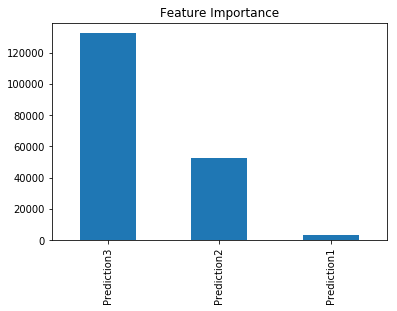

In [194]:
predictors = [x for x in x_train.drop(target_ensamble, axis = 1).columns]
feat_imp = pd.Series(model_ensamble.feature_importance("gain"), predictors).sort_values(ascending = False)
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [196]:
y_pred = model_ensamble.predict(x_test.drop(target_ensamble, axis=1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.058310457907672926

## PREDICCION EN VALIDACION

In [210]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
model_valid_pred = []
pred = model1.predict(validation.drop(leak, axis = 1))
model_valid_pred.append(pred)
pred = model2.predict_proba(validation.drop(leak, axis = 1))[:,1]
model_valid_pred.append(pred)
ada_vali = preprocess(vali, ada = True)
pred = model3.predict_proba(ada_vali.drop(leak, axis = 1))[:,1]
model_valid_pred.append(pred)

In [211]:
valid_ensamble = data_ensamble(vali, model_valid_pred)

In [212]:
valid_ensamble

,Opportunity_ID,Prediction1,Prediction2,Prediction3
0,10689,0.998788,0.996955,0.999389
1,10689,0.999138,0.997962,0.999621
2,10689,0.999398,0.997804,0.999402
3,10690,0.993625,0.994009,0.997194
4,10690,0.998060,0.995094,0.998315
5,10690,0.998792,0.995747,0.998503
6,10690,0.997848,0.995133,0.996096
7,10690,0.997637,0.993390,0.996388
8,10691,0.923639,0.969127,0.994164
9,10692,0.806164,0.978102,0.996750


In [216]:
final_pred = model_ensamble.predict(valid_ensamble.drop(["Opportunity_ID"], axis=1))
final_pred = pd.DataFrame(final_pred, index = valid_ensamble.index, columns = ["Prediction"])
answer = valid_ensamble.join(final_pred)
answer = pd.DataFrame(answer.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [217]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9887088082667632

In [219]:
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.988558566228558

In [220]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9918167240527008

In [223]:
prev = pd.read_csv("submission_ensambler_1.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

1.0

In [172]:
answer

,Opportunity_ID,Prediction
0,10689,0.994496
1,10690,0.994496
2,10691,0.994496
3,10692,0.994496
4,10693,0.994029
5,10694,0.672453
6,10695,0.217441
7,10696,0.217441
8,10697,0.217441
9,10698,0.007171


In [136]:
answer.to_csv("submission_ensambler_2.csv", index = False, header = False)

## LOGISTIC REGRESSION ENSAMBLER

In [225]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().set_params(penalty = 'l2', max_iter = 5000, verbose = 1)
x_train, x_test, y_train, y_test = train_test_split(df_ensamble, df_ensamble.Stage, test_size = 0.3, random_state = 0)
logreg.fit(x_train.drop(target_ensamble, axis = 1), y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)

In [226]:
y_pred = logreg.predict_proba(x_test.drop(target_ensamble, axis = 1))[:,1]
log_loss(y_test, y_pred)

0.06987984611061188

In [227]:
logreg.coef_

array([[2.39523855, 3.2361646 , 7.7744124 ]])

In [228]:
logreg_pred = logreg.predict_proba(valid_ensamble.drop(["Opportunity_ID"], axis = 1))[:,1]
logreg_pred = pd.DataFrame(logreg_pred, index = valid_ensamble.index, columns = ["Prediction"])
logreg_pred = valid_ensamble.join(logreg_pred)
logreg_pred = pd.DataFrame(logreg_pred.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [229]:
logreg_pred

,Opportunity_ID,Prediction
0,10689,0.999032
1,10690,0.999001
2,10691,0.998675
3,10692,0.998438
4,10693,0.998758
5,10694,0.998751
6,10695,0.001969
7,10696,0.002145
8,10697,0.003004
9,10698,0.001768


In [215]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.990848691609225

In [218]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.9964285290376039

In [221]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.9964285290376039

In [222]:
prev = pd.read_csv("submission_ensambler_1.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.9882605690316171

In [224]:
logreg_pred.to_csv("submission_ensambler_3.csv", index = False, header = False)

## ENSAMBLER CON PESOS (DEL LOGREG)

In [236]:
l = list(logreg.coef_[0])
l = l/sum(l)

In [246]:
predictions = valid_ensamble.drop(["Opportunity_ID"], axis = 1).columns

In [258]:
answer = valid_ensamble.copy()
answer["Prediction"] = sum([l[i] * answer[predictions[i]] for i in range(len(l))])
answer = answer[["Opportunity_ID", "Prediction"]]
answer = pd.DataFrame(answer.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [259]:
answer

,Opportunity_ID,Prediction
0,10689,0.998948
1,10690,0.996647
2,10691,0.975519
3,10692,0.963512
4,10693,0.980348
5,10694,0.979905
6,10695,0.016754
7,10696,0.023151
8,10697,0.048319
9,10698,0.008706


In [260]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9943585064047844

In [261]:
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9939868941156793

In [262]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9989053723423823

In [263]:
answer.to_csv("submission_ensambler_4.csv", index = False, header = False)